# Zamiana jabłek na pomarańcze

CycleGAN - umożliwia przekształcenia obrazów w obu kierunkach, 4 modele, 2 dyskryminatory i 2 generatory;

Generatory:
* G_AB - obrazy z domeny A do domeny B
* G_BA - obrazy z domeny B do domeny A

Dyskryminatory:
* d_A - różnica między autentycznymi obrazami A a wytworzonymi przez G_AB
* d_B - różnica między autentycznymi obrazami B a wytworzonymi przez G_BA


In [ ]:
import os
import matplotlib.pyplot as plt

from models.cycleGAN import CycleGAN
from utils.loaders import DataLoader

ImportError: ignored

W models.cycleGAN tworzymy obiekt CycleGAN który możemy nastepnie modyfikować

Generatory: U-Net (models.cycleGAN) , ResNet

U-Net
* downsampling - kompresowanie przestrzenne, ale rozbudowane pod względem kanałów
* upsampling - rozwijane przestrzennie, redukcja kanałów
* Pomijanie połączeń przepływ do dalszych warstw, scalenie stylu z zawartością obrazu
* Warstwa Concatenate - łączy downsampling z upsampling, liczba kanałów do 2k
* Warswa InstanceNormalization - normalizuje obserwacje indywidualnie, nie uczy wag

Dwie połówki:
-downsampling - Conv2D, krok 2
-upsampling - warstwy Concatenate


Dyskryminatory

Wyjście w postaci 8x8, podział na łaty i odgaduje czy są prawdziwe, prawdopodobieństwo dla każdej łaty, łaty oceniane równocześnie.

Zaleta: funkcja straty może mierzyć na podstawie stylu

* Zbiór warstw konwolucyjnych
* Wszystkie warstwy (oprócz 1) normalizacja

In [ ]:
# run params
SECTION = 'paint'
RUN_ID = '0001'
DATA_NAME = 'apple2orange'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' # 'build' #

**Dane**

In [ ]:
IMAGE_SIZE = 128

In [ ]:
data_loader = DataLoader(dataset_name=DATA_NAME, img_res=(IMAGE_SIZE, IMAGE_SIZE))

**Budowa sieci**

In [ ]:
gan = CycleGAN(
    input_dim = (IMAGE_SIZE,IMAGE_SIZE,3)
    ,learning_rate = 0.0002
    , buffer_max_length = 50
    , lambda_validation = 1
    , lambda_reconstr = 10
    , lambda_id = 2
    , generator_type = 'unet'
    , gen_n_filters = 32
    , disc_n_filters = 32
    )

if mode == 'build':
    gan.save(RUN_FOLDER)
else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
gan.g_AB.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 64, 64, 32)   1568        ['input_3[0][0]']                
                                                                                                  
 instance_normalization_6 (Inst  (None, 64, 64, 32)  0           ['conv2d_10[0][0]']              
 anceNormalization)                                                                               
                                                                                            

In [ ]:
gan.g_BA.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_70 (Conv2D)             (None, 64, 64, 32)   1568        ['input_16[0][0]']               
                                                                                                  
 instance_normalization_53 (Ins  (None, 64, 64, 32)  0           ['conv2d_70[0][0]']              
 tanceNormalization)                                                                              
                                                                                           

In [ ]:
gan.d_A.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        1568      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        32832     
                                                                 
 instance_normalization (Ins  (None, 32, 32, 64)       0         
 tanceNormalization)                                             
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                             

In [ ]:
gan.d_B.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        1568      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        32832     
                                                                 
 instance_normalization_3 (I  (None, 32, 32, 64)       0         
 nstanceNormalization)                                           
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                           

**Trenowanie sieci**

Kompilacja dyskryminatory - bezpośrednio, mamy wejścia oraz binarne wyjścia

Kompilacja generatory - nie mamy sparowanych obrazów w zestawie danych, kryteria oceny:
* poprawność - czy można oszukać dyskryminatory

        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)
* rekonstrukcja - powrót do orginalnego obrazu
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
* tożsamość - obraz niezmieniony jeśli zastosujemy każdy z generatorów
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

In [ ]:
BATCH_SIZE = 1
EPOCHS = 2
PRINT_EVERY_N_BATCHES = 10

TEST_A_FILE = 'n07740461_14740.jpg'
TEST_B_FILE = 'n07749192_4241.jpg'

* Szkolenie naprzemienne dyskryminatorów i generatorów
* Obrazy autentyczne 1, wygenerowane 0
        valid = np.ones
        fake = np.zeros
* Generator - fałszywe obrazy - trenowanie dyskryminatora
* Generatory szkolone razem

In [ ]:
gan.train(data_loader
        , run_folder = RUN_FOLDER
        , epochs=EPOCHS
        , test_A_file = TEST_A_FILE
        , test_B_file = TEST_B_FILE
        , batch_size=BATCH_SIZE
        , sample_interval=PRINT_EVERY_N_BATCHES)

1/1 [==============================] - 0s 52ms/step
[Epoch 0/2] [Batch 0/995] [D loss: 0.591839, acc:  50%] [G loss: 13.227094, adv: 1.194215, recon: 1.001627, id: 1.008302] time: 0:00:02.915385 
1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 1/995] [D loss: 0.526935, acc:  55%] [G loss: 10.520351, adv: 1.921278, recon: 0.715202, id: 0.723526] time: 0:00:07.626384 
1/1 [==============================] - 0s 45ms/step
[Epoch 0/2] [Batch 2/995] [D loss: 0.694289, acc:  46%] [G loss: 11.288391, adv: 1.160961, recon: 0.845635, id: 0.835542] time: 0:00:10.519709 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 3/995] [D loss: 0.602474, acc:  53%] [G loss: 13.029289, adv: 1.280028, recon: 0.984339, id: 0.952937] time: 0:00:12.300324 
1/1 [==============================] - 0s 45ms/step
[Epoch 0/2] [Batch 4/995] [D loss: 0.702591, acc:  46%] [G loss: 12.232045, adv: 0.980205, recon: 0.962368, id: 0.814081] time: 0:00:14.832630 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 5/995] [D loss: 0.551585, acc:  57%] [G loss: 13.230624, adv: 1.513592, recon: 0.982791, id: 0.944560] time: 0:00:17.703516 
1/1 [===============

1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 11/995] [D loss: 0.463048, acc:  51%] [G loss: 9.846847, adv: 0.960706, recon: 0.741911, id: 0.733517] time: 0:00:34.240272 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 12/995] [D loss: 0.481408, acc:  52%] [G loss: 9.717772, adv: 0.948090, recon: 0.730448, id: 0.732599] time: 0:00:37.117687 
1/1 [==============================] - 0s 91ms/step
[Epoch 0/2] [Batch 13/995] [D loss: 0.447693, acc:  50%] [G loss: 13.200855, adv: 0.852101, recon: 1.036956, id: 0.989600] time: 0:00:40.206882 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 14/995] [D loss: 0.440404, acc:  48%] [G loss: 9.182915, adv: 0.873484, recon: 0.693420, id: 0.687615] time: 0:00:42.013115 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 15/995] [D loss: 0.430586, acc:  48%] [G loss: 14.503036, adv: 0.987765, recon: 1.150174, id: 1.006764] time: 0:00:44.892118 
1/1 [=============

1/1 [==============================] - 0s 72ms/step
[Epoch 0/2] [Batch 21/995] [D loss: 0.374815, acc:  55%] [G loss: 10.961597, adv: 0.838962, recon: 0.848669, id: 0.817972] time: 0:01:03.435931 
1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 22/995] [D loss: 0.323473, acc:  57%] [G loss: 11.041632, adv: 0.800691, recon: 0.855858, id: 0.841178] time: 0:01:06.342270 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 23/995] [D loss: 0.313500, acc:  59%] [G loss: 9.839413, adv: 0.831572, recon: 0.751079, id: 0.748526] time: 0:01:08.189154 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 24/995] [D loss: 0.384566, acc:  50%] [G loss: 11.950293, adv: 1.074617, recon: 0.925076, id: 0.812459] time: 0:01:11.072781 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 25/995] [D loss: 0.394096, acc:  52%] [G loss: 8.683451, adv: 0.697437, recon: 0.677040, id: 0.607807] time: 0:01:13.977853 
1/1 [============

1/1 [==============================] - 0s 45ms/step
[Epoch 0/2] [Batch 31/995] [D loss: 0.308994, acc:  59%] [G loss: 10.496881, adv: 1.119793, recon: 0.786108, id: 0.758004] time: 0:01:33.066453 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 32/995] [D loss: 0.340961, acc:  62%] [G loss: 11.150723, adv: 0.976861, recon: 0.847943, id: 0.847214] time: 0:01:34.906621 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 33/995] [D loss: 0.307700, acc:  57%] [G loss: 8.491988, adv: 0.714835, recon: 0.652370, id: 0.626727] time: 0:01:37.468718 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 34/995] [D loss: 0.419743, acc:  55%] [G loss: 11.606380, adv: 0.698986, recon: 0.930405, id: 0.801673] time: 0:01:40.361464 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 35/995] [D loss: 0.463855, acc:  49%] [G loss: 7.349747, adv: 0.807614, recon: 0.551349, id: 0.514321] time: 0:01:43.235916 
1/1 [============

1/1 [==============================] - 0s 52ms/step
[Epoch 0/2] [Batch 41/995] [D loss: 0.286938, acc:  53%] [G loss: 8.066992, adv: 0.944690, recon: 0.607322, id: 0.524542] time: 0:02:00.880410 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 42/995] [D loss: 0.320810, acc:  51%] [G loss: 7.245130, adv: 0.677068, recon: 0.547464, id: 0.546711] time: 0:02:03.764018 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 43/995] [D loss: 0.334083, acc:  52%] [G loss: 9.057589, adv: 0.873949, recon: 0.682618, id: 0.678731] time: 0:02:05.602741 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 44/995] [D loss: 0.354730, acc:  55%] [G loss: 7.340819, adv: 0.719098, recon: 0.553551, id: 0.543104] time: 0:02:08.491609 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 45/995] [D loss: 0.342706, acc:  52%] [G loss: 10.643429, adv: 0.775546, recon: 0.829562, id: 0.786131] time: 0:02:11.385286 
1/1 [==============

1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 51/995] [D loss: 0.300727, acc:  57%] [G loss: 8.402284, adv: 0.726038, recon: 0.646326, id: 0.606493] time: 0:02:33.896953 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 52/995] [D loss: 0.354964, acc:  49%] [G loss: 8.212703, adv: 0.752139, recon: 0.625150, id: 0.604532] time: 0:02:35.673311 
1/1 [==============================] - 0s 74ms/step
[Epoch 0/2] [Batch 53/995] [D loss: 0.285966, acc:  52%] [G loss: 8.367861, adv: 0.787527, recon: 0.630714, id: 0.636598] time: 0:02:38.736846 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 54/995] [D loss: 0.349895, acc:  50%] [G loss: 10.572509, adv: 0.863604, recon: 0.811385, id: 0.797526] time: 0:02:40.508912 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 55/995] [D loss: 0.300297, acc:  58%] [G loss: 7.782453, adv: 1.010085, recon: 0.575884, id: 0.506763] time: 0:02:43.383210 
1/1 [==============

1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 61/995] [D loss: 0.307980, acc:  55%] [G loss: 7.743376, adv: 0.682644, recon: 0.596584, id: 0.547443] time: 0:03:00.234010 
1/1 [==============================] - 0s 68ms/step
[Epoch 0/2] [Batch 62/995] [D loss: 0.302099, acc:  53%] [G loss: 9.706456, adv: 0.445146, recon: 0.776147, id: 0.749921] time: 0:03:02.195984 
1/1 [==============================] - 0s 45ms/step
[Epoch 0/2] [Batch 63/995] [D loss: 0.315075, acc:  50%] [G loss: 7.059319, adv: 0.586954, recon: 0.534842, id: 0.561970] time: 0:03:03.970868 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 64/995] [D loss: 0.229581, acc:  70%] [G loss: 10.263450, adv: 0.730257, recon: 0.785945, id: 0.836871] time: 0:03:06.853143 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 65/995] [D loss: 0.327095, acc:  51%] [G loss: 6.643873, adv: 0.438454, recon: 0.521261, id: 0.496405] time: 0:03:08.601194 
1/1 [==============

1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 71/995] [D loss: 0.289795, acc:  55%] [G loss: 9.917486, adv: 0.948020, recon: 0.764417, id: 0.662647] time: 0:03:26.311143 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 72/995] [D loss: 0.371291, acc:  40%] [G loss: 8.863888, adv: 0.818333, recon: 0.685262, id: 0.596468] time: 0:03:28.050825 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 73/995] [D loss: 0.303216, acc:  53%] [G loss: 9.427712, adv: 0.999560, recon: 0.714002, id: 0.644065] time: 0:03:29.823868 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 74/995] [D loss: 0.305069, acc:  58%] [G loss: 14.314605, adv: 0.949181, recon: 1.135185, id: 1.006787] time: 0:03:31.553236 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 75/995] [D loss: 0.378190, acc:  41%] [G loss: 8.904030, adv: 0.672055, recon: 0.693482, id: 0.648576] time: 0:03:34.431078 
1/1 [==============

1/1 [==============================] - 0s 52ms/step
[Epoch 0/2] [Batch 81/995] [D loss: 0.267841, acc:  56%] [G loss: 8.056850, adv: 0.508384, recon: 0.642532, id: 0.561571] time: 0:03:51.929887 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 82/995] [D loss: 0.235272, acc:  64%] [G loss: 8.680298, adv: 0.984642, recon: 0.647268, id: 0.611487] time: 0:03:54.817978 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 83/995] [D loss: 0.258401, acc:  61%] [G loss: 6.562756, adv: 0.833026, recon: 0.479834, id: 0.465696] time: 0:03:57.709674 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 84/995] [D loss: 0.222387, acc:  66%] [G loss: 9.579645, adv: 0.767180, recon: 0.738721, id: 0.712628] time: 0:04:00.653248 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 85/995] [D loss: 0.334694, acc:  47%] [G loss: 9.070963, adv: 0.761424, recon: 0.696938, id: 0.670081] time: 0:04:02.417322 
1/1 [===============

1/1 [==============================] - 0s 59ms/step
[Epoch 0/2] [Batch 91/995] [D loss: 0.284099, acc:  49%] [G loss: 5.587769, adv: 0.691076, recon: 0.412636, id: 0.385167] time: 0:04:19.882966 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 92/995] [D loss: 0.270146, acc:  53%] [G loss: 6.785081, adv: 0.567105, recon: 0.523001, id: 0.493985] time: 0:04:22.785454 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 93/995] [D loss: 0.335283, acc:  47%] [G loss: 8.550586, adv: 0.951600, recon: 0.639275, id: 0.603117] time: 0:04:24.526797 
1/1 [==============================] - 0s 55ms/step
[Epoch 0/2] [Batch 94/995] [D loss: 0.358452, acc:  44%] [G loss: 9.971643, adv: 0.560925, recon: 0.785497, id: 0.777875] time: 0:04:27.433829 
1/1 [==============================] - 0s 52ms/step
[Epoch 0/2] [Batch 95/995] [D loss: 0.298446, acc:  68%] [G loss: 8.803527, adv: 0.876294, recon: 0.673444, id: 0.596398] time: 0:04:30.343534 
1/1 [===============

1/1 [==============================] - 0s 45ms/step
[Epoch 0/2] [Batch 101/995] [D loss: 0.222150, acc:  64%] [G loss: 7.983024, adv: 1.231290, recon: 0.563278, id: 0.559477] time: 0:04:46.791513 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 102/995] [D loss: 0.358441, acc:  47%] [G loss: 8.397519, adv: 0.625298, recon: 0.655939, id: 0.606413] time: 0:04:48.539950 
1/1 [==============================] - 0s 56ms/step
[Epoch 0/2] [Batch 103/995] [D loss: 0.210182, acc:  67%] [G loss: 8.387068, adv: 0.921337, recon: 0.624364, id: 0.611047] time: 0:04:51.428861 
1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 104/995] [D loss: 0.380527, acc:  42%] [G loss: 9.076222, adv: 0.515925, recon: 0.710354, id: 0.728377] time: 0:04:53.169269 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 105/995] [D loss: 0.340694, acc:  45%] [G loss: 9.523611, adv: 0.524175, recon: 0.749805, id: 0.750691] time: 0:04:54.902093 
1/1 [==========

1/1 [==============================] - 0s 57ms/step
[Epoch 0/2] [Batch 111/995] [D loss: 0.309086, acc:  48%] [G loss: 6.931731, adv: 0.789855, recon: 0.507744, id: 0.532219] time: 0:05:12.927595 
1/1 [==============================] - 0s 45ms/step
[Epoch 0/2] [Batch 112/995] [D loss: 0.285461, acc:  56%] [G loss: 8.158731, adv: 0.844849, recon: 0.611087, id: 0.601504] time: 0:05:15.814460 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 113/995] [D loss: 0.313162, acc:  47%] [G loss: 10.138611, adv: 0.968374, recon: 0.763310, id: 0.768569] time: 0:05:17.583019 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 114/995] [D loss: 0.269235, acc:  53%] [G loss: 7.679670, adv: 1.031898, recon: 0.560981, id: 0.518980] time: 0:05:20.465362 
1/1 [==============================] - 0s 70ms/step
[Epoch 0/2] [Batch 115/995] [D loss: 0.288335, acc:  53%] [G loss: 6.683784, adv: 0.857757, recon: 0.472597, id: 0.550031] time: 0:05:23.502734 
1/1 [=========

1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 121/995] [D loss: 0.248274, acc:  61%] [G loss: 7.586636, adv: 0.788698, recon: 0.568367, id: 0.557134] time: 0:05:41.509799 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 122/995] [D loss: 0.264379, acc:  58%] [G loss: 6.741355, adv: 0.651747, recon: 0.513893, id: 0.475341] time: 0:05:44.407287 
1/1 [==============================] - 0s 71ms/step
[Epoch 0/2] [Batch 123/995] [D loss: 0.179617, acc:  74%] [G loss: 7.763597, adv: 0.873880, recon: 0.574932, id: 0.570200] time: 0:05:47.448684 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 124/995] [D loss: 0.338273, acc:  46%] [G loss: 7.549276, adv: 1.015010, recon: 0.553583, id: 0.499216] time: 0:05:49.220229 
1/1 [==============================] - 0s 45ms/step
[Epoch 0/2] [Batch 125/995] [D loss: 0.264118, acc:  59%] [G loss: 9.898481, adv: 0.869438, recon: 0.753407, id: 0.747489] time: 0:05:52.089023 
1/1 [==========

1/1 [==============================] - 0s 70ms/step
[Epoch 0/2] [Batch 131/995] [D loss: 0.205450, acc:  69%] [G loss: 7.915032, adv: 0.876361, recon: 0.586499, id: 0.586842] time: 0:06:10.538056 
1/1 [==============================] - 0s 56ms/step
[Epoch 0/2] [Batch 132/995] [D loss: 0.318105, acc:  47%] [G loss: 7.879263, adv: 0.839742, recon: 0.585342, id: 0.593052] time: 0:06:12.318600 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 133/995] [D loss: 0.234698, acc:  68%] [G loss: 8.416548, adv: 0.804449, recon: 0.635898, id: 0.626561] time: 0:06:15.197325 
1/1 [==============================] - 0s 54ms/step
[Epoch 0/2] [Batch 134/995] [D loss: 0.151512, acc:  87%] [G loss: 12.426567, adv: 1.251908, recon: 0.922482, id: 0.974920] time: 0:06:16.988351 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 135/995] [D loss: 0.335420, acc:  54%] [G loss: 8.017810, adv: 1.231931, recon: 0.572714, id: 0.529370] time: 0:06:18.841893 
1/1 [=========

1/1 [==============================] - 0s 52ms/step
[Epoch 0/2] [Batch 141/995] [D loss: 0.303710, acc:  52%] [G loss: 7.805821, adv: 0.897902, recon: 0.585603, id: 0.525944] time: 0:06:36.874445 
1/1 [==============================] - 0s 52ms/step
[Epoch 0/2] [Batch 142/995] [D loss: 0.278420, acc:  62%] [G loss: 8.436221, adv: 0.907410, recon: 0.639162, id: 0.568597] time: 0:06:39.796708 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 143/995] [D loss: 0.324696, acc:  47%] [G loss: 7.251086, adv: 0.853995, recon: 0.539565, id: 0.500719] time: 0:06:42.683300 
1/1 [==============================] - 0s 72ms/step
[Epoch 0/2] [Batch 144/995] [D loss: 0.309361, acc:  47%] [G loss: 8.841225, adv: 0.842423, recon: 0.689456, id: 0.552122] time: 0:06:45.075408 
1/1 [==============================] - 0s 53ms/step
[Epoch 0/2] [Batch 145/995] [D loss: 0.219501, acc:  70%] [G loss: 10.115264, adv: 0.935794, recon: 0.770021, id: 0.739632] time: 0:06:46.909894 
1/1 [=========

1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 151/995] [D loss: 0.237055, acc:  64%] [G loss: 9.939037, adv: 0.858582, recon: 0.761823, id: 0.731115] time: 0:07:05.306747 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 152/995] [D loss: 0.364611, acc:  39%] [G loss: 9.062516, adv: 0.858533, recon: 0.683021, id: 0.686885] time: 0:07:08.224292 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 153/995] [D loss: 0.195540, acc:  72%] [G loss: 9.989284, adv: 0.960568, recon: 0.755269, id: 0.738014] time: 0:07:10.011608 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 154/995] [D loss: 0.332769, acc:  44%] [G loss: 7.427937, adv: 0.786730, recon: 0.558067, id: 0.530268] time: 0:07:11.835533 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 155/995] [D loss: 0.269855, acc:  57%] [G loss: 8.253011, adv: 0.923297, recon: 0.613055, id: 0.599584] time: 0:07:13.681581 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 161/995] [D loss: 0.227163, acc:  66%] [G loss: 8.019602, adv: 1.144197, recon: 0.562371, id: 0.625848] time: 0:07:30.346063 
1/1 [==============================] - 0s 68ms/step
[Epoch 0/2] [Batch 162/995] [D loss: 0.335881, acc:  63%] [G loss: 8.786725, adv: 0.970433, recon: 0.659525, id: 0.610522] time: 0:07:33.482511 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 163/995] [D loss: 0.253878, acc:  62%] [G loss: 5.867249, adv: 0.885227, recon: 0.412915, id: 0.426437] time: 0:07:35.470450 
1/1 [==============================] - 0s 76ms/step
[Epoch 0/2] [Batch 164/995] [D loss: 0.322787, acc:  53%] [G loss: 9.671150, adv: 0.881158, recon: 0.755523, id: 0.617381] time: 0:07:37.756682 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 165/995] [D loss: 0.204988, acc:  69%] [G loss: 7.293695, adv: 1.007265, recon: 0.524353, id: 0.521453] time: 0:07:39.591103 
1/1 [==========

1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 171/995] [D loss: 0.272392, acc:  60%] [G loss: 10.135344, adv: 1.017755, recon: 0.771238, id: 0.702605] time: 0:08:00.466494 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 172/995] [D loss: 0.463156, acc:  36%] [G loss: 6.695580, adv: 0.371932, recon: 0.536524, id: 0.479206] time: 0:08:03.489590 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 173/995] [D loss: 0.200311, acc:  72%] [G loss: 7.672857, adv: 0.555748, recon: 0.597250, id: 0.572305] time: 0:08:06.408264 
1/1 [==============================] - 0s 66ms/step
[Epoch 0/2] [Batch 174/995] [D loss: 0.290189, acc:  54%] [G loss: 7.815180, adv: 0.478518, recon: 0.613178, id: 0.602442] time: 0:08:08.443770 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 175/995] [D loss: 0.318477, acc:  49%] [G loss: 8.605268, adv: 0.558223, recon: 0.668267, id: 0.682186] time: 0:08:10.257621 
1/1 [=========

1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 181/995] [D loss: 0.253873, acc:  61%] [G loss: 7.966007, adv: 0.955009, recon: 0.590665, id: 0.552176] time: 0:08:28.913334 
1/1 [==============================] - 0s 66ms/step
[Epoch 0/2] [Batch 182/995] [D loss: 0.235254, acc:  62%] [G loss: 7.258103, adv: 0.800250, recon: 0.559082, id: 0.433516] time: 0:08:31.889898 
1/1 [==============================] - 0s 95ms/step
[Epoch 0/2] [Batch 183/995] [D loss: 0.180976, acc:  76%] [G loss: 6.130470, adv: 1.039098, recon: 0.424118, id: 0.425094] time: 0:08:33.905041 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 184/995] [D loss: 0.243222, acc:  64%] [G loss: 7.275580, adv: 0.884257, recon: 0.535730, id: 0.517013] time: 0:08:35.838244 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 185/995] [D loss: 0.335365, acc:  47%] [G loss: 8.010761, adv: 0.672919, recon: 0.620675, id: 0.565547] time: 0:08:38.794218 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 191/995] [D loss: 0.270306, acc:  57%] [G loss: 6.752560, adv: 0.564263, recon: 0.520265, id: 0.492824] time: 0:08:58.683387 
1/1 [==============================] - 0s 54ms/step
[Epoch 0/2] [Batch 192/995] [D loss: 0.154190, acc:  78%] [G loss: 7.817961, adv: 0.975861, recon: 0.568893, id: 0.576586] time: 0:09:01.598859 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 193/995] [D loss: 0.200420, acc:  72%] [G loss: 10.197683, adv: 0.923891, recon: 0.781095, id: 0.731420] time: 0:09:04.500865 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 194/995] [D loss: 0.149135, acc:  80%] [G loss: 8.416294, adv: 0.864326, recon: 0.638092, id: 0.585524] time: 0:09:07.407140 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 195/995] [D loss: 0.275900, acc:  57%] [G loss: 6.499840, adv: 0.745053, recon: 0.498368, id: 0.385556] time: 0:09:09.421522 
1/1 [=========

1/1 [==============================] - 0s 52ms/step
[Epoch 0/2] [Batch 201/995] [D loss: 0.330902, acc:  50%] [G loss: 7.392942, adv: 0.901386, recon: 0.550548, id: 0.493037] time: 0:09:30.402347 
1/1 [==============================] - 0s 75ms/step
[Epoch 0/2] [Batch 202/995] [D loss: 0.193514, acc:  73%] [G loss: 7.637713, adv: 0.977337, recon: 0.552595, id: 0.567215] time: 0:09:33.490509 
1/1 [==============================] - 0s 63ms/step
[Epoch 0/2] [Batch 203/995] [D loss: 0.258149, acc:  58%] [G loss: 8.131108, adv: 0.654743, recon: 0.632194, id: 0.577212] time: 0:09:36.451368 
1/1 [==============================] - 0s 57ms/step
[Epoch 0/2] [Batch 204/995] [D loss: 0.210072, acc:  70%] [G loss: 9.853055, adv: 0.758979, recon: 0.777678, id: 0.658647] time: 0:09:39.385068 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 205/995] [D loss: 0.272200, acc:  56%] [G loss: 8.627378, adv: 0.660996, recon: 0.670547, id: 0.630457] time: 0:09:41.220010 
1/1 [==========

1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 211/995] [D loss: 0.181053, acc:  73%] [G loss: 10.645679, adv: 0.990471, recon: 0.800580, id: 0.824705] time: 0:09:57.765646 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 212/995] [D loss: 0.238219, acc:  62%] [G loss: 7.541796, adv: 0.921821, recon: 0.554074, id: 0.539615] time: 0:10:00.672556 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 213/995] [D loss: 0.265397, acc:  57%] [G loss: 9.288177, adv: 0.947528, recon: 0.704275, id: 0.648952] time: 0:10:03.577834 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 214/995] [D loss: 0.207322, acc:  67%] [G loss: 7.227282, adv: 1.085262, recon: 0.515725, id: 0.492384] time: 0:10:06.464721 
1/1 [==============================] - 0s 69ms/step
[Epoch 0/2] [Batch 215/995] [D loss: 0.246599, acc:  64%] [G loss: 9.983644, adv: 1.050248, recon: 0.754445, id: 0.694475] time: 0:10:09.452867 
1/1 [=========

1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 221/995] [D loss: 0.158918, acc:  78%] [G loss: 10.409367, adv: 0.855795, recon: 0.792454, id: 0.814517] time: 0:10:28.785059 
1/1 [==============================] - 0s 70ms/step
[Epoch 0/2] [Batch 222/995] [D loss: 0.098781, acc:  91%] [G loss: 9.361153, adv: 1.265610, recon: 0.673291, id: 0.681315] time: 0:10:31.298822 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 223/995] [D loss: 0.328495, acc:  49%] [G loss: 7.688359, adv: 0.364106, recon: 0.595891, id: 0.682670] time: 0:10:34.180932 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 224/995] [D loss: 0.165772, acc:  88%] [G loss: 8.610744, adv: 0.494083, recon: 0.677520, id: 0.670729] time: 0:10:37.073867 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 225/995] [D loss: 0.226714, acc:  67%] [G loss: 8.312100, adv: 0.692111, recon: 0.642752, id: 0.596235] time: 0:10:39.985770 
1/1 [=========

1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 231/995] [D loss: 0.277514, acc:  56%] [G loss: 6.342246, adv: 0.730333, recon: 0.468359, id: 0.464164] time: 0:10:57.250631 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 232/995] [D loss: 0.341900, acc:  47%] [G loss: 10.685789, adv: 0.764195, recon: 0.827991, id: 0.820843] time: 0:10:59.096601 
1/1 [==============================] - 0s 53ms/step
[Epoch 0/2] [Batch 233/995] [D loss: 0.280700, acc:  57%] [G loss: 9.057804, adv: 1.067808, recon: 0.676568, id: 0.612156] time: 0:11:00.976345 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 234/995] [D loss: 0.244760, acc:  61%] [G loss: 7.521613, adv: 0.860532, recon: 0.555687, id: 0.552104] time: 0:11:02.845396 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 235/995] [D loss: 0.163412, acc:  79%] [G loss: 7.612312, adv: 0.468461, recon: 0.602966, id: 0.557096] time: 0:11:05.736228 
1/1 [=========

1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 241/995] [D loss: 0.270840, acc:  58%] [G loss: 8.879115, adv: 0.952694, recon: 0.671180, id: 0.607311] time: 0:11:24.143008 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 242/995] [D loss: 0.268982, acc:  63%] [G loss: 7.102664, adv: 1.048629, recon: 0.508501, id: 0.484513] time: 0:11:25.976579 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 243/995] [D loss: 0.199762, acc:  72%] [G loss: 7.313184, adv: 0.701606, recon: 0.556142, id: 0.525080] time: 0:11:27.938373 
1/1 [==============================] - 0s 67ms/step
[Epoch 0/2] [Batch 244/995] [D loss: 0.188847, acc:  73%] [G loss: 6.339567, adv: 0.822991, recon: 0.460951, id: 0.453534] time: 0:11:30.310924 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 245/995] [D loss: 0.324827, acc:  48%] [G loss: 7.656829, adv: 0.567034, recon: 0.607971, id: 0.505044] time: 0:11:32.120961 
1/1 [==========

1/1 [==============================] - 0s 45ms/step
[Epoch 0/2] [Batch 251/995] [D loss: 0.342942, acc:  42%] [G loss: 6.287045, adv: 0.497958, recon: 0.488347, id: 0.452811] time: 0:11:50.226307 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 252/995] [D loss: 0.268919, acc:  57%] [G loss: 7.611706, adv: 0.944674, recon: 0.560564, id: 0.530697] time: 0:11:52.478004 
1/1 [==============================] - 0s 68ms/step
[Epoch 0/2] [Batch 253/995] [D loss: 0.202113, acc:  69%] [G loss: 7.815920, adv: 0.674159, recon: 0.599490, id: 0.573429] time: 0:11:54.578724 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 254/995] [D loss: 0.177051, acc:  76%] [G loss: 6.899790, adv: 0.899273, recon: 0.501611, id: 0.492203] time: 0:11:57.458326 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 255/995] [D loss: 0.257031, acc:  59%] [G loss: 6.934614, adv: 0.809988, recon: 0.517045, id: 0.477090] time: 0:11:59.268665 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 261/995] [D loss: 0.177072, acc:  77%] [G loss: 6.464238, adv: 0.918717, recon: 0.469569, id: 0.424914] time: 0:12:16.809421 
1/1 [==============================] - 0s 66ms/step
[Epoch 0/2] [Batch 262/995] [D loss: 0.405616, acc:  46%] [G loss: 8.480425, adv: 0.497143, recon: 0.661156, id: 0.685860] time: 0:12:18.730286 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 263/995] [D loss: 0.390667, acc:  39%] [G loss: 7.452511, adv: 0.775670, recon: 0.568993, id: 0.493456] time: 0:12:21.622103 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 264/995] [D loss: 0.147849, acc:  82%] [G loss: 7.722039, adv: 0.644380, recon: 0.601813, id: 0.529763] time: 0:12:23.397034 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 265/995] [D loss: 0.248758, acc:  57%] [G loss: 7.123204, adv: 0.605989, recon: 0.541424, id: 0.551487] time: 0:12:25.192146 
1/1 [==========

1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 271/995] [D loss: 0.148507, acc:  80%] [G loss: 6.478072, adv: 1.084105, recon: 0.453950, id: 0.427235] time: 0:12:46.229918 
1/1 [==============================] - 0s 52ms/step
[Epoch 0/2] [Batch 272/995] [D loss: 0.320205, acc:  42%] [G loss: 5.351374, adv: 0.857307, recon: 0.383167, id: 0.331197] time: 0:12:48.199393 
1/1 [==============================] - 0s 54ms/step
[Epoch 0/2] [Batch 273/995] [D loss: 0.282562, acc:  52%] [G loss: 5.461455, adv: 1.059488, recon: 0.368995, id: 0.356008] time: 0:12:50.008115 
1/1 [==============================] - 0s 65ms/step
[Epoch 0/2] [Batch 274/995] [D loss: 0.340949, acc:  35%] [G loss: 8.809298, adv: 0.720144, recon: 0.678863, id: 0.650263] time: 0:12:52.495595 
1/1 [==============================] - 0s 59ms/step
[Epoch 0/2] [Batch 275/995] [D loss: 0.229502, acc:  65%] [G loss: 5.664565, adv: 0.509231, recon: 0.438971, id: 0.382811] time: 0:12:55.398405 
1/1 [==========

1/1 [==============================] - 0s 54ms/step
[Epoch 0/2] [Batch 281/995] [D loss: 0.179940, acc:  75%] [G loss: 9.809675, adv: 1.005009, recon: 0.736978, id: 0.717442] time: 0:13:12.729881 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 282/995] [D loss: 0.230129, acc:  62%] [G loss: 8.173227, adv: 1.321082, recon: 0.579703, id: 0.527560] time: 0:13:14.935373 
1/1 [==============================] - 0s 69ms/step
[Epoch 0/2] [Batch 283/995] [D loss: 0.127057, acc:  87%] [G loss: 5.939355, adv: 0.896634, recon: 0.433516, id: 0.353781] time: 0:13:17.021714 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 284/995] [D loss: 0.420789, acc:  30%] [G loss: 7.195212, adv: 0.688988, recon: 0.543441, id: 0.535907] time: 0:13:19.922584 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 285/995] [D loss: 0.393417, acc:  36%] [G loss: 7.624303, adv: 0.594011, recon: 0.600641, id: 0.511942] time: 0:13:21.697807 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 291/995] [D loss: 0.180958, acc:  69%] [G loss: 7.822660, adv: 1.076284, recon: 0.563115, id: 0.557615] time: 0:13:38.338786 
1/1 [==============================] - 0s 71ms/step
[Epoch 0/2] [Batch 292/995] [D loss: 0.223613, acc:  64%] [G loss: 6.469265, adv: 0.775454, recon: 0.477270, id: 0.460554] time: 0:13:41.403563 
1/1 [==============================] - 0s 59ms/step
[Epoch 0/2] [Batch 293/995] [D loss: 0.287648, acc:  56%] [G loss: 6.536609, adv: 0.711096, recon: 0.488115, id: 0.472183] time: 0:13:44.298876 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 294/995] [D loss: 0.198531, acc:  69%] [G loss: 5.621178, adv: 0.896545, recon: 0.398874, id: 0.367949] time: 0:13:47.206671 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 295/995] [D loss: 0.284657, acc:  54%] [G loss: 5.486537, adv: 0.494779, recon: 0.422320, id: 0.384281] time: 0:13:49.021468 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 301/995] [D loss: 0.265046, acc:  70%] [G loss: 8.396746, adv: 0.915491, recon: 0.625661, id: 0.612322] time: 0:14:06.522849 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 302/995] [D loss: 0.132595, acc:  87%] [G loss: 8.452215, adv: 1.396098, recon: 0.576694, id: 0.644590] time: 0:14:09.421228 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 303/995] [D loss: 0.153499, acc:  78%] [G loss: 5.973455, adv: 1.136527, recon: 0.402456, id: 0.406184] time: 0:14:12.342112 
1/1 [==============================] - 0s 67ms/step
[Epoch 0/2] [Batch 304/995] [D loss: 0.182189, acc:  76%] [G loss: 11.728959, adv: 0.782622, recon: 0.920458, id: 0.870878] time: 0:14:15.423990 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 305/995] [D loss: 0.338113, acc:  46%] [G loss: 6.572393, adv: 0.660872, recon: 0.506440, id: 0.423559] time: 0:14:17.769974 
1/1 [=========

1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 311/995] [D loss: 0.293813, acc:  59%] [G loss: 10.230682, adv: 0.379335, recon: 0.855422, id: 0.648562] time: 0:14:35.107675 
1/1 [==============================] - 0s 52ms/step
[Epoch 0/2] [Batch 312/995] [D loss: 0.298011, acc:  65%] [G loss: 7.016500, adv: 0.676922, recon: 0.520645, id: 0.566563] time: 0:14:37.999025 
1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 313/995] [D loss: 0.183818, acc:  84%] [G loss: 7.299189, adv: 1.113996, recon: 0.532617, id: 0.429511] time: 0:14:40.913566 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 314/995] [D loss: 0.272665, acc:  56%] [G loss: 7.770038, adv: 0.945736, recon: 0.581704, id: 0.503632] time: 0:14:42.673027 
1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 315/995] [D loss: 0.148542, acc:  79%] [G loss: 7.582432, adv: 1.333746, recon: 0.529296, id: 0.477862] time: 0:14:44.445220 
1/1 [=========

1/1 [==============================] - 0s 68ms/step
[Epoch 0/2] [Batch 321/995] [D loss: 0.308799, acc:  55%] [G loss: 9.296956, adv: 0.949351, recon: 0.706000, id: 0.643800] time: 0:15:04.132841 
1/1 [==============================] - 0s 66ms/step
[Epoch 0/2] [Batch 322/995] [D loss: 0.370714, acc:  40%] [G loss: 7.229742, adv: 0.769969, recon: 0.542417, id: 0.517804] time: 0:15:07.170878 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 323/995] [D loss: 0.329105, acc:  45%] [G loss: 5.464200, adv: 0.949326, recon: 0.380486, id: 0.355005] time: 0:15:09.037425 
1/1 [==============================] - 0s 89ms/step
[Epoch 0/2] [Batch 324/995] [D loss: 0.256816, acc:  51%] [G loss: 6.772160, adv: 0.670392, recon: 0.507140, id: 0.515186] time: 0:15:11.327661 
1/1 [==============================] - 0s 52ms/step
[Epoch 0/2] [Batch 325/995] [D loss: 0.167173, acc:  78%] [G loss: 8.579201, adv: 0.914386, recon: 0.647914, id: 0.592838] time: 0:15:13.758152 
1/1 [==========

1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 331/995] [D loss: 0.432254, acc:  38%] [G loss: 5.330975, adv: 0.646533, recon: 0.390408, id: 0.390181] time: 0:15:33.730028 
1/1 [==============================] - 0s 52ms/step
[Epoch 0/2] [Batch 332/995] [D loss: 0.185141, acc:  74%] [G loss: 5.330505, adv: 0.935288, recon: 0.366691, id: 0.364151] time: 0:15:35.503872 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 333/995] [D loss: 0.198984, acc:  74%] [G loss: 5.384809, adv: 0.344174, recon: 0.418117, id: 0.429732] time: 0:15:38.229029 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 334/995] [D loss: 0.332367, acc:  41%] [G loss: 7.179249, adv: 0.542254, recon: 0.553989, id: 0.548553] time: 0:15:41.128838 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 335/995] [D loss: 0.393385, acc:  42%] [G loss: 7.364687, adv: 0.543196, recon: 0.577240, id: 0.524545] time: 0:15:44.114200 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 341/995] [D loss: 0.213641, acc:  72%] [G loss: 6.771246, adv: 0.609361, recon: 0.511170, id: 0.525090] time: 0:16:04.370255 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 342/995] [D loss: 0.198226, acc:  70%] [G loss: 7.593757, adv: 0.565233, recon: 0.596312, id: 0.532704] time: 0:16:07.385645 
1/1 [==============================] - 0s 54ms/step
[Epoch 0/2] [Batch 343/995] [D loss: 0.239129, acc:  59%] [G loss: 10.174560, adv: 0.563184, recon: 0.835310, id: 0.629140] time: 0:16:10.317216 
1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 344/995] [D loss: 0.268134, acc:  54%] [G loss: 6.622034, adv: 0.800539, recon: 0.491875, id: 0.451371] time: 0:16:12.125013 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 345/995] [D loss: 0.281920, acc:  54%] [G loss: 7.126766, adv: 0.832265, recon: 0.525587, id: 0.519317] time: 0:16:14.720298 
1/1 [=========

1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 351/995] [D loss: 0.262210, acc:  61%] [G loss: 7.668756, adv: 1.274795, recon: 0.541992, id: 0.487020] time: 0:16:35.478376 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 352/995] [D loss: 0.286106, acc:  50%] [G loss: 7.386690, adv: 0.921257, recon: 0.552155, id: 0.471942] time: 0:16:38.389728 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 353/995] [D loss: 0.141113, acc:  83%] [G loss: 7.206639, adv: 1.137572, recon: 0.521378, id: 0.427645] time: 0:16:40.160140 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 354/995] [D loss: 0.125783, acc:  87%] [G loss: 6.394660, adv: 1.550975, recon: 0.396685, id: 0.438417] time: 0:16:41.948969 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 355/995] [D loss: 0.266741, acc:  57%] [G loss: 7.326073, adv: 1.399283, recon: 0.495634, id: 0.485223] time: 0:16:44.843415 
1/1 [==========

1/1 [==============================] - 0s 71ms/step
[Epoch 0/2] [Batch 361/995] [D loss: 0.547812, acc:  20%] [G loss: 6.641433, adv: 0.478800, recon: 0.505299, id: 0.554820] time: 0:17:03.153196 
1/1 [==============================] - 0s 56ms/step
[Epoch 0/2] [Batch 362/995] [D loss: 0.299629, acc:  49%] [G loss: 7.919163, adv: 1.185781, recon: 0.581119, id: 0.461097] time: 0:17:06.092777 
1/1 [==============================] - 0s 54ms/step
[Epoch 0/2] [Batch 363/995] [D loss: 0.114535, acc:  90%] [G loss: 8.636564, adv: 0.818653, recon: 0.649562, id: 0.661147] time: 0:17:07.963590 
1/1 [==============================] - 0s 52ms/step
[Epoch 0/2] [Batch 364/995] [D loss: 0.341189, acc:  50%] [G loss: 6.570588, adv: 0.769226, recon: 0.482303, id: 0.489166] time: 0:17:10.892140 
1/1 [==============================] - 0s 53ms/step
[Epoch 0/2] [Batch 365/995] [D loss: 0.164575, acc:  74%] [G loss: 7.978368, adv: 1.095419, recon: 0.583369, id: 0.524628] time: 0:17:12.991843 
1/1 [==========

1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 371/995] [D loss: 0.245825, acc:  68%] [G loss: 7.615110, adv: 1.082264, recon: 0.545042, id: 0.541212] time: 0:17:31.421330 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 372/995] [D loss: 0.171703, acc:  78%] [G loss: 5.690753, adv: 0.909528, recon: 0.389173, id: 0.444746] time: 0:17:34.327674 
1/1 [==============================] - 0s 45ms/step
[Epoch 0/2] [Batch 373/995] [D loss: 0.297121, acc:  53%] [G loss: 6.234282, adv: 0.801423, recon: 0.456447, id: 0.434196] time: 0:17:37.218614 
1/1 [==============================] - 0s 64ms/step
[Epoch 0/2] [Batch 374/995] [D loss: 0.327735, acc:  47%] [G loss: 6.746676, adv: 0.639240, recon: 0.500124, id: 0.553100] time: 0:17:40.189632 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 375/995] [D loss: 0.211075, acc:  69%] [G loss: 4.547692, adv: 0.492273, recon: 0.338401, id: 0.335704] time: 0:17:43.103645 
1/1 [==========

1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 381/995] [D loss: 0.222781, acc:  66%] [G loss: 6.899314, adv: 0.930456, recon: 0.504359, id: 0.462633] time: 0:18:01.710231 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 382/995] [D loss: 0.286708, acc:  54%] [G loss: 9.239136, adv: 1.159283, recon: 0.669258, id: 0.693637] time: 0:18:03.530044 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 383/995] [D loss: 0.367221, acc:  41%] [G loss: 5.724841, adv: 0.556797, recon: 0.431811, id: 0.424965] time: 0:18:06.541549 
1/1 [==============================] - 0s 45ms/step
[Epoch 0/2] [Batch 384/995] [D loss: 0.228402, acc:  64%] [G loss: 5.654243, adv: 0.693415, recon: 0.415165, id: 0.404592] time: 0:18:08.336783 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 385/995] [D loss: 0.204165, acc:  68%] [G loss: 6.734583, adv: 0.665279, recon: 0.505571, id: 0.506797] time: 0:18:11.228953 
1/1 [==========

1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 391/995] [D loss: 0.353505, acc:  40%] [G loss: 6.957720, adv: 0.532424, recon: 0.543071, id: 0.497295] time: 0:18:28.464011 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 392/995] [D loss: 0.339938, acc:  44%] [G loss: 6.943416, adv: 0.532615, recon: 0.544178, id: 0.484512] time: 0:18:31.365419 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 393/995] [D loss: 0.212232, acc:  68%] [G loss: 8.292066, adv: 0.879350, recon: 0.613734, id: 0.637687] time: 0:18:34.268684 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 394/995] [D loss: 0.179832, acc:  74%] [G loss: 5.618848, adv: 0.511223, recon: 0.433659, id: 0.385516] time: 0:18:37.169350 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 395/995] [D loss: 0.325338, acc:  42%] [G loss: 8.271582, adv: 0.929229, recon: 0.626941, id: 0.536472] time: 0:18:39.082576 
1/1 [==========

1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 401/995] [D loss: 0.202959, acc:  73%] [G loss: 7.784678, adv: 0.408602, recon: 0.623553, id: 0.570275] time: 0:18:56.704462 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 402/995] [D loss: 0.254640, acc:  60%] [G loss: 6.352915, adv: 0.803042, recon: 0.456629, id: 0.491793] time: 0:18:59.624539 
1/1 [==============================] - 0s 70ms/step
[Epoch 0/2] [Batch 403/995] [D loss: 0.199137, acc:  74%] [G loss: 8.690588, adv: 0.740365, recon: 0.670087, id: 0.624675] time: 0:19:01.756626 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 404/995] [D loss: 0.281813, acc:  52%] [G loss: 9.066663, adv: 1.206109, recon: 0.654867, id: 0.655944] time: 0:19:04.644302 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 405/995] [D loss: 0.197715, acc:  73%] [G loss: 5.970502, adv: 1.350889, recon: 0.372890, id: 0.445356] time: 0:19:07.539445 
1/1 [==========

1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 411/995] [D loss: 0.286767, acc:  60%] [G loss: 6.770094, adv: 0.624664, recon: 0.509321, id: 0.526110] time: 0:19:24.513385 
1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 412/995] [D loss: 0.238782, acc:  60%] [G loss: 7.972762, adv: 0.783954, recon: 0.600800, id: 0.590404] time: 0:19:27.422997 
1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 413/995] [D loss: 0.182514, acc:  74%] [G loss: 8.644109, adv: 1.111236, recon: 0.623267, id: 0.650103] time: 0:19:30.316078 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 414/995] [D loss: 0.284363, acc:  49%] [G loss: 6.023247, adv: 1.117751, recon: 0.405377, id: 0.425865] time: 0:19:32.195002 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 415/995] [D loss: 0.423481, acc:  39%] [G loss: 6.390450, adv: 0.676276, recon: 0.480918, id: 0.452498] time: 0:19:34.088052 
1/1 [==========

1/1 [==============================] - 0s 53ms/step
[Epoch 0/2] [Batch 421/995] [D loss: 0.175703, acc:  72%] [G loss: 8.232791, adv: 0.782403, recon: 0.628110, id: 0.584645] time: 0:19:53.748775 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 422/995] [D loss: 0.223425, acc:  66%] [G loss: 7.622423, adv: 0.788242, recon: 0.573737, id: 0.548406] time: 0:19:55.621905 
1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 423/995] [D loss: 0.201984, acc:  68%] [G loss: 7.607441, adv: 1.664311, recon: 0.501209, id: 0.465520] time: 0:19:58.541189 
1/1 [==============================] - 0s 76ms/step
[Epoch 0/2] [Batch 424/995] [D loss: 0.350548, acc:  49%] [G loss: 6.236084, adv: 0.970785, recon: 0.439877, id: 0.433266] time: 0:20:00.570629 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 425/995] [D loss: 0.226590, acc:  61%] [G loss: 7.964329, adv: 0.965627, recon: 0.591104, id: 0.543833] time: 0:20:02.424311 
1/1 [==========

1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 431/995] [D loss: 0.235160, acc:  63%] [G loss: 7.265670, adv: 0.575244, recon: 0.560576, id: 0.542332] time: 0:20:19.955435 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 432/995] [D loss: 0.169465, acc:  69%] [G loss: 5.590603, adv: 0.449457, recon: 0.428251, id: 0.429320] time: 0:20:22.856959 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 433/995] [D loss: 0.124590, acc:  89%] [G loss: 5.724486, adv: 0.605267, recon: 0.428360, id: 0.417809] time: 0:20:24.720883 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 434/995] [D loss: 0.292940, acc:  50%] [G loss: 8.634205, adv: 0.569567, recon: 0.700634, id: 0.529148] time: 0:20:26.549677 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 435/995] [D loss: 0.131470, acc:  85%] [G loss: 5.663106, adv: 0.624502, recon: 0.421740, id: 0.410601] time: 0:20:28.396353 
1/1 [==========

/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:625: UserWarning: Metadata Warning, tag 33723 had too many entries: 2, expected 1
  warnings.warn(


[Epoch 0/2] [Batch 438/995] [D loss: 0.208804, acc:  67%] [G loss: 4.658535, adv: 0.715366, recon: 0.331876, id: 0.312206] time: 0:20:37.102673 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 439/995] [D loss: 0.160132, acc:  74%] [G loss: 7.666986, adv: 1.399817, recon: 0.527415, id: 0.496508] time: 0:20:38.931595 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 440/995] [D loss: 0.217938, acc:  65%] [G loss: 4.475264, adv: 0.709926, recon: 0.316150, id: 0.301919] time: 0:20:40.733379 
1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 441/995] [D loss: 0.234375, acc:  63%] [G loss: 5.840138, adv: 1.104028, recon: 0.401602, id: 0.360042] time: 0:20:46.393323 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 442/995] [D loss: 0.334103, acc:  43%] [G loss: 7.134446, adv: 0.568594, recon: 0.554257, id: 0.511642] time: 0:20:48.239976 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 443/995] [D loss: 0.147870, acc:  81%] [G loss: 9.664362, adv: 1.278123, recon: 0.711180, id: 0.637220] time: 0:20:50.112909 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 444/995] [D loss: 0.126117, acc:  83%] [G loss: 7.639070, adv: 0.739909, recon: 0.576581, id: 0.566674] time: 0:20:53.009727 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 445/995] [D loss: 0.108303, acc:  85%] [G loss: 7.024924, adv: 0.802942, recon: 0.520261, id: 0.509685] time: 0:20:54.873726 
1/1 [==========

1/1 [==============================] - 0s 53ms/step
[Epoch 0/2] [Batch 451/995] [D loss: 0.170500, acc:  78%] [G loss: 4.941165, adv: 0.511198, recon: 0.375178, id: 0.339096] time: 0:21:13.558345 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 452/995] [D loss: 0.122378, acc:  86%] [G loss: 9.272415, adv: 0.909266, recon: 0.709777, id: 0.632690] time: 0:21:16.467976 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 453/995] [D loss: 0.080567, acc:  94%] [G loss: 6.852945, adv: 0.921714, recon: 0.494319, id: 0.494023] time: 0:21:18.299129 
1/1 [==============================] - 0s 45ms/step
[Epoch 0/2] [Batch 454/995] [D loss: 0.172681, acc:  74%] [G loss: 6.936372, adv: 1.041561, recon: 0.502896, id: 0.432925] time: 0:21:20.112987 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 455/995] [D loss: 0.207026, acc:  71%] [G loss: 4.812255, adv: 0.338007, recon: 0.373330, id: 0.370474] time: 0:21:23.043043 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 461/995] [D loss: 0.169999, acc:  80%] [G loss: 6.926512, adv: 0.800417, recon: 0.503572, id: 0.545185] time: 0:21:39.915192 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 462/995] [D loss: 0.235637, acc:  65%] [G loss: 5.246768, adv: 0.480357, recon: 0.403710, id: 0.364655] time: 0:21:41.805522 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 463/995] [D loss: 0.495212, acc:  37%] [G loss: 6.298152, adv: 0.481359, recon: 0.487401, id: 0.471391] time: 0:21:44.691493 
1/1 [==============================] - 0s 67ms/step
[Epoch 0/2] [Batch 464/995] [D loss: 0.190085, acc:  74%] [G loss: 7.954759, adv: 0.644897, recon: 0.611282, id: 0.598523] time: 0:21:47.723366 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 465/995] [D loss: 0.139245, acc:  86%] [G loss: 6.981832, adv: 1.017631, recon: 0.491936, id: 0.522420] time: 0:21:50.617433 
1/1 [==========

1/1 [==============================] - 0s 55ms/step
[Epoch 0/2] [Batch 471/995] [D loss: 0.199908, acc:  72%] [G loss: 6.038989, adv: 0.520019, recon: 0.465494, id: 0.432015] time: 0:22:08.746739 
1/1 [==============================] - 0s 80ms/step
[Epoch 0/2] [Batch 472/995] [D loss: 0.314452, acc:  45%] [G loss: 7.240466, adv: 0.750205, recon: 0.545611, id: 0.517077] time: 0:22:11.190116 
1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 473/995] [D loss: 0.203486, acc:  79%] [G loss: 7.622436, adv: 0.740434, recon: 0.573458, id: 0.573709] time: 0:22:14.100939 
1/1 [==============================] - 0s 54ms/step
[Epoch 0/2] [Batch 474/995] [D loss: 0.224228, acc:  64%] [G loss: 7.704741, adv: 0.839113, recon: 0.588145, id: 0.492090] time: 0:22:15.928916 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 475/995] [D loss: 0.226196, acc:  65%] [G loss: 7.454425, adv: 0.853501, recon: 0.553711, id: 0.531907] time: 0:22:18.870922 
1/1 [==========

1/1 [==============================] - 0s 71ms/step
[Epoch 0/2] [Batch 481/995] [D loss: 0.303442, acc:  42%] [G loss: 7.713873, adv: 0.896103, recon: 0.578144, id: 0.518165] time: 0:22:35.361608 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 482/995] [D loss: 0.142061, acc:  81%] [G loss: 7.009857, adv: 1.103383, recon: 0.504672, id: 0.429877] time: 0:22:37.189374 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 483/995] [D loss: 0.103303, acc:  91%] [G loss: 6.193929, adv: 0.236344, recon: 0.506333, id: 0.447127] time: 0:22:38.999201 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 484/995] [D loss: 0.321181, acc:  44%] [G loss: 5.632771, adv: 0.571562, recon: 0.419425, id: 0.433480] time: 0:22:42.000920 
1/1 [==============================] - 0s 146ms/step
[Epoch 0/2] [Batch 485/995] [D loss: 0.249889, acc:  64%] [G loss: 6.555899, adv: 0.912337, recon: 0.477822, id: 0.432670] time: 0:22:47.403550 
1/1 [=========

1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 491/995] [D loss: 0.313134, acc:  57%] [G loss: 7.438593, adv: 0.894937, recon: 0.546807, id: 0.537794] time: 0:23:05.305855 
1/1 [==============================] - 0s 103ms/step
[Epoch 0/2] [Batch 492/995] [D loss: 0.307082, acc:  53%] [G loss: 7.763629, adv: 0.655020, recon: 0.604349, id: 0.532559] time: 0:23:08.462587 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 493/995] [D loss: 0.175241, acc:  73%] [G loss: 5.707525, adv: 1.367776, recon: 0.357225, id: 0.383748] time: 0:23:10.974663 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 494/995] [D loss: 0.218220, acc:  65%] [G loss: 9.473243, adv: 1.645592, recon: 0.660703, id: 0.610311] time: 0:23:12.748147 
1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 495/995] [D loss: 0.176465, acc:  71%] [G loss: 10.986359, adv: 0.819572, recon: 0.854996, id: 0.808415] time: 0:23:15.653022 
1/1 [========

1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 501/995] [D loss: 0.393309, acc:  36%] [G loss: 5.167955, adv: 0.791029, recon: 0.358071, id: 0.398106] time: 0:23:34.783407 
1/1 [==============================] - 0s 69ms/step
[Epoch 0/2] [Batch 502/995] [D loss: 0.371911, acc:  37%] [G loss: 7.058564, adv: 1.096557, recon: 0.502153, id: 0.470237] time: 0:23:37.901771 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 503/995] [D loss: 0.240515, acc:  65%] [G loss: 8.619409, adv: 0.791811, recon: 0.655305, id: 0.637274] time: 0:23:40.239765 
1/1 [==============================] - 0s 60ms/step
[Epoch 0/2] [Batch 504/995] [D loss: 0.195036, acc:  69%] [G loss: 6.814260, adv: 1.113882, recon: 0.483072, id: 0.434831] time: 0:23:42.674892 
1/1 [==============================] - 0s 119ms/step
[Epoch 0/2] [Batch 505/995] [D loss: 0.242397, acc:  61%] [G loss: 6.758143, adv: 0.991453, recon: 0.478211, id: 0.492289] time: 0:23:45.694450 
1/1 [=========

1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 511/995] [D loss: 0.194391, acc:  71%] [G loss: 11.065882, adv: 0.878696, recon: 0.855030, id: 0.818444] time: 0:24:03.455941 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 512/995] [D loss: 0.157344, acc:  84%] [G loss: 7.061318, adv: 0.992251, recon: 0.513730, id: 0.465881] time: 0:24:06.373726 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 513/995] [D loss: 0.217733, acc:  61%] [G loss: 6.269488, adv: 1.020221, recon: 0.436561, id: 0.441829] time: 0:24:08.166889 
1/1 [==============================] - 0s 45ms/step
[Epoch 0/2] [Batch 514/995] [D loss: 0.297317, acc:  42%] [G loss: 8.897192, adv: 1.015827, recon: 0.669594, id: 0.592711] time: 0:24:11.070214 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 515/995] [D loss: 0.352657, acc:  41%] [G loss: 4.688210, adv: 0.448376, recon: 0.352914, id: 0.355349] time: 0:24:12.840215 
1/1 [=========

1/1 [==============================] - 0s 53ms/step
[Epoch 0/2] [Batch 521/995] [D loss: 0.250149, acc:  54%] [G loss: 7.136422, adv: 0.934855, recon: 0.507408, id: 0.563742] time: 0:24:30.962263 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 522/995] [D loss: 0.195319, acc:  67%] [G loss: 8.667878, adv: 0.720981, recon: 0.663518, id: 0.655859] time: 0:24:33.864686 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 523/995] [D loss: 0.242807, acc:  67%] [G loss: 7.653470, adv: 0.731883, recon: 0.575405, id: 0.583768] time: 0:24:35.694294 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 524/995] [D loss: 0.173218, acc:  74%] [G loss: 6.803646, adv: 0.979373, recon: 0.484254, id: 0.490865] time: 0:24:38.578330 
1/1 [==============================] - 0s 53ms/step
[Epoch 0/2] [Batch 525/995] [D loss: 0.133937, acc:  81%] [G loss: 6.981074, adv: 1.208759, recon: 0.473102, id: 0.520647] time: 0:24:41.473418 
1/1 [==========

1/1 [==============================] - 0s 56ms/step
[Epoch 0/2] [Batch 531/995] [D loss: 0.207208, acc:  66%] [G loss: 6.116727, adv: 0.456084, recon: 0.471325, id: 0.473698] time: 0:25:00.976775 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 532/995] [D loss: 0.225477, acc:  63%] [G loss: 6.026690, adv: 0.542745, recon: 0.465801, id: 0.412965] time: 0:25:03.903856 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 533/995] [D loss: 0.176487, acc:  73%] [G loss: 8.172976, adv: 1.110085, recon: 0.601198, id: 0.525456] time: 0:25:06.876823 
1/1 [==============================] - 0s 69ms/step
[Epoch 0/2] [Batch 534/995] [D loss: 0.139438, acc:  85%] [G loss: 9.433753, adv: 0.850719, recon: 0.738646, id: 0.598289] time: 0:25:09.922710 
1/1 [==============================] - 0s 45ms/step
[Epoch 0/2] [Batch 535/995] [D loss: 0.217152, acc:  66%] [G loss: 6.669399, adv: 1.038801, recon: 0.473168, id: 0.449461] time: 0:25:11.732953 
1/1 [==========

1/1 [==============================] - 0s 56ms/step
[Epoch 0/2] [Batch 541/995] [D loss: 0.188093, acc:  75%] [G loss: 8.102884, adv: 0.915612, recon: 0.600239, id: 0.592442] time: 0:25:30.985860 
1/1 [==============================] - 0s 45ms/step
[Epoch 0/2] [Batch 542/995] [D loss: 0.315519, acc:  51%] [G loss: 5.516847, adv: 0.770726, recon: 0.395119, id: 0.397464] time: 0:25:33.884290 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 543/995] [D loss: 0.353854, acc:  45%] [G loss: 6.083210, adv: 0.686434, recon: 0.464333, id: 0.376722] time: 0:25:35.699322 
1/1 [==============================] - 0s 44ms/step
[Epoch 0/2] [Batch 544/995] [D loss: 0.177145, acc:  75%] [G loss: 7.043085, adv: 0.872747, recon: 0.543304, id: 0.368651] time: 0:25:38.586775 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 545/995] [D loss: 0.097775, acc:  87%] [G loss: 6.907849, adv: 1.284228, recon: 0.460010, id: 0.511761] time: 0:25:40.335454 
1/1 [==========

1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 551/995] [D loss: 0.097826, acc:  90%] [G loss: 5.623559, adv: 0.948048, recon: 0.390014, id: 0.387684] time: 0:26:00.308437 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 552/995] [D loss: 0.157704, acc:  76%] [G loss: 6.939781, adv: 0.790473, recon: 0.516423, id: 0.492540] time: 0:26:03.216983 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 553/995] [D loss: 0.344125, acc:  42%] [G loss: 7.081821, adv: 0.790281, recon: 0.524986, id: 0.520840] time: 0:26:06.122702 
1/1 [==============================] - 0s 73ms/step
[Epoch 0/2] [Batch 554/995] [D loss: 0.152418, acc:  77%] [G loss: 5.909336, adv: 0.766382, recon: 0.430083, id: 0.421061] time: 0:26:09.136911 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 555/995] [D loss: 0.212032, acc:  63%] [G loss: 5.780041, adv: 0.931589, recon: 0.400779, id: 0.420329] time: 0:26:12.046820 
1/1 [==========

1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 561/995] [D loss: 0.184155, acc:  72%] [G loss: 5.894086, adv: 0.859527, recon: 0.419967, id: 0.417446] time: 0:26:29.596863 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 562/995] [D loss: 0.151739, acc:  77%] [G loss: 6.720310, adv: 1.718386, recon: 0.420210, id: 0.399910] time: 0:26:32.513978 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 563/995] [D loss: 0.156832, acc:  82%] [G loss: 5.393640, adv: 0.558493, recon: 0.406784, id: 0.383653] time: 0:26:35.411790 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 564/995] [D loss: 0.264745, acc:  57%] [G loss: 4.791838, adv: 0.610962, recon: 0.349253, id: 0.344172] time: 0:26:38.312491 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 565/995] [D loss: 0.322052, acc:  45%] [G loss: 7.644976, adv: 0.643810, recon: 0.584538, id: 0.577892] time: 0:26:41.219665 
1/1 [==========

1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 571/995] [D loss: 0.303842, acc:  49%] [G loss: 8.508919, adv: 1.203646, recon: 0.621625, id: 0.544512] time: 0:27:00.308317 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 572/995] [D loss: 0.185399, acc:  70%] [G loss: 6.874172, adv: 0.902005, recon: 0.496745, id: 0.502361] time: 0:27:02.089889 
1/1 [==============================] - 0s 55ms/step
[Epoch 0/2] [Batch 573/995] [D loss: 0.175653, acc:  72%] [G loss: 6.922929, adv: 0.967598, recon: 0.501251, id: 0.471412] time: 0:27:04.199864 
1/1 [==============================] - 0s 66ms/step
[Epoch 0/2] [Batch 574/995] [D loss: 0.160103, acc:  80%] [G loss: 7.197483, adv: 0.572729, recon: 0.554641, id: 0.539170] time: 0:27:07.224612 
1/1 [==============================] - 0s 70ms/step
[Epoch 0/2] [Batch 575/995] [D loss: 0.123568, acc:  83%] [G loss: 10.306820, adv: 1.327462, recon: 0.745014, id: 0.764609] time: 0:27:10.301901 
1/1 [=========

1/1 [==============================] - 0s 71ms/step
[Epoch 0/2] [Batch 581/995] [D loss: 0.396491, acc:  40%] [G loss: 5.251858, adv: 0.689188, recon: 0.381450, id: 0.374086] time: 0:27:30.204203 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 582/995] [D loss: 0.236758, acc:  57%] [G loss: 10.850723, adv: 1.302729, recon: 0.812469, id: 0.711652] time: 0:27:33.091832 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 583/995] [D loss: 0.305388, acc:  49%] [G loss: 5.465642, adv: 0.755151, recon: 0.392419, id: 0.393153] time: 0:27:35.327707 
1/1 [==============================] - 0s 63ms/step
[Epoch 0/2] [Batch 584/995] [D loss: 0.267296, acc:  56%] [G loss: 5.935447, adv: 0.522199, recon: 0.453886, id: 0.437192] time: 0:27:37.510341 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 585/995] [D loss: 0.314772, acc:  46%] [G loss: 6.223235, adv: 1.090425, recon: 0.421227, id: 0.460269] time: 0:27:40.412019 
1/1 [=========

1/1 [==============================] - 0s 83ms/step
[Epoch 0/2] [Batch 591/995] [D loss: 0.268660, acc:  44%] [G loss: 6.057717, adv: 0.422156, recon: 0.474505, id: 0.445258] time: 0:28:03.428960 
1/1 [==============================] - 0s 67ms/step
[Epoch 0/2] [Batch 592/995] [D loss: 0.271757, acc:  56%] [G loss: 6.266605, adv: 0.842895, recon: 0.451969, id: 0.452009] time: 0:28:05.777807 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 593/995] [D loss: 0.182628, acc:  71%] [G loss: 5.473615, adv: 0.605853, recon: 0.410915, id: 0.379307] time: 0:28:07.560739 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 594/995] [D loss: 0.140801, acc:  77%] [G loss: 5.453222, adv: 1.368547, recon: 0.339724, id: 0.343717] time: 0:28:09.356468 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 595/995] [D loss: 0.293494, acc:  52%] [G loss: 4.987796, adv: 0.661663, recon: 0.357960, id: 0.373266] time: 0:28:11.132593 
1/1 [==========

1/1 [==============================] - 0s 81ms/step
[Epoch 0/2] [Batch 601/995] [D loss: 0.201195, acc:  71%] [G loss: 5.623028, adv: 0.951845, recon: 0.389372, id: 0.388732] time: 0:28:28.532051 
1/1 [==============================] - 0s 56ms/step
[Epoch 0/2] [Batch 602/995] [D loss: 0.258404, acc:  55%] [G loss: 5.828156, adv: 0.647013, recon: 0.440491, id: 0.388118] time: 0:28:30.399744 
1/1 [==============================] - 0s 60ms/step
[Epoch 0/2] [Batch 603/995] [D loss: 0.149170, acc:  81%] [G loss: 8.056824, adv: 0.514174, recon: 0.643116, id: 0.555743] time: 0:28:32.252193 
1/1 [==============================] - 0s 55ms/step
[Epoch 0/2] [Batch 604/995] [D loss: 0.179173, acc:  71%] [G loss: 6.641453, adv: 0.672562, recon: 0.501167, id: 0.478611] time: 0:28:34.122425 
1/1 [==============================] - 0s 52ms/step
[Epoch 0/2] [Batch 605/995] [D loss: 0.175100, acc:  78%] [G loss: 7.314126, adv: 0.440285, recon: 0.571326, id: 0.580290] time: 0:28:35.985797 
1/1 [==========

1/1 [==============================] - 0s 78ms/step
[Epoch 0/2] [Batch 611/995] [D loss: 0.119200, acc:  87%] [G loss: 5.560654, adv: 0.457254, recon: 0.429514, id: 0.404128] time: 0:28:52.964423 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 612/995] [D loss: 0.383292, acc:  37%] [G loss: 8.133795, adv: 0.677265, recon: 0.624263, id: 0.606952] time: 0:28:56.084688 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 613/995] [D loss: 0.331897, acc:  52%] [G loss: 6.121108, adv: 0.925319, recon: 0.431283, id: 0.441478] time: 0:28:57.881002 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 614/995] [D loss: 0.288263, acc:  47%] [G loss: 7.048285, adv: 0.849376, recon: 0.511823, id: 0.540338] time: 0:29:00.773386 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 615/995] [D loss: 0.350039, acc:  50%] [G loss: 6.336484, adv: 0.583749, recon: 0.470787, id: 0.522435] time: 0:29:02.968371 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 621/995] [D loss: 0.196774, acc:  65%] [G loss: 6.302583, adv: 0.740908, recon: 0.468774, id: 0.436967] time: 0:29:22.647472 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 622/995] [D loss: 0.229869, acc:  62%] [G loss: 6.076199, adv: 0.933221, recon: 0.436864, id: 0.387169] time: 0:29:24.475193 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 623/995] [D loss: 0.280510, acc:  52%] [G loss: 6.079001, adv: 0.665294, recon: 0.449690, id: 0.458402] time: 0:29:26.802546 
1/1 [==============================] - 0s 71ms/step
[Epoch 0/2] [Batch 624/995] [D loss: 0.350455, acc:  51%] [G loss: 6.690558, adv: 0.956280, recon: 0.477719, id: 0.478544] time: 0:29:29.018161 
1/1 [==============================] - 0s 86ms/step
[Epoch 0/2] [Batch 625/995] [D loss: 0.240254, acc:  60%] [G loss: 5.745143, adv: 0.796760, recon: 0.422775, id: 0.360314] time: 0:29:32.104511 
1/1 [==========

1/1 [==============================] - 0s 52ms/step
[Epoch 0/2] [Batch 631/995] [D loss: 0.210755, acc:  65%] [G loss: 7.005895, adv: 0.368704, recon: 0.573512, id: 0.451034] time: 0:29:52.236804 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 632/995] [D loss: 0.166135, acc:  82%] [G loss: 6.265630, adv: 0.976672, recon: 0.442126, id: 0.433848] time: 0:29:54.042111 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 633/995] [D loss: 0.361854, acc:  45%] [G loss: 7.093335, adv: 0.373030, recon: 0.576234, id: 0.478983] time: 0:29:56.938538 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 634/995] [D loss: 0.308204, acc:  55%] [G loss: 7.312572, adv: 1.642604, recon: 0.475579, id: 0.457088] time: 0:29:58.775226 
1/1 [==============================] - 0s 53ms/step
[Epoch 0/2] [Batch 635/995] [D loss: 0.177830, acc:  73%] [G loss: 6.636024, adv: 1.226030, recon: 0.430213, id: 0.553934] time: 0:30:00.557491 
1/1 [==========

1/1 [==============================] - 0s 53ms/step
[Epoch 0/2] [Batch 641/995] [D loss: 0.264883, acc:  50%] [G loss: 8.682534, adv: 0.664131, recon: 0.665510, id: 0.681651] time: 0:30:19.380354 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 642/995] [D loss: 0.335303, acc:  41%] [G loss: 7.745588, adv: 0.921683, recon: 0.569198, id: 0.565963] time: 0:30:21.250533 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 643/995] [D loss: 0.266352, acc:  55%] [G loss: 7.023939, adv: 0.805991, recon: 0.531138, id: 0.453286] time: 0:30:23.713307 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 644/995] [D loss: 0.458715, acc:  22%] [G loss: 5.525955, adv: 0.409508, recon: 0.430508, id: 0.405683] time: 0:30:26.738854 
1/1 [==============================] - 0s 79ms/step
[Epoch 0/2] [Batch 645/995] [D loss: 0.287918, acc:  45%] [G loss: 6.415214, adv: 0.632234, recon: 0.492156, id: 0.430708] time: 0:30:29.766354 
1/1 [==========

1/1 [==============================] - 0s 53ms/step
[Epoch 0/2] [Batch 651/995] [D loss: 0.206793, acc:  60%] [G loss: 8.269981, adv: 0.897479, recon: 0.619413, id: 0.589187] time: 0:30:46.833264 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 652/995] [D loss: 0.318771, acc:  33%] [G loss: 4.808846, adv: 0.771081, recon: 0.347300, id: 0.282381] time: 0:30:48.822594 
1/1 [==============================] - 0s 67ms/step
[Epoch 0/2] [Batch 653/995] [D loss: 0.270588, acc:  51%] [G loss: 7.316483, adv: 0.591865, recon: 0.555011, id: 0.587256] time: 0:30:51.846037 
1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 654/995] [D loss: 0.205531, acc:  74%] [G loss: 7.628057, adv: 0.618550, recon: 0.587919, id: 0.565160] time: 0:30:53.636991 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 655/995] [D loss: 0.201601, acc:  67%] [G loss: 5.074960, adv: 0.571004, recon: 0.381599, id: 0.343984] time: 0:30:55.459267 
1/1 [==========

1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 661/995] [D loss: 0.328730, acc:  37%] [G loss: 4.802666, adv: 0.908515, recon: 0.317173, id: 0.361209] time: 0:31:12.601431 
1/1 [==============================] - 0s 69ms/step
[Epoch 0/2] [Batch 662/995] [D loss: 0.279456, acc:  65%] [G loss: 8.429865, adv: 1.260129, recon: 0.599551, id: 0.587111] time: 0:31:15.181803 
1/1 [==============================] - 0s 45ms/step
[Epoch 0/2] [Batch 663/995] [D loss: 0.258501, acc:  57%] [G loss: 6.177304, adv: 0.885945, recon: 0.436818, id: 0.461591] time: 0:31:17.008831 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 664/995] [D loss: 0.220019, acc:  64%] [G loss: 6.569231, adv: 0.696978, recon: 0.482948, id: 0.521385] time: 0:31:19.900930 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 665/995] [D loss: 0.184737, acc:  72%] [G loss: 5.561481, adv: 0.649990, recon: 0.392871, id: 0.491393] time: 0:31:22.818876 
1/1 [==========

1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 671/995] [D loss: 0.270477, acc:  56%] [G loss: 5.818481, adv: 0.453637, recon: 0.447194, id: 0.446453] time: 0:31:41.702603 
1/1 [==============================] - 0s 52ms/step
[Epoch 0/2] [Batch 672/995] [D loss: 0.160082, acc:  80%] [G loss: 8.609835, adv: 0.553882, recon: 0.686359, id: 0.596180] time: 0:31:43.545257 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 673/995] [D loss: 0.361734, acc:  44%] [G loss: 5.656918, adv: 0.482359, recon: 0.433506, id: 0.419752] time: 0:31:46.430294 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 674/995] [D loss: 0.164270, acc:  82%] [G loss: 7.178521, adv: 0.963150, recon: 0.523095, id: 0.492211] time: 0:31:49.333959 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 675/995] [D loss: 0.334872, acc:  42%] [G loss: 6.808188, adv: 0.994989, recon: 0.492863, id: 0.442286] time: 0:31:51.184746 
1/1 [==========

1/1 [==============================] - 0s 53ms/step
[Epoch 0/2] [Batch 681/995] [D loss: 0.192006, acc:  72%] [G loss: 6.274459, adv: 0.681404, recon: 0.471781, id: 0.437621] time: 0:32:10.221241 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 682/995] [D loss: 0.223108, acc:  62%] [G loss: 7.754355, adv: 0.711185, recon: 0.582909, id: 0.607041] time: 0:32:12.508898 
1/1 [==============================] - 0s 68ms/step
[Epoch 0/2] [Batch 683/995] [D loss: 0.180801, acc:  75%] [G loss: 8.339656, adv: 0.831844, recon: 0.638751, id: 0.560149] time: 0:32:15.685808 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 684/995] [D loss: 0.279181, acc:  52%] [G loss: 7.490228, adv: 1.089350, recon: 0.539181, id: 0.504533] time: 0:32:17.537928 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 685/995] [D loss: 0.163663, acc:  77%] [G loss: 4.994538, adv: 0.390162, recon: 0.386142, id: 0.371478] time: 0:32:19.420804 
1/1 [==========

1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 691/995] [D loss: 0.289006, acc:  47%] [G loss: 5.340508, adv: 0.291793, recon: 0.419288, id: 0.427919] time: 0:32:37.609684 
1/1 [==============================] - 0s 45ms/step
[Epoch 0/2] [Batch 692/995] [D loss: 0.336956, acc:  33%] [G loss: 6.235569, adv: 0.630244, recon: 0.466864, id: 0.468340] time: 0:32:40.504462 
1/1 [==============================] - 0s 52ms/step
[Epoch 0/2] [Batch 693/995] [D loss: 0.193659, acc:  68%] [G loss: 7.331769, adv: 0.830854, recon: 0.546590, id: 0.517505] time: 0:32:43.407429 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 694/995] [D loss: 0.306219, acc:  47%] [G loss: 3.892562, adv: 0.628057, recon: 0.266038, id: 0.302064] time: 0:32:46.304722 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 695/995] [D loss: 0.350714, acc:  46%] [G loss: 6.785755, adv: 0.755531, recon: 0.502764, id: 0.501293] time: 0:32:48.707978 
1/1 [==========

1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 701/995] [D loss: 0.135231, acc:  84%] [G loss: 5.685094, adv: 1.095921, recon: 0.388335, id: 0.352911] time: 0:33:09.951747 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 702/995] [D loss: 0.156711, acc:  79%] [G loss: 9.035559, adv: 0.794732, recon: 0.686485, id: 0.687990] time: 0:33:12.490299 
1/1 [==============================] - 0s 70ms/step
[Epoch 0/2] [Batch 703/995] [D loss: 0.110355, acc:  88%] [G loss: 5.873648, adv: 1.276264, recon: 0.385604, id: 0.370671] time: 0:33:14.414068 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 704/995] [D loss: 0.226638, acc:  64%] [G loss: 7.635993, adv: 0.982966, recon: 0.578389, id: 0.434570] time: 0:33:17.308866 
1/1 [==============================] - 0s 52ms/step
[Epoch 0/2] [Batch 705/995] [D loss: 0.459232, acc:  23%] [G loss: 7.079690, adv: 0.329786, recon: 0.565903, id: 0.545435] time: 0:33:20.211241 
1/1 [==========

1/1 [==============================] - 0s 68ms/step
[Epoch 0/2] [Batch 711/995] [D loss: 0.213875, acc:  62%] [G loss: 6.215093, adv: 0.700577, recon: 0.465354, id: 0.430490] time: 0:33:37.881081 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 712/995] [D loss: 0.167063, acc:  78%] [G loss: 6.838503, adv: 0.411809, recon: 0.532306, id: 0.551818] time: 0:33:40.791630 
1/1 [==============================] - 0s 52ms/step
[Epoch 0/2] [Batch 713/995] [D loss: 0.137790, acc:  83%] [G loss: 4.661190, adv: 0.434056, recon: 0.344489, id: 0.391123] time: 0:33:42.579403 
1/1 [==============================] - 0s 45ms/step
[Epoch 0/2] [Batch 714/995] [D loss: 0.254216, acc:  52%] [G loss: 7.824827, adv: 0.915036, recon: 0.585193, id: 0.528929] time: 0:33:44.349743 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 715/995] [D loss: 0.305736, acc:  50%] [G loss: 6.574746, adv: 1.249377, recon: 0.449500, id: 0.415184] time: 0:33:47.241247 
1/1 [==========

1/1 [==============================] - 0s 45ms/step
[Epoch 0/2] [Batch 721/995] [D loss: 0.205282, acc:  71%] [G loss: 7.174910, adv: 0.842681, recon: 0.531291, id: 0.509662] time: 0:34:04.194011 
1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 722/995] [D loss: 0.259752, acc:  54%] [G loss: 6.932954, adv: 0.755883, recon: 0.527067, id: 0.453202] time: 0:34:07.093955 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 723/995] [D loss: 0.270059, acc:  57%] [G loss: 5.886749, adv: 0.838190, recon: 0.430928, id: 0.369642] time: 0:34:08.865347 
1/1 [==============================] - 0s 53ms/step
[Epoch 0/2] [Batch 724/995] [D loss: 0.199705, acc:  65%] [G loss: 5.377983, adv: 0.482015, recon: 0.406167, id: 0.417148] time: 0:34:11.769871 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 725/995] [D loss: 0.208610, acc:  64%] [G loss: 6.252935, adv: 0.508197, recon: 0.480143, id: 0.471653] time: 0:34:13.561856 
1/1 [==========

1/1 [==============================] - 0s 52ms/step
[Epoch 0/2] [Batch 731/995] [D loss: 0.156722, acc:  78%] [G loss: 8.234076, adv: 1.067670, recon: 0.603773, id: 0.564336] time: 0:34:31.301965 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 732/995] [D loss: 0.252572, acc:  61%] [G loss: 6.257712, adv: 0.898206, recon: 0.441600, id: 0.471752] time: 0:34:33.045244 
1/1 [==============================] - 0s 45ms/step
[Epoch 0/2] [Batch 733/995] [D loss: 0.321103, acc:  40%] [G loss: 7.576550, adv: 0.869226, recon: 0.557423, id: 0.566547] time: 0:34:36.131329 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 734/995] [D loss: 0.279557, acc:  53%] [G loss: 5.478976, adv: 0.583650, recon: 0.406302, id: 0.416156] time: 0:34:39.049430 
1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 735/995] [D loss: 0.145875, acc:  77%] [G loss: 6.634708, adv: 1.127635, recon: 0.460945, id: 0.448813] time: 0:34:40.851787 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 741/995] [D loss: 0.329882, acc:  48%] [G loss: 5.069909, adv: 0.894315, recon: 0.344201, id: 0.366789] time: 0:34:58.072121 
1/1 [==============================] - 0s 68ms/step
[Epoch 0/2] [Batch 742/995] [D loss: 0.297017, acc:  62%] [G loss: 5.510814, adv: 0.495768, recon: 0.422218, id: 0.396434] time: 0:35:01.116489 
1/1 [==============================] - 0s 52ms/step
[Epoch 0/2] [Batch 743/995] [D loss: 0.210939, acc:  65%] [G loss: 6.603018, adv: 0.627452, recon: 0.496206, id: 0.506750] time: 0:35:02.944406 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 744/995] [D loss: 0.185319, acc:  76%] [G loss: 7.956842, adv: 0.471394, recon: 0.628544, id: 0.600005] time: 0:35:04.708927 
1/1 [==============================] - 0s 45ms/step
[Epoch 0/2] [Batch 745/995] [D loss: 0.419722, acc:  46%] [G loss: 5.863653, adv: 0.620354, recon: 0.443219, id: 0.405556] time: 0:35:07.605592 
1/1 [==========

1/1 [==============================] - 0s 72ms/step
[Epoch 0/2] [Batch 751/995] [D loss: 0.141179, acc:  85%] [G loss: 5.070401, adv: 0.596325, recon: 0.378824, id: 0.342916] time: 0:35:26.323989 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 752/995] [D loss: 0.275750, acc:  53%] [G loss: 5.044638, adv: 0.413001, recon: 0.390491, id: 0.363364] time: 0:35:29.412789 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 753/995] [D loss: 0.296027, acc:  53%] [G loss: 6.502748, adv: 1.043949, recon: 0.463937, id: 0.409717] time: 0:35:32.318330 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 754/995] [D loss: 0.310725, acc:  44%] [G loss: 6.829789, adv: 0.886222, recon: 0.498353, id: 0.480018] time: 0:35:34.291313 
1/1 [==============================] - 0s 65ms/step
[Epoch 0/2] [Batch 755/995] [D loss: 0.244745, acc:  55%] [G loss: 8.147986, adv: 0.708507, recon: 0.620300, id: 0.618239] time: 0:35:37.329349 
1/1 [==========

1/1 [==============================] - 0s 58ms/step
[Epoch 0/2] [Batch 761/995] [D loss: 0.207063, acc:  70%] [G loss: 8.385266, adv: 1.118118, recon: 0.609284, id: 0.587153] time: 0:35:56.698686 
1/1 [==============================] - 0s 58ms/step
[Epoch 0/2] [Batch 762/995] [D loss: 0.097856, acc:  91%] [G loss: 6.282976, adv: 1.002280, recon: 0.444925, id: 0.415726] time: 0:35:59.251966 
1/1 [==============================] - 0s 81ms/step
[Epoch 0/2] [Batch 763/995] [D loss: 0.442525, acc:  34%] [G loss: 5.252191, adv: 0.598514, recon: 0.392440, id: 0.364639] time: 0:36:01.224796 
1/1 [==============================] - 0s 57ms/step
[Epoch 0/2] [Batch 764/995] [D loss: 0.356209, acc:  39%] [G loss: 5.587195, adv: 0.690050, recon: 0.413566, id: 0.380745] time: 0:36:03.035233 
1/1 [==============================] - 0s 58ms/step
[Epoch 0/2] [Batch 765/995] [D loss: 0.304318, acc:  41%] [G loss: 6.317029, adv: 0.623352, recon: 0.485534, id: 0.419166] time: 0:36:04.855844 
1/1 [==========

1/1 [==============================] - 0s 56ms/step
[Epoch 0/2] [Batch 771/995] [D loss: 0.080315, acc:  95%] [G loss: 8.635632, adv: 0.858787, recon: 0.641942, id: 0.678711] time: 0:36:21.696197 
1/1 [==============================] - 0s 67ms/step
[Epoch 0/2] [Batch 772/995] [D loss: 0.168740, acc:  71%] [G loss: 6.032176, adv: 1.219633, recon: 0.387715, id: 0.467695] time: 0:36:24.935684 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 773/995] [D loss: 0.315564, acc:  48%] [G loss: 5.921218, adv: 1.217912, recon: 0.384740, id: 0.427953] time: 0:36:26.734412 
1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 774/995] [D loss: 0.315244, acc:  57%] [G loss: 8.097341, adv: 0.621798, recon: 0.638103, id: 0.547258] time: 0:36:29.637076 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 775/995] [D loss: 0.249372, acc:  62%] [G loss: 5.805928, adv: 0.713201, recon: 0.426000, id: 0.416364] time: 0:36:31.425327 
1/1 [==========

1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 781/995] [D loss: 0.289476, acc:  52%] [G loss: 4.789868, adv: 0.519991, recon: 0.357806, id: 0.345911] time: 0:36:49.220909 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 782/995] [D loss: 0.306530, acc:  46%] [G loss: 7.503603, adv: 0.732715, recon: 0.574888, id: 0.511002] time: 0:36:52.120634 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 783/995] [D loss: 0.248493, acc:  55%] [G loss: 5.438608, adv: 0.699196, recon: 0.396495, id: 0.387229] time: 0:36:53.936410 
1/1 [==============================] - 0s 45ms/step
[Epoch 0/2] [Batch 784/995] [D loss: 0.389679, acc:  36%] [G loss: 6.903690, adv: 0.936530, recon: 0.499320, id: 0.486980] time: 0:36:56.815423 
1/1 [==============================] - 0s 72ms/step
[Epoch 0/2] [Batch 785/995] [D loss: 0.347620, acc:  38%] [G loss: 6.263437, adv: 0.628434, recon: 0.473638, id: 0.449310] time: 0:36:59.853315 
1/1 [==========

1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 791/995] [D loss: 0.220280, acc:  68%] [G loss: 5.207817, adv: 0.480982, recon: 0.393279, id: 0.397024] time: 0:37:17.000653 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 792/995] [D loss: 0.157726, acc:  73%] [G loss: 5.961972, adv: 0.564203, recon: 0.454091, id: 0.428431] time: 0:37:18.788142 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 793/995] [D loss: 0.128414, acc:  83%] [G loss: 7.296516, adv: 1.061109, recon: 0.510684, id: 0.564285] time: 0:37:21.684332 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 794/995] [D loss: 0.078855, acc:  96%] [G loss: 7.245664, adv: 1.275025, recon: 0.506609, id: 0.452275] time: 0:37:23.476820 
1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 795/995] [D loss: 0.280964, acc:  64%] [G loss: 5.776167, adv: 0.637687, recon: 0.429749, id: 0.420495] time: 0:37:25.228223 
1/1 [==========

1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 801/995] [D loss: 0.160950, acc:  73%] [G loss: 6.075576, adv: 0.964332, recon: 0.421740, id: 0.446922] time: 0:37:40.526116 
1/1 [==============================] - 0s 53ms/step
[Epoch 0/2] [Batch 802/995] [D loss: 0.137228, acc:  83%] [G loss: 6.334572, adv: 1.184644, recon: 0.430602, id: 0.421952] time: 0:37:42.361876 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 803/995] [D loss: 0.192547, acc:  74%] [G loss: 6.576689, adv: 1.750483, recon: 0.399326, id: 0.416473] time: 0:37:44.393476 
1/1 [==============================] - 0s 73ms/step
[Epoch 0/2] [Batch 804/995] [D loss: 0.378861, acc:  37%] [G loss: 6.918350, adv: 0.875291, recon: 0.519886, id: 0.422100] time: 0:37:46.603976 
1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 805/995] [D loss: 0.296375, acc:  60%] [G loss: 6.468907, adv: 0.500283, recon: 0.497658, id: 0.496022] time: 0:37:48.391268 
1/1 [==========

1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 811/995] [D loss: 0.120718, acc:  82%] [G loss: 7.607930, adv: 0.734890, recon: 0.575216, id: 0.560440] time: 0:38:03.973413 
1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 812/995] [D loss: 0.124972, acc:  89%] [G loss: 6.352920, adv: 0.724897, recon: 0.483137, id: 0.398329] time: 0:38:05.784225 
1/1 [==============================] - 0s 55ms/step
[Epoch 0/2] [Batch 813/995] [D loss: 0.192001, acc:  67%] [G loss: 7.102796, adv: 0.956698, recon: 0.510653, id: 0.519787] time: 0:38:07.567443 
1/1 [==============================] - 0s 53ms/step
[Epoch 0/2] [Batch 814/995] [D loss: 0.214692, acc:  63%] [G loss: 11.313360, adv: 0.661640, recon: 0.888062, id: 0.885552] time: 0:38:10.583242 
1/1 [==============================] - 0s 58ms/step
[Epoch 0/2] [Batch 815/995] [D loss: 0.289705, acc:  55%] [G loss: 7.084933, adv: 1.456717, recon: 0.470842, id: 0.459900] time: 0:38:13.473091 
1/1 [=========

1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 821/995] [D loss: 0.330282, acc:  54%] [G loss: 6.474164, adv: 0.478493, recon: 0.500625, id: 0.494708] time: 0:38:29.685332 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 822/995] [D loss: 0.297900, acc:  53%] [G loss: 5.520417, adv: 1.288362, recon: 0.353494, id: 0.348556] time: 0:38:31.492989 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 823/995] [D loss: 0.329853, acc:  56%] [G loss: 6.841025, adv: 1.131448, recon: 0.477063, id: 0.469472] time: 0:38:34.402132 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 824/995] [D loss: 0.158121, acc:  78%] [G loss: 7.018643, adv: 1.199080, recon: 0.487285, id: 0.473358] time: 0:38:37.313780 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 825/995] [D loss: 0.243840, acc:  64%] [G loss: 5.152645, adv: 1.033605, recon: 0.341506, id: 0.351992] time: 0:38:40.235862 
1/1 [==========

1/1 [==============================] - 0s 55ms/step
[Epoch 0/2] [Batch 831/995] [D loss: 0.213977, acc:  66%] [G loss: 6.255558, adv: 0.967119, recon: 0.443821, id: 0.425113] time: 0:38:56.417709 
1/1 [==============================] - 0s 72ms/step
[Epoch 0/2] [Batch 832/995] [D loss: 0.175860, acc:  74%] [G loss: 6.878993, adv: 0.966816, recon: 0.482849, id: 0.541843] time: 0:38:58.751204 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 833/995] [D loss: 0.266544, acc:  63%] [G loss: 6.802523, adv: 0.855821, recon: 0.498832, id: 0.479189] time: 0:39:00.549835 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 834/995] [D loss: 0.165944, acc:  73%] [G loss: 6.535573, adv: 0.600961, recon: 0.496432, id: 0.485148] time: 0:39:03.458309 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 835/995] [D loss: 0.281412, acc:  53%] [G loss: 7.856435, adv: 0.780312, recon: 0.607735, id: 0.499387] time: 0:39:05.267408 
1/1 [==========

1/1 [==============================] - 0s 73ms/step
[Epoch 0/2] [Batch 841/995] [D loss: 0.180695, acc:  76%] [G loss: 8.202663, adv: 1.065913, recon: 0.600055, id: 0.568099] time: 0:39:24.404409 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 842/995] [D loss: 0.365837, acc:  48%] [G loss: 7.680954, adv: 0.920188, recon: 0.569511, id: 0.532830] time: 0:39:26.196979 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 843/995] [D loss: 0.207228, acc:  63%] [G loss: 5.486816, adv: 0.609789, recon: 0.412199, id: 0.377519] time: 0:39:28.056547 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 844/995] [D loss: 0.507328, acc:  46%] [G loss: 4.572248, adv: 0.600867, recon: 0.328818, id: 0.341601] time: 0:39:29.821695 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 845/995] [D loss: 0.138585, acc:  83%] [G loss: 6.421621, adv: 1.186706, recon: 0.437297, id: 0.430974] time: 0:39:32.755666 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 851/995] [D loss: 0.443315, acc:  57%] [G loss: 5.334583, adv: 0.763815, recon: 0.377803, id: 0.396368] time: 0:39:49.206495 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 852/995] [D loss: 0.234165, acc:  61%] [G loss: 5.477708, adv: 0.679374, recon: 0.402444, id: 0.386946] time: 0:39:51.071919 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 853/995] [D loss: 0.426704, acc:  25%] [G loss: 6.754560, adv: 0.781022, recon: 0.506658, id: 0.453478] time: 0:39:53.965123 
1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 854/995] [D loss: 0.231396, acc:  58%] [G loss: 6.293277, adv: 0.682412, recon: 0.476692, id: 0.421970] time: 0:39:56.852917 
1/1 [==============================] - 0s 52ms/step
[Epoch 0/2] [Batch 855/995] [D loss: 0.245108, acc:  61%] [G loss: 5.494962, adv: 0.886247, recon: 0.379391, id: 0.407401] time: 0:39:59.760379 
1/1 [==========

1/1 [==============================] - 0s 59ms/step
[Epoch 0/2] [Batch 861/995] [D loss: 0.150871, acc:  76%] [G loss: 5.972356, adv: 0.577894, recon: 0.450556, id: 0.444450] time: 0:40:16.765654 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 862/995] [D loss: 0.242786, acc:  55%] [G loss: 5.916570, adv: 0.497020, recon: 0.447285, id: 0.473352] time: 0:40:18.723823 
1/1 [==============================] - 0s 66ms/step
[Epoch 0/2] [Batch 863/995] [D loss: 0.223785, acc:  54%] [G loss: 6.614688, adv: 0.829922, recon: 0.475544, id: 0.514664] time: 0:40:20.961125 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 864/995] [D loss: 0.235695, acc:  64%] [G loss: 6.653553, adv: 0.534699, recon: 0.516317, id: 0.477843] time: 0:40:22.703302 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 865/995] [D loss: 0.295090, acc:  47%] [G loss: 5.674866, adv: 0.333593, recon: 0.440062, id: 0.470324] time: 0:40:24.431031 
1/1 [==========

1/1 [==============================] - 0s 53ms/step
[Epoch 0/2] [Batch 871/995] [D loss: 0.184444, acc:  70%] [G loss: 7.114985, adv: 0.778518, recon: 0.524384, id: 0.546313] time: 0:40:44.816252 
1/1 [==============================] - 0s 56ms/step
[Epoch 0/2] [Batch 872/995] [D loss: 0.229499, acc:  62%] [G loss: 6.088400, adv: 0.905660, recon: 0.437149, id: 0.405623] time: 0:40:47.725086 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 873/995] [D loss: 0.262918, acc:  50%] [G loss: 5.818051, adv: 0.807379, recon: 0.422929, id: 0.390692] time: 0:40:49.456962 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 874/995] [D loss: 0.173866, acc:  79%] [G loss: 5.444462, adv: 0.900194, recon: 0.384630, id: 0.348985] time: 0:40:52.366805 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 875/995] [D loss: 0.058655, acc:  97%] [G loss: 5.708710, adv: 0.605377, recon: 0.414289, id: 0.480222] time: 0:40:55.289340 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 881/995] [D loss: 0.319322, acc:  45%] [G loss: 7.018661, adv: 0.767421, recon: 0.536989, id: 0.440673] time: 0:41:10.554114 
1/1 [==============================] - 0s 54ms/step
[Epoch 0/2] [Batch 882/995] [D loss: 0.199147, acc:  63%] [G loss: 5.312922, adv: 0.559948, recon: 0.399867, id: 0.377154] time: 0:41:13.459942 
1/1 [==============================] - 0s 52ms/step
[Epoch 0/2] [Batch 883/995] [D loss: 0.230480, acc:  59%] [G loss: 5.844185, adv: 0.676386, recon: 0.432318, id: 0.422308] time: 0:41:16.364635 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 884/995] [D loss: 0.309713, acc:  44%] [G loss: 5.981836, adv: 0.785458, recon: 0.438976, id: 0.403310] time: 0:41:18.435714 
1/1 [==============================] - 0s 71ms/step
[Epoch 0/2] [Batch 885/995] [D loss: 0.165898, acc:  73%] [G loss: 6.779347, adv: 0.570320, recon: 0.517229, id: 0.518370] time: 0:41:21.500646 
1/1 [==========

1/1 [==============================] - 0s 54ms/step
[Epoch 0/2] [Batch 891/995] [D loss: 0.181719, acc:  74%] [G loss: 6.954773, adv: 0.614203, recon: 0.527428, id: 0.533147] time: 0:41:36.675525 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 892/995] [D loss: 0.071886, acc:  95%] [G loss: 7.323678, adv: 0.811933, recon: 0.536877, id: 0.571487] time: 0:41:39.567028 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 893/995] [D loss: 0.329465, acc:  43%] [G loss: 7.194829, adv: 0.638842, recon: 0.548567, id: 0.535157] time: 0:41:41.296342 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 894/995] [D loss: 0.180025, acc:  75%] [G loss: 7.259447, adv: 0.738193, recon: 0.549180, id: 0.514728] time: 0:41:43.715841 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 895/995] [D loss: 0.092322, acc:  92%] [G loss: 5.346821, adv: 0.530558, recon: 0.400016, id: 0.408053] time: 0:41:46.616752 
1/1 [==========

1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 901/995] [D loss: 0.323426, acc:  59%] [G loss: 5.361038, adv: 0.928046, recon: 0.374657, id: 0.343209] time: 0:42:04.311098 
1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 902/995] [D loss: 0.076708, acc:  94%] [G loss: 6.549123, adv: 1.156058, recon: 0.449961, id: 0.446729] time: 0:42:06.500199 
1/1 [==============================] - 0s 69ms/step
[Epoch 0/2] [Batch 903/995] [D loss: 0.476366, acc:  40%] [G loss: 5.537500, adv: 0.939357, recon: 0.389835, id: 0.349896] time: 0:42:08.545571 
1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 904/995] [D loss: 0.317174, acc:  73%] [G loss: 5.764058, adv: 0.663040, recon: 0.426217, id: 0.419424] time: 0:42:11.454431 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 905/995] [D loss: 0.217948, acc:  62%] [G loss: 5.583577, adv: 0.902599, recon: 0.392693, id: 0.377023] time: 0:42:13.210770 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 911/995] [D loss: 0.149890, acc:  78%] [G loss: 6.418321, adv: 0.608847, recon: 0.489307, id: 0.458204] time: 0:42:30.832762 
1/1 [==============================] - 0s 70ms/step
[Epoch 0/2] [Batch 912/995] [D loss: 0.159010, acc:  84%] [G loss: 8.067188, adv: 1.143484, recon: 0.574114, id: 0.591280] time: 0:42:32.709297 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 913/995] [D loss: 0.453252, acc:  37%] [G loss: 8.342480, adv: 0.636354, recon: 0.654303, id: 0.581548] time: 0:42:35.604471 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 914/995] [D loss: 0.158449, acc:  81%] [G loss: 4.889965, adv: 0.736494, recon: 0.348785, id: 0.332813] time: 0:42:38.503251 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 915/995] [D loss: 0.314178, acc:  55%] [G loss: 6.357211, adv: 0.507289, recon: 0.498938, id: 0.430270] time: 0:42:40.262940 
1/1 [==========

1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 921/995] [D loss: 0.258359, acc:  59%] [G loss: 6.049148, adv: 0.670942, recon: 0.443655, id: 0.470827] time: 0:42:57.732734 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 922/995] [D loss: 0.330827, acc:  40%] [G loss: 6.236144, adv: 0.697417, recon: 0.472385, id: 0.407439] time: 0:43:00.639568 
1/1 [==============================] - 0s 119ms/step
[Epoch 0/2] [Batch 923/995] [D loss: 0.195401, acc:  71%] [G loss: 6.424914, adv: 0.687904, recon: 0.477529, id: 0.480862] time: 0:43:06.744504 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 924/995] [D loss: 0.228047, acc:  61%] [G loss: 7.007918, adv: 0.924496, recon: 0.505271, id: 0.515358] time: 0:43:08.506479 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 925/995] [D loss: 0.230079, acc:  61%] [G loss: 6.206367, adv: 0.571849, recon: 0.464982, id: 0.492347] time: 0:43:10.342475 
1/1 [=========

1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 931/995] [D loss: 0.142882, acc:  81%] [G loss: 4.877773, adv: 0.367290, recon: 0.377183, id: 0.369325] time: 0:43:26.661394 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 932/995] [D loss: 0.294741, acc:  53%] [G loss: 6.723344, adv: 0.749668, recon: 0.511251, id: 0.430582] time: 0:43:29.570450 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 933/995] [D loss: 0.258876, acc:  57%] [G loss: 6.374339, adv: 0.605996, recon: 0.486637, id: 0.450985] time: 0:43:31.350056 
1/1 [==============================] - 0s 46ms/step
[Epoch 0/2] [Batch 934/995] [D loss: 0.153570, acc:  78%] [G loss: 7.703820, adv: 1.463275, recon: 0.525489, id: 0.492828] time: 0:43:34.248569 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 935/995] [D loss: 0.315624, acc:  51%] [G loss: 5.462518, adv: 1.138566, recon: 0.364902, id: 0.337467] time: 0:43:37.161948 
1/1 [==========

1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 941/995] [D loss: 0.182064, acc:  77%] [G loss: 5.998053, adv: 0.530392, recon: 0.447282, id: 0.497423] time: 0:43:56.110490 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 942/995] [D loss: 0.382981, acc:  43%] [G loss: 5.377738, adv: 1.026733, recon: 0.372287, id: 0.314069] time: 0:43:57.896921 
1/1 [==============================] - 0s 52ms/step
[Epoch 0/2] [Batch 943/995] [D loss: 0.210855, acc:  63%] [G loss: 8.523973, adv: 1.205661, recon: 0.624891, id: 0.534702] time: 0:44:00.790316 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 944/995] [D loss: 0.058073, acc:  99%] [G loss: 7.162620, adv: 1.983261, recon: 0.423612, id: 0.471620] time: 0:44:03.700741 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 945/995] [D loss: 0.214117, acc:  66%] [G loss: 7.200274, adv: 1.541458, recon: 0.469754, id: 0.480638] time: 0:44:05.452682 
1/1 [==========

1/1 [==============================] - 0s 56ms/step
[Epoch 0/2] [Batch 951/995] [D loss: 0.058027, acc:  96%] [G loss: 6.965738, adv: 1.483130, recon: 0.466174, id: 0.410434] time: 0:44:25.113837 
1/1 [==============================] - 0s 61ms/step
[Epoch 0/2] [Batch 952/995] [D loss: 0.260904, acc:  54%] [G loss: 5.778878, adv: 1.425278, recon: 0.372145, id: 0.316074] time: 0:44:28.082883 
1/1 [==============================] - 0s 56ms/step
[Epoch 0/2] [Batch 953/995] [D loss: 0.129504, acc:  84%] [G loss: 10.927830, adv: 0.831368, recon: 0.861052, id: 0.742970] time: 0:44:31.019536 
1/1 [==============================] - 0s 57ms/step
[Epoch 0/2] [Batch 954/995] [D loss: 0.235994, acc:  56%] [G loss: 6.532000, adv: 0.799868, recon: 0.489901, id: 0.416563] time: 0:44:33.955053 
1/1 [==============================] - 0s 55ms/step
[Epoch 0/2] [Batch 955/995] [D loss: 0.332089, acc:  43%] [G loss: 5.519970, adv: 0.900638, recon: 0.403682, id: 0.291258] time: 0:44:35.775647 
1/1 [=========

1/1 [==============================] - 0s 51ms/step
[Epoch 0/2] [Batch 961/995] [D loss: 0.132501, acc:  83%] [G loss: 6.898603, adv: 0.544073, recon: 0.545900, id: 0.447767] time: 0:44:50.888496 
1/1 [==============================] - 0s 79ms/step
[Epoch 0/2] [Batch 962/995] [D loss: 0.278182, acc:  51%] [G loss: 5.491183, adv: 0.891378, recon: 0.384275, id: 0.378526] time: 0:44:53.933813 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 963/995] [D loss: 0.291875, acc:  52%] [G loss: 5.427944, adv: 0.566385, recon: 0.414292, id: 0.359320] time: 0:44:56.866517 
1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 964/995] [D loss: 0.120649, acc:  86%] [G loss: 5.865047, adv: 0.674540, recon: 0.444456, id: 0.372972] time: 0:44:58.633408 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 965/995] [D loss: 0.521090, acc:   3%] [G loss: 10.486990, adv: 0.322272, recon: 0.853706, id: 0.813828] time: 0:45:01.533122 
1/1 [=========

1/1 [==============================] - 0s 47ms/step
[Epoch 0/2] [Batch 971/995] [D loss: 0.153320, acc:  78%] [G loss: 6.525830, adv: 0.974724, recon: 0.464163, id: 0.454737] time: 0:45:18.736674 
1/1 [==============================] - 0s 55ms/step
[Epoch 0/2] [Batch 972/995] [D loss: 0.132072, acc:  79%] [G loss: 8.392695, adv: 1.362885, recon: 0.604006, id: 0.494878] time: 0:45:21.651675 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 973/995] [D loss: 0.207381, acc:  66%] [G loss: 6.689663, adv: 0.740497, recon: 0.511680, id: 0.416180] time: 0:45:24.560741 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 974/995] [D loss: 0.140022, acc:  82%] [G loss: 7.295080, adv: 0.416331, recon: 0.574971, id: 0.564518] time: 0:45:27.478308 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 975/995] [D loss: 0.113968, acc:  86%] [G loss: 6.075093, adv: 0.945286, recon: 0.435945, id: 0.385180] time: 0:45:29.277352 
1/1 [==========

1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 981/995] [D loss: 0.328619, acc:  55%] [G loss: 8.566725, adv: 1.627303, recon: 0.581069, id: 0.564367] time: 0:45:45.228511 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 982/995] [D loss: 0.314112, acc:  52%] [G loss: 7.111760, adv: 0.491549, recon: 0.559820, id: 0.511005] time: 0:45:48.136466 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 983/995] [D loss: 0.258901, acc:  65%] [G loss: 6.790796, adv: 0.657470, recon: 0.520293, id: 0.465200] time: 0:45:50.655351 
1/1 [==============================] - 0s 50ms/step
[Epoch 0/2] [Batch 984/995] [D loss: 0.322062, acc:  54%] [G loss: 8.015821, adv: 1.191021, recon: 0.566445, id: 0.580176] time: 0:45:53.539107 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 985/995] [D loss: 0.127300, acc:  83%] [G loss: 8.369631, adv: 1.332608, recon: 0.596937, id: 0.533829] time: 0:45:56.432628 
1/1 [==========

1/1 [==============================] - 0s 67ms/step
[Epoch 0/2] [Batch 991/995] [D loss: 0.128315, acc:  92%] [G loss: 6.350401, adv: 0.932426, recon: 0.452757, id: 0.445203] time: 0:46:16.370531 
1/1 [==============================] - 0s 49ms/step
[Epoch 0/2] [Batch 992/995] [D loss: 0.347131, acc:  48%] [G loss: 5.674572, adv: 0.653161, recon: 0.425936, id: 0.381023] time: 0:46:19.260402 
1/1 [==============================] - 0s 48ms/step
[Epoch 0/2] [Batch 993/995] [D loss: 0.093305, acc:  93%] [G loss: 7.163682, adv: 0.572296, recon: 0.549629, id: 0.547548] time: 0:46:21.040926 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 0/995] [D loss: 0.243146, acc:  60%] [G loss: 4.875355, adv: 0.289393, recon: 0.386715, id: 0.359406] time: 0:46:22.799223 
1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 1/995] [D loss: 0.268012, acc:  49%] [G loss: 8.951804, adv: 0.705553, recon: 0.705747, id: 0.594390] time: 0:46:29.290863 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 2/995] [D loss: 0.116232, acc:  85%] [G loss: 5.297260, adv: 1.463345, recon: 0.327272, id: 0.280596] time: 0:46:31.076480 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 3/995] [D loss: 0.279199, acc:  58%] [G loss: 4.990324, adv: 0.667673, recon: 0.362855, id: 0.347048] time: 0:46:33.996913 
1/1 [==============================] - 0s 53ms/step
[Epoch 1/2] [Batch 4/995] [D loss: 0.206769, acc:  62%] [G loss: 5.694598, adv: 0.787508, recon: 0.418172, id: 0.362685] time: 0:46:35.839185 
1/1 [==============================] - 0s 69ms/step
[Epoch 1/2] [Batch 5/995] [D loss: 0.173330, acc:  74%] [G loss: 7.806031, adv: 0.401103, recon: 0.622821, id: 0.588360] time: 0:46:38.892256 
1/1 [====================

1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 11/995] [D loss: 0.117933, acc:  86%] [G loss: 5.781829, adv: 0.890283, recon: 0.411852, id: 0.386514] time: 0:46:56.254012 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 12/995] [D loss: 0.324845, acc:  49%] [G loss: 7.351393, adv: 0.596549, recon: 0.573425, id: 0.510298] time: 0:46:59.162730 
1/1 [==============================] - 0s 67ms/step
[Epoch 1/2] [Batch 13/995] [D loss: 0.253018, acc:  61%] [G loss: 5.438062, adv: 0.380756, recon: 0.423835, id: 0.409478] time: 0:47:01.609617 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 14/995] [D loss: 0.239642, acc:  71%] [G loss: 7.828068, adv: 1.002202, recon: 0.585502, id: 0.485425] time: 0:47:03.398838 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 15/995] [D loss: 0.081278, acc:  94%] [G loss: 7.323542, adv: 1.133842, recon: 0.536567, id: 0.412013] time: 0:47:05.179851 
1/1 [===============

1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 21/995] [D loss: 0.072235, acc:  98%] [G loss: 5.628584, adv: 1.174121, recon: 0.373238, id: 0.361040] time: 0:47:24.065301 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 22/995] [D loss: 0.233209, acc:  60%] [G loss: 4.517208, adv: 0.217814, recon: 0.359098, id: 0.354206] time: 0:47:25.889259 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 23/995] [D loss: 0.400336, acc:  23%] [G loss: 5.139038, adv: 0.433038, recon: 0.402116, id: 0.342418] time: 0:47:28.801738 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 24/995] [D loss: 0.289320, acc:  53%] [G loss: 5.385471, adv: 0.565939, recon: 0.400669, id: 0.406422] time: 0:47:30.571675 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 25/995] [D loss: 0.159906, acc:  75%] [G loss: 6.444546, adv: 0.744697, recon: 0.475370, id: 0.473074] time: 0:47:33.473902 
1/1 [===============

1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 31/995] [D loss: 0.375664, acc:  51%] [G loss: 5.895135, adv: 0.903678, recon: 0.413573, id: 0.427865] time: 0:47:50.506683 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 32/995] [D loss: 0.375767, acc:  50%] [G loss: 5.094211, adv: 0.751433, recon: 0.367809, id: 0.332342] time: 0:47:53.536911 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 33/995] [D loss: 0.259604, acc:  59%] [G loss: 6.327544, adv: 0.478621, recon: 0.501944, id: 0.414741] time: 0:47:56.462519 
1/1 [==============================] - 0s 52ms/step
[Epoch 1/2] [Batch 34/995] [D loss: 0.236704, acc:  67%] [G loss: 4.075976, adv: 0.548908, recon: 0.295810, id: 0.284482] time: 0:47:59.384214 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 35/995] [D loss: 0.300714, acc:  49%] [G loss: 4.954012, adv: 0.738565, recon: 0.350561, id: 0.354920] time: 0:48:01.161957 
1/1 [===============

1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 41/995] [D loss: 0.128543, acc:  79%] [G loss: 9.111574, adv: 0.627268, recon: 0.733186, id: 0.576224] time: 0:48:18.275338 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 42/995] [D loss: 0.217036, acc:  65%] [G loss: 6.345823, adv: 0.633448, recon: 0.481231, id: 0.450032] time: 0:48:20.020071 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 43/995] [D loss: 0.116876, acc:  88%] [G loss: 7.652043, adv: 1.090875, recon: 0.550846, id: 0.526352] time: 0:48:22.307797 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 44/995] [D loss: 0.079030, acc:  97%] [G loss: 7.817883, adv: 0.974501, recon: 0.588728, id: 0.478050] time: 0:48:24.088767 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 45/995] [D loss: 0.143664, acc:  85%] [G loss: 7.787829, adv: 0.970639, recon: 0.570946, id: 0.553865] time: 0:48:25.879083 
1/1 [===============

1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 51/995] [D loss: 0.232359, acc:  62%] [G loss: 4.690689, adv: 1.480337, recon: 0.269478, id: 0.257787] time: 0:48:43.187451 
1/1 [==============================] - 0s 69ms/step
[Epoch 1/2] [Batch 52/995] [D loss: 0.453283, acc:  23%] [G loss: 6.401440, adv: 0.556698, recon: 0.495738, id: 0.443679] time: 0:48:46.259065 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 53/995] [D loss: 0.361496, acc:  35%] [G loss: 4.617654, adv: 0.442033, recon: 0.345237, id: 0.361624] time: 0:48:48.034775 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 54/995] [D loss: 0.219494, acc:  65%] [G loss: 5.393818, adv: 0.419675, recon: 0.417441, id: 0.399865] time: 0:48:50.956687 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 55/995] [D loss: 0.276580, acc:  52%] [G loss: 5.780694, adv: 0.574433, recon: 0.437406, id: 0.416103] time: 0:48:53.861670 
1/1 [===============

1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 61/995] [D loss: 0.202470, acc:  68%] [G loss: 14.034590, adv: 1.036478, recon: 1.103267, id: 0.982720] time: 0:49:12.532466 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 62/995] [D loss: 0.189881, acc:  72%] [G loss: 6.640627, adv: 0.804194, recon: 0.502746, id: 0.404485] time: 0:49:15.417827 
1/1 [==============================] - 0s 52ms/step
[Epoch 1/2] [Batch 63/995] [D loss: 0.311258, acc:  48%] [G loss: 6.243769, adv: 0.599060, recon: 0.471593, id: 0.464390] time: 0:49:18.334615 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 64/995] [D loss: 0.270679, acc:  57%] [G loss: 6.058108, adv: 0.605895, recon: 0.460402, id: 0.424094] time: 0:49:20.082625 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 65/995] [D loss: 0.163970, acc:  81%] [G loss: 5.888032, adv: 0.611706, recon: 0.446480, id: 0.405765] time: 0:49:21.811334 
1/1 [==============

1/1 [==============================] - 0s 44ms/step
[Epoch 1/2] [Batch 71/995] [D loss: 0.415026, acc:  32%] [G loss: 6.662813, adv: 0.846938, recon: 0.488374, id: 0.466069] time: 0:49:40.141466 
1/1 [==============================] - 0s 64ms/step
[Epoch 1/2] [Batch 72/995] [D loss: 0.176535, acc:  75%] [G loss: 4.302071, adv: 0.725411, recon: 0.297742, id: 0.299618] time: 0:49:42.303256 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 73/995] [D loss: 0.279011, acc:  46%] [G loss: 7.259562, adv: 0.816537, recon: 0.542935, id: 0.506840] time: 0:49:45.220038 
1/1 [==============================] - 0s 54ms/step
[Epoch 1/2] [Batch 74/995] [D loss: 0.213466, acc:  66%] [G loss: 5.254088, adv: 0.659453, recon: 0.388310, id: 0.355769] time: 0:49:48.129018 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 75/995] [D loss: 0.162639, acc:  77%] [G loss: 7.116306, adv: 0.446208, recon: 0.560031, id: 0.534895] time: 0:49:51.028359 
1/1 [===============

1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 81/995] [D loss: 0.119207, acc:  86%] [G loss: 6.352240, adv: 0.660293, recon: 0.473030, id: 0.480824] time: 0:50:10.376056 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 82/995] [D loss: 0.480581, acc:  39%] [G loss: 8.608775, adv: 1.376613, recon: 0.605394, id: 0.589111] time: 0:50:12.139297 
1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 83/995] [D loss: 0.204207, acc:  69%] [G loss: 7.132225, adv: 1.109762, recon: 0.496302, id: 0.529722] time: 0:50:15.067231 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 84/995] [D loss: 0.309462, acc:  54%] [G loss: 6.201046, adv: 0.781283, recon: 0.458641, id: 0.416675] time: 0:50:16.860064 
1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 85/995] [D loss: 0.335431, acc:  40%] [G loss: 5.543244, adv: 0.557738, recon: 0.424413, id: 0.370689] time: 0:50:18.639842 
1/1 [===============

1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 91/995] [D loss: 0.246284, acc:  64%] [G loss: 6.723980, adv: 0.991073, recon: 0.472219, id: 0.505360] time: 0:50:37.056616 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 92/995] [D loss: 0.267110, acc:  50%] [G loss: 6.593390, adv: 0.559534, recon: 0.509728, id: 0.468288] time: 0:50:38.825514 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 93/995] [D loss: 0.167944, acc:  71%] [G loss: 6.859945, adv: 0.954517, recon: 0.502033, id: 0.442551] time: 0:50:41.734522 
1/1 [==============================] - 0s 52ms/step
[Epoch 1/2] [Batch 94/995] [D loss: 0.250263, acc:  54%] [G loss: 4.843369, adv: 0.540178, recon: 0.359461, id: 0.354289] time: 0:50:43.523716 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 95/995] [D loss: 0.238635, acc:  56%] [G loss: 6.267076, adv: 0.941144, recon: 0.448193, id: 0.422002] time: 0:50:46.437466 
1/1 [===============

1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 101/995] [D loss: 0.213516, acc:  59%] [G loss: 5.236683, adv: 0.440276, recon: 0.400765, id: 0.394377] time: 0:51:03.614840 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 102/995] [D loss: 0.193752, acc:  66%] [G loss: 8.085905, adv: 0.556078, recon: 0.612807, id: 0.700880] time: 0:51:05.391583 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 103/995] [D loss: 0.118053, acc:  92%] [G loss: 6.415433, adv: 0.943668, recon: 0.456291, id: 0.454426] time: 0:51:08.305240 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 104/995] [D loss: 0.254696, acc:  55%] [G loss: 6.797000, adv: 0.546047, recon: 0.539606, id: 0.427447] time: 0:51:11.226685 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 105/995] [D loss: 0.378758, acc:  37%] [G loss: 5.840766, adv: 1.077426, recon: 0.392342, id: 0.419961] time: 0:51:14.147782 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 111/995] [D loss: 0.210102, acc:  70%] [G loss: 9.090117, adv: 0.746730, recon: 0.732898, id: 0.507201] time: 0:51:32.850039 
1/1 [==============================] - 0s 52ms/step
[Epoch 1/2] [Batch 112/995] [D loss: 0.355618, acc:  37%] [G loss: 5.838630, adv: 0.653745, recon: 0.441687, id: 0.384005] time: 0:51:35.757481 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 113/995] [D loss: 0.183229, acc:  68%] [G loss: 7.632663, adv: 1.115287, recon: 0.566857, id: 0.424401] time: 0:51:37.565222 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 114/995] [D loss: 0.152928, acc:  71%] [G loss: 4.901283, adv: 0.940704, recon: 0.336904, id: 0.295771] time: 0:51:39.354900 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 115/995] [D loss: 0.192531, acc:  66%] [G loss: 6.138429, adv: 0.435983, recon: 0.480312, id: 0.449661] time: 0:51:42.256421 
1/1 [==========

1/1 [==============================] - 0s 73ms/step
[Epoch 1/2] [Batch 121/995] [D loss: 0.200832, acc:  68%] [G loss: 5.486145, adv: 1.451233, recon: 0.337231, id: 0.331303] time: 0:51:58.143995 
1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 122/995] [D loss: 0.153182, acc:  75%] [G loss: 6.737937, adv: 0.489720, recon: 0.528271, id: 0.482754] time: 0:51:59.949526 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 123/995] [D loss: 0.114481, acc:  90%] [G loss: 5.639984, adv: 1.274480, recon: 0.361802, id: 0.373741] time: 0:52:02.846384 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 124/995] [D loss: 0.314362, acc:  39%] [G loss: 7.167748, adv: 0.392861, recon: 0.582290, id: 0.475994] time: 0:52:05.744479 
1/1 [==============================] - 0s 79ms/step
[Epoch 1/2] [Batch 125/995] [D loss: 0.261208, acc:  47%] [G loss: 5.941355, adv: 0.370194, recon: 0.468132, id: 0.444922] time: 0:52:08.861074 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 131/995] [D loss: 0.110464, acc:  88%] [G loss: 8.677485, adv: 0.779636, recon: 0.662184, id: 0.638005] time: 0:52:26.446323 
1/1 [==============================] - 0s 53ms/step
[Epoch 1/2] [Batch 132/995] [D loss: 0.134275, acc:  81%] [G loss: 7.860678, adv: 0.678747, recon: 0.594524, id: 0.618348] time: 0:52:28.301010 
1/1 [==============================] - 0s 69ms/step
[Epoch 1/2] [Batch 133/995] [D loss: 0.230392, acc:  52%] [G loss: 5.091921, adv: 0.660008, recon: 0.375017, id: 0.340874] time: 0:52:30.542441 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 134/995] [D loss: 0.127241, acc:  88%] [G loss: 6.035111, adv: 1.479733, recon: 0.387545, id: 0.339966] time: 0:52:33.443653 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 135/995] [D loss: 0.098178, acc:  93%] [G loss: 8.334912, adv: 0.718470, recon: 0.639776, id: 0.609340] time: 0:52:36.351428 
1/1 [==========

1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 141/995] [D loss: 0.163672, acc:  73%] [G loss: 5.865179, adv: 0.781155, recon: 0.423270, id: 0.425664] time: 0:52:55.022612 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 142/995] [D loss: 0.110491, acc:  92%] [G loss: 5.000677, adv: 0.706680, recon: 0.366521, id: 0.314395] time: 0:52:56.848479 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 143/995] [D loss: 0.205122, acc:  74%] [G loss: 7.109409, adv: 0.708125, recon: 0.537783, id: 0.511729] time: 0:52:59.747335 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 144/995] [D loss: 0.118757, acc:  88%] [G loss: 6.085303, adv: 0.767738, recon: 0.446382, id: 0.426873] time: 0:53:02.640942 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 145/995] [D loss: 0.167727, acc:  76%] [G loss: 6.451149, adv: 1.173016, recon: 0.444528, id: 0.416427] time: 0:53:04.492252 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 151/995] [D loss: 0.247273, acc:  55%] [G loss: 5.982499, adv: 0.785104, recon: 0.436297, id: 0.417214] time: 0:53:26.212907 
1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 152/995] [D loss: 0.296775, acc:  59%] [G loss: 7.531555, adv: 0.941502, recon: 0.551116, id: 0.539444] time: 0:53:29.145734 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 153/995] [D loss: 0.051548, acc:  98%] [G loss: 6.411661, adv: 1.316970, recon: 0.416967, id: 0.462508] time: 0:53:30.928359 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 154/995] [D loss: 0.303383, acc:  40%] [G loss: 5.842964, adv: 0.548418, recon: 0.447913, id: 0.407707] time: 0:53:33.856346 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 155/995] [D loss: 0.077409, acc:  88%] [G loss: 4.213833, adv: 0.296911, recon: 0.327023, id: 0.323347] time: 0:53:36.755046 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 161/995] [D loss: 0.216186, acc:  71%] [G loss: 5.658967, adv: 0.553049, recon: 0.428746, id: 0.409227] time: 0:53:55.264391 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 162/995] [D loss: 0.086145, acc:  91%] [G loss: 5.228904, adv: 0.953453, recon: 0.347441, id: 0.400519] time: 0:53:57.056837 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 163/995] [D loss: 0.295414, acc:  45%] [G loss: 4.486693, adv: 0.519560, recon: 0.335215, id: 0.307493] time: 0:53:59.334960 
1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 164/995] [D loss: 0.254794, acc:  69%] [G loss: 7.242231, adv: 0.540181, recon: 0.559809, id: 0.551978] time: 0:54:02.262152 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 165/995] [D loss: 0.210121, acc:  66%] [G loss: 5.125245, adv: 0.703240, recon: 0.363729, id: 0.392359] time: 0:54:05.177500 
1/1 [==========

1/1 [==============================] - 0s 68ms/step
[Epoch 1/2] [Batch 171/995] [D loss: 0.109633, acc:  85%] [G loss: 7.741333, adv: 0.778726, recon: 0.588255, id: 0.540030] time: 0:54:23.683408 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 172/995] [D loss: 0.230747, acc:  64%] [G loss: 5.313502, adv: 0.375473, recon: 0.412441, id: 0.406808] time: 0:54:25.477027 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 173/995] [D loss: 0.257692, acc:  63%] [G loss: 4.732935, adv: 0.676015, recon: 0.335436, id: 0.351278] time: 0:54:28.380378 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 174/995] [D loss: 0.235331, acc:  65%] [G loss: 7.598130, adv: 1.194843, recon: 0.532988, id: 0.536706] time: 0:54:30.157800 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 175/995] [D loss: 0.092749, acc:  93%] [G loss: 6.943911, adv: 1.298703, recon: 0.476749, id: 0.438861] time: 0:54:31.974485 
1/1 [==========

1/1 [==============================] - 0s 52ms/step
[Epoch 1/2] [Batch 181/995] [D loss: 0.348775, acc:  37%] [G loss: 6.284465, adv: 0.463952, recon: 0.483775, id: 0.491383] time: 0:54:52.741410 
1/1 [==============================] - 0s 54ms/step
[Epoch 1/2] [Batch 182/995] [D loss: 0.404439, acc:  45%] [G loss: 6.016360, adv: 1.030953, recon: 0.413216, id: 0.426621] time: 0:54:54.541901 
1/1 [==============================] - 0s 79ms/step
[Epoch 1/2] [Batch 183/995] [D loss: 0.179818, acc:  74%] [G loss: 6.714812, adv: 0.647816, recon: 0.507285, id: 0.497073] time: 0:54:56.836675 
1/1 [==============================] - 0s 58ms/step
[Epoch 1/2] [Batch 184/995] [D loss: 0.147574, acc:  81%] [G loss: 7.605186, adv: 0.641386, recon: 0.570702, id: 0.628391] time: 0:54:59.774486 
1/1 [==============================] - 0s 56ms/step
[Epoch 1/2] [Batch 185/995] [D loss: 0.193786, acc:  71%] [G loss: 5.337573, adv: 0.632699, recon: 0.394899, id: 0.377941] time: 0:55:01.596233 
1/1 [==========

1/1 [==============================] - 0s 57ms/step
[Epoch 1/2] [Batch 191/995] [D loss: 0.265059, acc:  56%] [G loss: 4.907461, adv: 1.035950, recon: 0.328543, id: 0.293039] time: 0:55:21.772510 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 192/995] [D loss: 0.206302, acc:  69%] [G loss: 5.382142, adv: 0.611414, recon: 0.404927, id: 0.360731] time: 0:55:24.698138 
1/1 [==============================] - 0s 54ms/step
[Epoch 1/2] [Batch 193/995] [D loss: 0.209455, acc:  69%] [G loss: 4.608889, adv: 0.406221, recon: 0.358044, id: 0.311116] time: 0:55:26.478823 
1/1 [==============================] - 0s 60ms/step
[Epoch 1/2] [Batch 194/995] [D loss: 0.245331, acc:  61%] [G loss: 5.181312, adv: 0.608882, recon: 0.371849, id: 0.426969] time: 0:55:28.272746 
1/1 [==============================] - 0s 78ms/step
[Epoch 1/2] [Batch 195/995] [D loss: 0.099021, acc:  91%] [G loss: 4.435699, adv: 0.557760, recon: 0.321139, id: 0.333277] time: 0:55:31.336556 
1/1 [==========

1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 201/995] [D loss: 0.266578, acc:  62%] [G loss: 6.113039, adv: 0.857582, recon: 0.447610, id: 0.389681] time: 0:55:51.565830 
1/1 [==============================] - 0s 67ms/step
[Epoch 1/2] [Batch 202/995] [D loss: 0.170861, acc:  70%] [G loss: 6.888267, adv: 0.370541, recon: 0.556644, id: 0.475645] time: 0:55:54.623328 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 203/995] [D loss: 0.120007, acc:  84%] [G loss: 6.615832, adv: 0.609238, recon: 0.501543, id: 0.495584] time: 0:55:56.414714 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 204/995] [D loss: 0.158025, acc:  79%] [G loss: 6.114355, adv: 0.268585, recon: 0.489821, id: 0.473781] time: 0:55:58.190008 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 205/995] [D loss: 0.339819, acc:  60%] [G loss: 6.784521, adv: 1.364897, recon: 0.450330, id: 0.458163] time: 0:55:59.979377 
1/1 [==========

1/1 [==============================] - 0s 54ms/step
[Epoch 1/2] [Batch 211/995] [D loss: 0.184100, acc:  70%] [G loss: 5.895254, adv: 0.952905, recon: 0.397804, id: 0.482153] time: 0:56:17.726524 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 212/995] [D loss: 0.238767, acc:  63%] [G loss: 5.328765, adv: 0.408898, recon: 0.410212, id: 0.408873] time: 0:56:19.495001 
1/1 [==============================] - 0s 54ms/step
[Epoch 1/2] [Batch 213/995] [D loss: 0.343494, acc:  30%] [G loss: 5.835656, adv: 0.471889, recon: 0.457978, id: 0.391993] time: 0:56:22.393360 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 214/995] [D loss: 0.194878, acc:  69%] [G loss: 6.665884, adv: 0.570453, recon: 0.525634, id: 0.419547] time: 0:56:25.310424 
1/1 [==============================] - 0s 69ms/step
[Epoch 1/2] [Batch 215/995] [D loss: 0.303708, acc:  48%] [G loss: 6.706686, adv: 1.033113, recon: 0.476134, id: 0.456117] time: 0:56:27.250765 
1/1 [==========

1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 221/995] [D loss: 0.312921, acc:  53%] [G loss: 4.712554, adv: 0.286941, recon: 0.375369, id: 0.335962] time: 0:56:42.409879 
1/1 [==============================] - 0s 52ms/step
[Epoch 1/2] [Batch 222/995] [D loss: 0.190033, acc:  71%] [G loss: 6.051349, adv: 0.595488, recon: 0.462152, id: 0.417171] time: 0:56:45.318849 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 223/995] [D loss: 0.223701, acc:  66%] [G loss: 5.725717, adv: 0.837796, recon: 0.402210, id: 0.432910] time: 0:56:47.059658 
1/1 [==============================] - 0s 53ms/step
[Epoch 1/2] [Batch 224/995] [D loss: 0.272650, acc:  79%] [G loss: 10.367629, adv: 1.508888, recon: 0.719060, id: 0.834072] time: 0:56:50.002554 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 225/995] [D loss: 0.319616, acc:  47%] [G loss: 7.445080, adv: 1.493760, recon: 0.501401, id: 0.468657] time: 0:56:51.789804 
1/1 [=========

1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 231/995] [D loss: 0.211179, acc:  70%] [G loss: 5.511445, adv: 0.571923, recon: 0.416872, id: 0.385399] time: 0:57:09.360875 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 232/995] [D loss: 0.336577, acc:  49%] [G loss: 5.389449, adv: 0.687494, recon: 0.401134, id: 0.345309] time: 0:57:11.652429 
1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 233/995] [D loss: 0.227639, acc:  59%] [G loss: 6.069001, adv: 1.001780, recon: 0.418854, id: 0.439338] time: 0:57:14.569086 
1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 234/995] [D loss: 0.359094, acc:  45%] [G loss: 5.152795, adv: 0.539736, recon: 0.388825, id: 0.362402] time: 0:57:16.334229 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 235/995] [D loss: 0.100550, acc:  93%] [G loss: 5.783211, adv: 1.035512, recon: 0.395887, id: 0.394415] time: 0:57:19.236917 
1/1 [==========

1/1 [==============================] - 0s 53ms/step
[Epoch 1/2] [Batch 241/995] [D loss: 0.453800, acc:  25%] [G loss: 6.571847, adv: 0.533591, recon: 0.500303, id: 0.517615] time: 0:57:35.723022 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 242/995] [D loss: 0.192102, acc:  67%] [G loss: 5.024431, adv: 0.623949, recon: 0.373810, id: 0.331191] time: 0:57:38.653653 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 243/995] [D loss: 0.432728, acc:  39%] [G loss: 5.869694, adv: 0.947143, recon: 0.419598, id: 0.363283] time: 0:57:40.428248 
1/1 [==============================] - 0s 54ms/step
[Epoch 1/2] [Batch 244/995] [D loss: 0.273624, acc:  57%] [G loss: 7.244123, adv: 0.877507, recon: 0.533206, id: 0.517276] time: 0:57:42.217325 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 245/995] [D loss: 0.171686, acc:  79%] [G loss: 6.044169, adv: 0.356010, recon: 0.471219, id: 0.487982] time: 0:57:43.987553 
1/1 [==========

1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 251/995] [D loss: 0.358149, acc:  43%] [G loss: 5.226468, adv: 0.911263, recon: 0.362515, id: 0.345025] time: 0:58:00.419857 
1/1 [==============================] - 0s 57ms/step
[Epoch 1/2] [Batch 252/995] [D loss: 0.286478, acc:  46%] [G loss: 5.360541, adv: 0.316516, recon: 0.418045, id: 0.431790] time: 0:58:03.344818 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 253/995] [D loss: 0.159007, acc:  72%] [G loss: 5.801392, adv: 0.795096, recon: 0.420266, id: 0.401820] time: 0:58:06.270838 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 254/995] [D loss: 0.157077, acc:  71%] [G loss: 4.560815, adv: 0.464776, recon: 0.339054, id: 0.352749] time: 0:58:08.570510 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 255/995] [D loss: 0.212622, acc:  62%] [G loss: 6.506207, adv: 0.774534, recon: 0.481848, id: 0.456599] time: 0:58:11.476513 
1/1 [==========

1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 261/995] [D loss: 0.279928, acc:  48%] [G loss: 5.729207, adv: 0.869472, recon: 0.407839, id: 0.390672] time: 0:58:27.487954 
1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 262/995] [D loss: 0.269633, acc:  51%] [G loss: 5.739554, adv: 0.542995, recon: 0.435361, id: 0.421475] time: 0:58:30.398364 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 263/995] [D loss: 0.215748, acc:  62%] [G loss: 5.491406, adv: 0.815224, recon: 0.394243, id: 0.366874] time: 0:58:33.317271 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 264/995] [D loss: 0.275352, acc:  55%] [G loss: 7.770126, adv: 0.774556, recon: 0.583567, id: 0.579951] time: 0:58:35.070459 
1/1 [==============================] - 0s 57ms/step
[Epoch 1/2] [Batch 265/995] [D loss: 0.306422, acc:  59%] [G loss: 7.921112, adv: 0.646204, recon: 0.597181, id: 0.651548] time: 0:58:36.864547 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 271/995] [D loss: 0.249375, acc:  50%] [G loss: 8.339962, adv: 0.974741, recon: 0.624210, id: 0.561563] time: 0:58:52.520563 
1/1 [==============================] - 0s 82ms/step
[Epoch 1/2] [Batch 272/995] [D loss: 0.204698, acc:  68%] [G loss: 9.838764, adv: 0.974538, recon: 0.754003, id: 0.662100] time: 0:58:55.523689 
1/1 [==============================] - 0s 56ms/step
[Epoch 1/2] [Batch 273/995] [D loss: 0.249066, acc:  63%] [G loss: 6.213671, adv: 1.088444, recon: 0.433676, id: 0.394231] time: 0:58:58.451831 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 274/995] [D loss: 0.161336, acc:  81%] [G loss: 5.505163, adv: 0.728042, recon: 0.400870, id: 0.384209] time: 0:59:00.235624 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 275/995] [D loss: 0.143724, acc:  78%] [G loss: 8.441436, adv: 1.075449, recon: 0.610754, id: 0.629222] time: 0:59:02.005099 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 281/995] [D loss: 0.284220, acc:  53%] [G loss: 6.788013, adv: 0.444536, recon: 0.535803, id: 0.492726] time: 0:59:20.583989 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 282/995] [D loss: 0.178088, acc:  72%] [G loss: 6.231263, adv: 0.840356, recon: 0.454128, id: 0.424814] time: 0:59:23.477864 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 283/995] [D loss: 0.096001, acc:  91%] [G loss: 5.237123, adv: 0.462410, recon: 0.403312, id: 0.370798] time: 0:59:26.399708 
1/1 [==============================] - 0s 61ms/step
[Epoch 1/2] [Batch 284/995] [D loss: 0.154072, acc:  79%] [G loss: 6.145157, adv: 1.041744, recon: 0.425919, id: 0.422109] time: 0:59:29.365591 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 285/995] [D loss: 0.200866, acc:  68%] [G loss: 7.450207, adv: 0.946428, recon: 0.553784, id: 0.482968] time: 0:59:32.279335 
1/1 [==========

1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 291/995] [D loss: 0.165735, acc:  79%] [G loss: 5.629869, adv: 1.251200, recon: 0.368324, id: 0.347712] time: 0:59:49.630699 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 292/995] [D loss: 0.363451, acc:  47%] [G loss: 6.155365, adv: 0.924119, recon: 0.444033, id: 0.395456] time: 0:59:51.427228 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 293/995] [D loss: 0.203703, acc:  71%] [G loss: 5.749021, adv: 0.512065, recon: 0.432126, id: 0.457849] time: 0:59:54.333031 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 294/995] [D loss: 0.162991, acc:  75%] [G loss: 4.434860, adv: 0.453593, recon: 0.334232, id: 0.319473] time: 0:59:57.245023 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 295/995] [D loss: 0.242985, acc:  70%] [G loss: 7.662709, adv: 0.759501, recon: 0.587388, id: 0.514662] time: 1:00:00.142808 
1/1 [==========

1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 301/995] [D loss: 0.221329, acc:  74%] [G loss: 9.089753, adv: 1.480697, recon: 0.644432, id: 0.582368] time: 1:00:18.428069 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 302/995] [D loss: 0.210331, acc:  65%] [G loss: 5.055205, adv: 0.516990, recon: 0.379340, id: 0.372406] time: 1:00:21.343140 
1/1 [==============================] - 0s 52ms/step
[Epoch 1/2] [Batch 303/995] [D loss: 0.196966, acc:  67%] [G loss: 12.765112, adv: 0.560592, recon: 1.004355, id: 1.080486] time: 1:00:24.295556 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 304/995] [D loss: 0.118519, acc:  91%] [G loss: 8.924722, adv: 0.704014, recon: 0.683607, id: 0.692319] time: 1:00:27.209383 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 305/995] [D loss: 0.156944, acc:  78%] [G loss: 6.830297, adv: 0.973783, recon: 0.491587, id: 0.470324] time: 1:00:30.132722 
1/1 [=========

1/1 [==============================] - 0s 55ms/step
[Epoch 1/2] [Batch 311/995] [D loss: 0.296701, acc:  56%] [G loss: 5.050624, adv: 1.312461, recon: 0.324721, id: 0.245476] time: 1:00:47.778774 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 312/995] [D loss: 0.269787, acc:  52%] [G loss: 4.904171, adv: 0.484262, recon: 0.366678, id: 0.376562] time: 1:00:49.569431 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 313/995] [D loss: 0.381575, acc:  31%] [G loss: 5.933054, adv: 0.476222, recon: 0.465222, id: 0.402304] time: 1:00:51.360218 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 314/995] [D loss: 0.212839, acc:  67%] [G loss: 6.588382, adv: 1.010845, recon: 0.467946, id: 0.449038] time: 1:00:54.268302 
1/1 [==============================] - 0s 67ms/step
[Epoch 1/2] [Batch 315/995] [D loss: 0.106622, acc:  88%] [G loss: 6.321782, adv: 0.715952, recon: 0.472363, id: 0.441098] time: 1:00:56.350859 
1/1 [==========

1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 321/995] [D loss: 0.252548, acc:  64%] [G loss: 7.997777, adv: 0.825332, recon: 0.606457, id: 0.553936] time: 1:01:12.303068 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 322/995] [D loss: 0.256309, acc:  51%] [G loss: 5.383319, adv: 1.074573, recon: 0.355149, id: 0.378630] time: 1:01:14.076868 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 323/995] [D loss: 0.173889, acc:  73%] [G loss: 6.596460, adv: 0.748141, recon: 0.491679, id: 0.465764] time: 1:01:15.850764 
1/1 [==============================] - 0s 66ms/step
[Epoch 1/2] [Batch 324/995] [D loss: 0.198271, acc:  69%] [G loss: 6.827698, adv: 0.526810, recon: 0.514795, id: 0.576469] time: 1:01:18.866720 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 325/995] [D loss: 0.235308, acc:  59%] [G loss: 5.158688, adv: 0.706747, recon: 0.378521, id: 0.333365] time: 1:01:20.647024 
1/1 [==========

1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 331/995] [D loss: 0.273419, acc:  50%] [G loss: 6.122529, adv: 0.466045, recon: 0.488798, id: 0.384252] time: 1:01:36.629312 
1/1 [==============================] - 0s 54ms/step
[Epoch 1/2] [Batch 332/995] [D loss: 0.205253, acc:  62%] [G loss: 6.302604, adv: 0.819732, recon: 0.455302, id: 0.464925] time: 1:01:39.535247 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 333/995] [D loss: 0.100051, acc:  88%] [G loss: 7.303456, adv: 1.226667, recon: 0.484960, id: 0.613595] time: 1:01:41.334564 
1/1 [==============================] - 0s 55ms/step
[Epoch 1/2] [Batch 334/995] [D loss: 0.288947, acc:  50%] [G loss: 4.674146, adv: 0.861538, recon: 0.313682, id: 0.337894] time: 1:01:44.244521 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 335/995] [D loss: 0.236279, acc:  62%] [G loss: 6.401418, adv: 0.687944, recon: 0.481690, id: 0.448287] time: 1:01:47.153227 
1/1 [==========

1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 341/995] [D loss: 0.244787, acc:  56%] [G loss: 5.944040, adv: 0.453922, recon: 0.463144, id: 0.429339] time: 1:02:01.428110 
1/1 [==============================] - 0s 68ms/step
[Epoch 1/2] [Batch 342/995] [D loss: 0.260253, acc:  55%] [G loss: 6.753818, adv: 0.608108, recon: 0.514880, id: 0.498455] time: 1:02:04.500047 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 343/995] [D loss: 0.197908, acc:  67%] [G loss: 6.240731, adv: 0.852728, recon: 0.443807, id: 0.474967] time: 1:02:06.284638 
1/1 [==============================] - 0s 53ms/step
[Epoch 1/2] [Batch 344/995] [D loss: 0.230319, acc:  60%] [G loss: 5.875415, adv: 0.308071, recon: 0.469088, id: 0.438232] time: 1:02:09.208716 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 345/995] [D loss: 0.150974, acc:  77%] [G loss: 6.809302, adv: 0.677912, recon: 0.522234, id: 0.454523] time: 1:02:10.985484 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 351/995] [D loss: 0.255592, acc:  55%] [G loss: 4.189484, adv: 0.502112, recon: 0.308821, id: 0.299580] time: 1:02:27.650852 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 352/995] [D loss: 0.306166, acc:  62%] [G loss: 5.571774, adv: 0.874887, recon: 0.393188, id: 0.382504] time: 1:02:29.399606 
1/1 [==============================] - 0s 53ms/step
[Epoch 1/2] [Batch 353/995] [D loss: 0.301407, acc:  50%] [G loss: 4.721044, adv: 0.555494, recon: 0.352180, id: 0.321874] time: 1:02:32.309849 
1/1 [==============================] - 0s 52ms/step
[Epoch 1/2] [Batch 354/995] [D loss: 0.067375, acc:  97%] [G loss: 6.671407, adv: 0.695228, recon: 0.510401, id: 0.436086] time: 1:02:34.074969 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 355/995] [D loss: 0.139116, acc:  96%] [G loss: 6.550275, adv: 0.652420, recon: 0.503386, id: 0.431995] time: 1:02:36.991227 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 361/995] [D loss: 0.036220, acc:  99%] [G loss: 7.666488, adv: 0.760465, recon: 0.568029, id: 0.612867] time: 1:02:54.545422 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 362/995] [D loss: 0.447625, acc:  35%] [G loss: 5.472920, adv: 0.857131, recon: 0.391371, id: 0.351041] time: 1:02:57.464624 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 363/995] [D loss: 0.229047, acc:  61%] [G loss: 6.076703, adv: 1.299667, recon: 0.402588, id: 0.375580] time: 1:03:00.381058 
1/1 [==============================] - 0s 52ms/step
[Epoch 1/2] [Batch 364/995] [D loss: 0.272638, acc:  50%] [G loss: 4.821405, adv: 0.545331, recon: 0.362537, id: 0.325352] time: 1:03:02.179722 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 365/995] [D loss: 0.237525, acc:  61%] [G loss: 5.989439, adv: 0.904062, recon: 0.420905, id: 0.438163] time: 1:03:03.988423 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 371/995] [D loss: 0.184499, acc:  72%] [G loss: 5.793625, adv: 0.918293, recon: 0.398446, id: 0.445437] time: 1:03:24.721262 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 372/995] [D loss: 0.193333, acc:  74%] [G loss: 6.732501, adv: 0.734116, recon: 0.525710, id: 0.370644] time: 1:03:26.707962 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 373/995] [D loss: 0.184950, acc:  73%] [G loss: 4.836507, adv: 0.820392, recon: 0.338273, id: 0.316693] time: 1:03:28.546638 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 374/995] [D loss: 0.195298, acc:  67%] [G loss: 9.347050, adv: 1.448727, recon: 0.661714, id: 0.640592] time: 1:03:31.454115 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 375/995] [D loss: 0.374315, acc:  45%] [G loss: 6.120307, adv: 0.842300, recon: 0.441612, id: 0.430943] time: 1:03:34.384545 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 381/995] [D loss: 0.209485, acc:  71%] [G loss: 6.201842, adv: 0.439474, recon: 0.494383, id: 0.409271] time: 1:03:50.802697 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 382/995] [D loss: 0.107754, acc:  89%] [G loss: 7.116416, adv: 0.586391, recon: 0.549337, id: 0.518330] time: 1:03:52.584695 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 383/995] [D loss: 0.081614, acc:  93%] [G loss: 5.896074, adv: 0.465349, recon: 0.455672, id: 0.437005] time: 1:03:55.506314 
1/1 [==============================] - 0s 71ms/step
[Epoch 1/2] [Batch 384/995] [D loss: 0.249889, acc:  63%] [G loss: 6.157813, adv: 0.782631, recon: 0.451663, id: 0.429275] time: 1:03:58.563798 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 385/995] [D loss: 0.166872, acc:  75%] [G loss: 7.344514, adv: 0.673520, recon: 0.573846, id: 0.466269] time: 1:04:00.378783 
1/1 [==========

1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 391/995] [D loss: 0.140720, acc:  83%] [G loss: 5.774213, adv: 0.750289, recon: 0.431780, id: 0.353063] time: 1:04:18.807783 
1/1 [==============================] - 0s 75ms/step
[Epoch 1/2] [Batch 392/995] [D loss: 0.186291, acc:  71%] [G loss: 7.731509, adv: 0.641003, recon: 0.589306, id: 0.598726] time: 1:04:20.704223 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 393/995] [D loss: 0.347006, acc:  61%] [G loss: 6.505005, adv: 0.832895, recon: 0.474430, id: 0.463906] time: 1:04:23.631494 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 394/995] [D loss: 0.367054, acc:  49%] [G loss: 4.577441, adv: 0.444793, recon: 0.348402, id: 0.324316] time: 1:04:26.547286 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 395/995] [D loss: 0.350518, acc:  40%] [G loss: 6.981466, adv: 0.827757, recon: 0.511791, id: 0.517900] time: 1:04:29.448638 
1/1 [==========

1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 401/995] [D loss: 0.148188, acc:  81%] [G loss: 4.508183, adv: 0.334952, recon: 0.346168, id: 0.355775] time: 1:04:48.305329 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 402/995] [D loss: 0.259103, acc:  50%] [G loss: 5.222828, adv: 0.430416, recon: 0.399766, id: 0.397378] time: 1:04:50.056189 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 403/995] [D loss: 0.185629, acc:  71%] [G loss: 5.198146, adv: 0.704222, recon: 0.373021, id: 0.381855] time: 1:04:51.817720 
1/1 [==============================] - 0s 73ms/step
[Epoch 1/2] [Batch 404/995] [D loss: 0.150838, acc:  75%] [G loss: 9.284286, adv: 1.102515, recon: 0.676487, id: 0.708451] time: 1:04:54.058485 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 405/995] [D loss: 0.179891, acc:  71%] [G loss: 5.179191, adv: 1.073384, recon: 0.337108, id: 0.367364] time: 1:04:56.963871 
1/1 [==========

1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 411/995] [D loss: 0.373279, acc:  42%] [G loss: 4.788682, adv: 0.501878, recon: 0.353348, id: 0.376660] time: 1:05:14.336957 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 412/995] [D loss: 0.179244, acc:  70%] [G loss: 7.195424, adv: 0.985383, recon: 0.532284, id: 0.443599] time: 1:05:17.272721 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 413/995] [D loss: 0.336700, acc:  50%] [G loss: 5.111127, adv: 0.404611, recon: 0.397433, id: 0.366091] time: 1:05:20.185734 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 414/995] [D loss: 0.296743, acc:  54%] [G loss: 6.544156, adv: 0.813128, recon: 0.477035, id: 0.480341] time: 1:05:21.969499 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 415/995] [D loss: 0.293672, acc:  64%] [G loss: 6.689538, adv: 0.814747, recon: 0.489510, id: 0.489846] time: 1:05:24.868025 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 421/995] [D loss: 0.261890, acc:  55%] [G loss: 5.507242, adv: 0.865500, recon: 0.391565, id: 0.363047] time: 1:05:43.623721 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 422/995] [D loss: 0.226453, acc:  61%] [G loss: 5.608451, adv: 0.888785, recon: 0.400107, id: 0.359296] time: 1:05:46.221418 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 423/995] [D loss: 0.082267, acc:  96%] [G loss: 6.496293, adv: 1.081700, recon: 0.459274, id: 0.410928] time: 1:05:49.132652 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 424/995] [D loss: 0.160127, acc:  76%] [G loss: 6.126494, adv: 0.300299, recon: 0.499233, id: 0.416933] time: 1:05:52.022510 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 425/995] [D loss: 0.273810, acc:  51%] [G loss: 6.367779, adv: 0.612363, recon: 0.492873, id: 0.413346] time: 1:05:54.955291 
1/1 [==========

1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 431/995] [D loss: 0.308903, acc:  45%] [G loss: 6.972241, adv: 0.702661, recon: 0.531157, id: 0.479006] time: 1:06:12.023041 
1/1 [==============================] - 0s 52ms/step
[Epoch 1/2] [Batch 432/995] [D loss: 0.246996, acc:  57%] [G loss: 5.727743, adv: 0.414143, recon: 0.440586, id: 0.453868] time: 1:06:13.812269 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 433/995] [D loss: 0.073875, acc:  95%] [G loss: 7.504411, adv: 0.973393, recon: 0.555276, id: 0.489128] time: 1:06:15.589188 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 434/995] [D loss: 0.270790, acc:  48%] [G loss: 5.996247, adv: 0.725263, recon: 0.443853, id: 0.416225] time: 1:06:18.516398 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 435/995] [D loss: 0.166217, acc:  78%] [G loss: 6.877313, adv: 0.532365, recon: 0.537207, id: 0.486441] time: 1:06:21.432841 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 441/995] [D loss: 0.494795, acc:  69%] [G loss: 6.526044, adv: 0.582673, recon: 0.509381, id: 0.424782] time: 1:06:39.411254 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 442/995] [D loss: 0.163718, acc:  78%] [G loss: 4.362572, adv: 0.454242, recon: 0.324608, id: 0.331127] time: 1:06:42.341680 
1/1 [==============================] - 0s 52ms/step
[Epoch 1/2] [Batch 443/995] [D loss: 0.239469, acc:  62%] [G loss: 4.618405, adv: 0.591389, recon: 0.335527, id: 0.335873] time: 1:06:44.133675 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 444/995] [D loss: 0.242861, acc:  60%] [G loss: 6.308766, adv: 0.921322, recon: 0.451307, id: 0.437188] time: 1:06:46.400801 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 445/995] [D loss: 0.162479, acc:  70%] [G loss: 7.442422, adv: 0.828203, recon: 0.553267, id: 0.540772] time: 1:06:48.180762 
1/1 [==========

1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 451/995] [D loss: 0.118193, acc:  85%] [G loss: 6.887903, adv: 1.160649, recon: 0.472890, id: 0.499176] time: 1:07:04.567191 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 452/995] [D loss: 0.204401, acc:  67%] [G loss: 6.347643, adv: 0.898328, recon: 0.459920, id: 0.425059] time: 1:07:07.474444 
1/1 [==============================] - 0s 75ms/step
[Epoch 1/2] [Batch 453/995] [D loss: 0.278538, acc:  52%] [G loss: 6.636752, adv: 0.641752, recon: 0.503095, id: 0.482026] time: 1:07:10.498807 
1/1 [==============================] - 0s 56ms/step
[Epoch 1/2] [Batch 454/995] [D loss: 0.140330, acc:  80%] [G loss: 7.812560, adv: 0.937747, recon: 0.596106, id: 0.456875] time: 1:07:12.250053 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 455/995] [D loss: 0.260779, acc:  54%] [G loss: 5.475634, adv: 0.957902, recon: 0.370789, id: 0.404923] time: 1:07:15.164312 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 461/995] [D loss: 0.106483, acc:  92%] [G loss: 9.016351, adv: 0.744171, recon: 0.690458, id: 0.683800] time: 1:07:32.261406 
1/1 [==============================] - 0s 54ms/step
[Epoch 1/2] [Batch 462/995] [D loss: 0.218747, acc:  65%] [G loss: 7.420228, adv: 0.562557, recon: 0.579395, id: 0.531861] time: 1:07:35.171688 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 463/995] [D loss: 0.153568, acc:  74%] [G loss: 7.218267, adv: 1.315529, recon: 0.499826, id: 0.452239] time: 1:07:36.955560 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 464/995] [D loss: 0.195866, acc:  73%] [G loss: 5.387958, adv: 0.481778, recon: 0.396400, id: 0.471092] time: 1:07:38.751807 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 465/995] [D loss: 0.161144, acc:  76%] [G loss: 5.692251, adv: 0.446679, recon: 0.445076, id: 0.397408] time: 1:07:41.647406 
1/1 [==========

1/1 [==============================] - 0s 57ms/step
[Epoch 1/2] [Batch 471/995] [D loss: 0.244525, acc:  56%] [G loss: 6.445130, adv: 0.562534, recon: 0.489834, id: 0.492128] time: 1:08:04.842771 
1/1 [==============================] - 0s 55ms/step
[Epoch 1/2] [Batch 472/995] [D loss: 0.224550, acc:  66%] [G loss: 7.028112, adv: 1.007866, recon: 0.499773, id: 0.511258] time: 1:08:07.783962 
1/1 [==============================] - 0s 54ms/step
[Epoch 1/2] [Batch 473/995] [D loss: 0.208581, acc:  66%] [G loss: 7.544650, adv: 0.897172, recon: 0.566408, id: 0.491697] time: 1:08:10.724349 
1/1 [==============================] - 0s 64ms/step
[Epoch 1/2] [Batch 474/995] [D loss: 0.217202, acc:  65%] [G loss: 5.630574, adv: 0.561497, recon: 0.424776, id: 0.410656] time: 1:08:13.679003 
1/1 [==============================] - 0s 56ms/step
[Epoch 1/2] [Batch 475/995] [D loss: 0.117710, acc:  83%] [G loss: 7.364414, adv: 1.154249, recon: 0.530363, id: 0.453266] time: 1:08:16.044607 
1/1 [==========

1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 481/995] [D loss: 0.108876, acc:  86%] [G loss: 5.307361, adv: 0.792143, recon: 0.377102, id: 0.372098] time: 1:08:32.948232 
1/1 [==============================] - 0s 53ms/step
[Epoch 1/2] [Batch 482/995] [D loss: 0.258867, acc:  56%] [G loss: 5.968506, adv: 0.785305, recon: 0.432572, id: 0.428742] time: 1:08:34.761612 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 483/995] [D loss: 0.238301, acc:  58%] [G loss: 5.648106, adv: 0.739100, recon: 0.422999, id: 0.339506] time: 1:08:36.562892 
1/1 [==============================] - 0s 54ms/step
[Epoch 1/2] [Batch 484/995] [D loss: 0.247562, acc:  67%] [G loss: 5.892322, adv: 0.759929, recon: 0.428830, id: 0.422047] time: 1:08:39.509940 
1/1 [==============================] - 0s 52ms/step
[Epoch 1/2] [Batch 485/995] [D loss: 0.260455, acc:  61%] [G loss: 5.575336, adv: 0.379252, recon: 0.442708, id: 0.384500] time: 1:08:42.434364 
1/1 [==========

1/1 [==============================] - 0s 56ms/step
[Epoch 1/2] [Batch 491/995] [D loss: 0.330195, acc:  53%] [G loss: 6.870300, adv: 1.074816, recon: 0.488957, id: 0.452959] time: 1:08:58.932336 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 492/995] [D loss: 0.351568, acc:  44%] [G loss: 5.133051, adv: 0.445036, recon: 0.388779, id: 0.400114] time: 1:09:00.886237 
1/1 [==============================] - 0s 65ms/step
[Epoch 1/2] [Batch 493/995] [D loss: 0.106879, acc:  90%] [G loss: 7.180723, adv: 1.241971, recon: 0.505224, id: 0.443257] time: 1:09:02.966908 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 494/995] [D loss: 0.239845, acc:  67%] [G loss: 5.289096, adv: 0.240215, recon: 0.417422, id: 0.437329] time: 1:09:05.881210 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 495/995] [D loss: 0.213171, acc:  63%] [G loss: 5.108655, adv: 0.685423, recon: 0.373409, id: 0.344571] time: 1:09:07.669047 
1/1 [==========

1/1 [==============================] - 0s 74ms/step
[Epoch 1/2] [Batch 501/995] [D loss: 0.198949, acc:  70%] [G loss: 5.482485, adv: 0.509801, recon: 0.417920, id: 0.396744] time: 1:09:26.104041 
1/1 [==============================] - 0s 56ms/step
[Epoch 1/2] [Batch 502/995] [D loss: 0.137477, acc:  89%] [G loss: 8.884226, adv: 0.824592, recon: 0.686344, id: 0.598099] time: 1:09:27.898063 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 503/995] [D loss: 0.108154, acc:  91%] [G loss: 6.724849, adv: 0.973407, recon: 0.487665, id: 0.437395] time: 1:09:30.810416 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 504/995] [D loss: 0.532034, acc:  19%] [G loss: 6.364161, adv: 0.726753, recon: 0.475799, id: 0.439707] time: 1:09:33.727236 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 505/995] [D loss: 0.314393, acc:  41%] [G loss: 6.468247, adv: 0.495051, recon: 0.494726, id: 0.512968] time: 1:09:36.634428 
1/1 [==========

1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 511/995] [D loss: 0.185323, acc:  74%] [G loss: 6.793417, adv: 0.928727, recon: 0.492328, id: 0.470707] time: 1:09:56.023756 
1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 512/995] [D loss: 0.189003, acc:  76%] [G loss: 6.539063, adv: 0.873165, recon: 0.474335, id: 0.461273] time: 1:09:58.361352 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 513/995] [D loss: 0.220144, acc:  62%] [G loss: 7.098594, adv: 1.285578, recon: 0.489313, id: 0.459944] time: 1:10:00.147753 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 514/995] [D loss: 0.326379, acc:  47%] [G loss: 4.795931, adv: 0.580144, recon: 0.352271, id: 0.346538] time: 1:10:03.044036 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 515/995] [D loss: 0.327844, acc:  40%] [G loss: 4.980170, adv: 0.436872, recon: 0.383207, id: 0.355614] time: 1:10:04.801381 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 521/995] [D loss: 0.171495, acc:  74%] [G loss: 5.133781, adv: 1.108031, recon: 0.344502, id: 0.290366] time: 1:10:20.736532 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 522/995] [D loss: 0.192251, acc:  67%] [G loss: 5.313641, adv: 0.779604, recon: 0.379421, id: 0.369914] time: 1:10:22.493527 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 523/995] [D loss: 0.314566, acc:  58%] [G loss: 5.384391, adv: 0.630121, recon: 0.399550, id: 0.379382] time: 1:10:25.412621 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 524/995] [D loss: 0.128293, acc:  81%] [G loss: 4.977985, adv: 0.784219, recon: 0.341059, id: 0.391587] time: 1:10:28.328129 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 525/995] [D loss: 0.370083, acc:  48%] [G loss: 5.859958, adv: 0.484658, recon: 0.446623, id: 0.454533] time: 1:10:31.239512 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 531/995] [D loss: 0.264725, acc:  58%] [G loss: 9.806383, adv: 0.660693, recon: 0.762300, id: 0.761344] time: 1:10:49.514741 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 532/995] [D loss: 0.219628, acc:  63%] [G loss: 5.482496, adv: 0.608051, recon: 0.403805, id: 0.418198] time: 1:10:52.415472 
1/1 [==============================] - 0s 72ms/step
[Epoch 1/2] [Batch 533/995] [D loss: 0.179197, acc:  72%] [G loss: 4.778883, adv: 0.744031, recon: 0.342425, id: 0.305299] time: 1:10:55.416622 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 534/995] [D loss: 0.171830, acc:  73%] [G loss: 6.367123, adv: 0.696398, recon: 0.480098, id: 0.434873] time: 1:10:58.320707 
1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 535/995] [D loss: 0.240632, acc:  56%] [G loss: 4.674336, adv: 0.361325, recon: 0.359181, id: 0.360600] time: 1:11:00.104982 
1/1 [==========

1/1 [==============================] - 0s 65ms/step
[Epoch 1/2] [Batch 541/995] [D loss: 0.105257, acc:  93%] [G loss: 5.619022, adv: 0.741256, recon: 0.407599, id: 0.400886] time: 1:11:17.300985 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 542/995] [D loss: 0.215569, acc:  66%] [G loss: 6.310125, adv: 0.754125, recon: 0.462036, id: 0.467819] time: 1:11:20.228623 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 543/995] [D loss: 0.242673, acc:  57%] [G loss: 6.433303, adv: 0.349524, recon: 0.512498, id: 0.479399] time: 1:11:21.954652 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 544/995] [D loss: 0.168300, acc:  75%] [G loss: 5.862601, adv: 0.274380, recon: 0.461192, id: 0.488149] time: 1:11:23.676046 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 545/995] [D loss: 0.177735, acc:  94%] [G loss: 9.120587, adv: 0.619716, recon: 0.706861, id: 0.716128] time: 1:11:26.570003 
1/1 [==========

1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 551/995] [D loss: 0.332701, acc:  48%] [G loss: 5.440138, adv: 1.160981, recon: 0.361183, id: 0.333666] time: 1:11:42.822686 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 552/995] [D loss: 0.408939, acc:  29%] [G loss: 5.556925, adv: 1.252123, recon: 0.351421, id: 0.395297] time: 1:11:45.723540 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 553/995] [D loss: 0.104536, acc:  90%] [G loss: 5.944600, adv: 0.925610, recon: 0.429232, id: 0.363336] time: 1:11:47.690098 
1/1 [==============================] - 0s 67ms/step
[Epoch 1/2] [Batch 554/995] [D loss: 0.149729, acc:  80%] [G loss: 8.218053, adv: 1.004181, recon: 0.618532, id: 0.514276] time: 1:11:50.694740 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 555/995] [D loss: 0.091268, acc:  94%] [G loss: 6.245913, adv: 0.986570, recon: 0.435624, id: 0.451551] time: 1:11:52.392484 
1/1 [==========

1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 561/995] [D loss: 0.388062, acc:  29%] [G loss: 6.553060, adv: 0.668127, recon: 0.499502, id: 0.444956] time: 1:12:11.114149 
1/1 [==============================] - 0s 85ms/step
[Epoch 1/2] [Batch 562/995] [D loss: 0.223365, acc:  64%] [G loss: 4.946820, adv: 1.018478, recon: 0.328584, id: 0.321251] time: 1:12:13.002595 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 563/995] [D loss: 0.109046, acc:  87%] [G loss: 5.073854, adv: 0.661088, recon: 0.361734, id: 0.397714] time: 1:12:14.737041 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 564/995] [D loss: 0.303188, acc:  48%] [G loss: 5.561596, adv: 0.758441, recon: 0.411114, id: 0.346009] time: 1:12:16.460735 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 565/995] [D loss: 0.099905, acc:  92%] [G loss: 5.549731, adv: 0.369035, recon: 0.409664, id: 0.542028] time: 1:12:19.364595 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 571/995] [D loss: 0.051876, acc:  98%] [G loss: 8.543376, adv: 1.525502, recon: 0.584132, id: 0.588278] time: 1:12:37.992376 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 572/995] [D loss: 0.219726, acc:  72%] [G loss: 6.329566, adv: 0.913934, recon: 0.459946, id: 0.408085] time: 1:12:40.925025 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 573/995] [D loss: 0.275974, acc:  47%] [G loss: 6.143968, adv: 1.158713, recon: 0.421051, id: 0.387371] time: 1:12:42.647567 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 574/995] [D loss: 0.230950, acc:  61%] [G loss: 4.948647, adv: 0.735663, recon: 0.358642, id: 0.313284] time: 1:12:45.558818 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 575/995] [D loss: 0.290695, acc:  52%] [G loss: 5.533114, adv: 0.656818, recon: 0.410035, id: 0.387972] time: 1:12:48.484272 
1/1 [==========

1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 581/995] [D loss: 0.072915, acc:  95%] [G loss: 6.386552, adv: 0.610395, recon: 0.487094, id: 0.452606] time: 1:13:05.094134 
1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 582/995] [D loss: 0.093424, acc:  92%] [G loss: 5.760520, adv: 0.891206, recon: 0.411488, id: 0.377216] time: 1:13:08.020054 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 583/995] [D loss: 0.093453, acc:  91%] [G loss: 4.978738, adv: 0.711395, recon: 0.352038, id: 0.373484] time: 1:13:09.798903 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 584/995] [D loss: 0.645164, acc:  14%] [G loss: 5.637145, adv: 0.286097, recon: 0.457792, id: 0.386563] time: 1:13:12.713026 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 585/995] [D loss: 0.151434, acc:  79%] [G loss: 4.228361, adv: 0.511706, recon: 0.311007, id: 0.303291] time: 1:13:15.618959 
1/1 [==========

1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 591/995] [D loss: 0.080526, acc:  98%] [G loss: 7.450493, adv: 0.970875, recon: 0.535180, id: 0.563909] time: 1:13:34.287268 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 592/995] [D loss: 0.221478, acc:  58%] [G loss: 6.077137, adv: 0.878598, recon: 0.443392, id: 0.382311] time: 1:13:37.196464 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 593/995] [D loss: 0.454398, acc:  29%] [G loss: 5.297390, adv: 0.886480, recon: 0.371120, id: 0.349856] time: 1:13:38.994795 
1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 594/995] [D loss: 0.162444, acc:  77%] [G loss: 7.117389, adv: 0.835153, recon: 0.533077, id: 0.475730] time: 1:13:41.930116 
1/1 [==============================] - 0s 53ms/step
[Epoch 1/2] [Batch 595/995] [D loss: 0.150678, acc:  80%] [G loss: 4.759099, adv: 0.618041, recon: 0.345154, id: 0.344760] time: 1:13:43.702613 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 601/995] [D loss: 0.265907, acc:  55%] [G loss: 4.932107, adv: 0.912929, recon: 0.323888, id: 0.390149] time: 1:14:01.905317 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 602/995] [D loss: 0.125510, acc:  81%] [G loss: 5.518255, adv: 0.462863, recon: 0.424439, id: 0.405503] time: 1:14:04.814090 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 603/995] [D loss: 0.378671, acc:  37%] [G loss: 5.462908, adv: 0.499292, recon: 0.420945, id: 0.377085] time: 1:14:07.723788 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 604/995] [D loss: 0.145419, acc:  96%] [G loss: 6.503017, adv: 0.509976, recon: 0.499905, id: 0.496995] time: 1:14:09.438881 
1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 605/995] [D loss: 0.151333, acc:  79%] [G loss: 9.117386, adv: 1.098032, recon: 0.673877, id: 0.640290] time: 1:14:11.175256 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 611/995] [D loss: 0.258928, acc:  67%] [G loss: 6.153153, adv: 0.798154, recon: 0.444031, id: 0.457344] time: 1:14:29.092961 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 612/995] [D loss: 0.275357, acc:  51%] [G loss: 6.024168, adv: 0.563592, recon: 0.461124, id: 0.424666] time: 1:14:32.005052 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 613/995] [D loss: 0.164247, acc:  79%] [G loss: 5.966524, adv: 0.737659, recon: 0.434490, id: 0.441985] time: 1:14:33.696195 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 614/995] [D loss: 0.234267, acc:  61%] [G loss: 4.963223, adv: 0.826824, recon: 0.343069, id: 0.352857] time: 1:14:35.447268 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 615/995] [D loss: 0.409791, acc:  29%] [G loss: 5.845715, adv: 0.659186, recon: 0.437647, id: 0.405028] time: 1:14:37.360559 
1/1 [==========

1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 621/995] [D loss: 0.391203, acc:  29%] [G loss: 5.312557, adv: 0.642717, recon: 0.382863, id: 0.420605] time: 1:14:58.051005 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 622/995] [D loss: 0.205602, acc:  68%] [G loss: 4.720277, adv: 1.235686, recon: 0.285642, id: 0.314087] time: 1:15:00.097817 
1/1 [==============================] - 0s 71ms/step
[Epoch 1/2] [Batch 623/995] [D loss: 0.293492, acc:  61%] [G loss: 6.283094, adv: 1.121576, recon: 0.438560, id: 0.387959] time: 1:15:01.934929 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 624/995] [D loss: 0.325117, acc:  42%] [G loss: 6.253114, adv: 1.021817, recon: 0.436223, id: 0.434532] time: 1:15:04.846997 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 625/995] [D loss: 0.351873, acc:  33%] [G loss: 5.923020, adv: 1.192232, recon: 0.394981, id: 0.390487] time: 1:15:06.516077 
1/1 [==========

1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 631/995] [D loss: 0.177954, acc:  78%] [G loss: 6.636626, adv: 1.235763, recon: 0.455552, id: 0.422674] time: 1:15:23.561856 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 632/995] [D loss: 0.220422, acc:  62%] [G loss: 6.030178, adv: 0.949594, recon: 0.421464, id: 0.432972] time: 1:15:26.485637 
1/1 [==============================] - 0s 52ms/step
[Epoch 1/2] [Batch 633/995] [D loss: 0.127612, acc:  86%] [G loss: 8.919601, adv: 0.594299, recon: 0.698041, id: 0.672448] time: 1:15:29.416701 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 634/995] [D loss: 0.207853, acc:  59%] [G loss: 7.108713, adv: 1.364503, recon: 0.485041, id: 0.446898] time: 1:15:32.321239 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 635/995] [D loss: 0.080430, acc:  94%] [G loss: 7.488348, adv: 0.978830, recon: 0.541803, id: 0.545746] time: 1:15:34.566811 
1/1 [==========

1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 641/995] [D loss: 0.201597, acc:  77%] [G loss: 7.865636, adv: 0.964924, recon: 0.584078, id: 0.529967] time: 1:15:51.239651 
1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 642/995] [D loss: 0.315708, acc:  62%] [G loss: 4.308291, adv: 0.137349, recon: 0.343526, id: 0.367841] time: 1:15:54.174785 
1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 643/995] [D loss: 0.221820, acc:  69%] [G loss: 5.228953, adv: 0.473138, recon: 0.403486, id: 0.360478] time: 1:15:57.100918 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 644/995] [D loss: 0.138836, acc:  77%] [G loss: 6.477219, adv: 1.308913, recon: 0.419476, id: 0.486774] time: 1:16:00.007762 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 645/995] [D loss: 0.379000, acc:  46%] [G loss: 6.391404, adv: 1.213294, recon: 0.437500, id: 0.401556] time: 1:16:01.757487 
1/1 [==========

1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 651/995] [D loss: 0.239271, acc:  62%] [G loss: 7.646499, adv: 0.772259, recon: 0.597269, id: 0.450777] time: 1:16:16.762959 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 652/995] [D loss: 0.086461, acc:  90%] [G loss: 5.455064, adv: 0.430263, recon: 0.418818, id: 0.418310] time: 1:16:18.614153 
1/1 [==============================] - 0s 66ms/step
[Epoch 1/2] [Batch 653/995] [D loss: 0.179818, acc:  66%] [G loss: 4.822648, adv: 0.384413, recon: 0.370702, id: 0.365609] time: 1:16:20.702127 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 654/995] [D loss: 0.186580, acc:  69%] [G loss: 5.161579, adv: 0.570457, recon: 0.382915, id: 0.380986] time: 1:16:23.620842 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 655/995] [D loss: 0.219828, acc:  65%] [G loss: 6.752229, adv: 0.470370, recon: 0.530766, id: 0.487097] time: 1:16:25.362444 
1/1 [==========

1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 661/995] [D loss: 0.216972, acc:  64%] [G loss: 6.078695, adv: 0.526551, recon: 0.464570, id: 0.453223] time: 1:16:45.000013 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 662/995] [D loss: 0.217694, acc:  64%] [G loss: 3.557584, adv: 0.428581, recon: 0.267479, id: 0.227106] time: 1:16:47.921373 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 663/995] [D loss: 0.243392, acc:  62%] [G loss: 6.613707, adv: 0.624258, recon: 0.500311, id: 0.493168] time: 1:16:50.821781 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 664/995] [D loss: 0.168558, acc:  78%] [G loss: 5.441843, adv: 0.692174, recon: 0.405537, id: 0.347151] time: 1:16:53.728986 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 665/995] [D loss: 0.306536, acc:  67%] [G loss: 8.946530, adv: 0.872012, recon: 0.680666, id: 0.633930] time: 1:16:55.431743 
1/1 [==========

1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 671/995] [D loss: 0.164695, acc:  72%] [G loss: 6.647941, adv: 0.471513, recon: 0.522167, id: 0.477379] time: 1:17:10.372582 
1/1 [==============================] - 0s 53ms/step
[Epoch 1/2] [Batch 672/995] [D loss: 0.282419, acc:  45%] [G loss: 5.775466, adv: 0.585302, recon: 0.429494, id: 0.447610] time: 1:17:12.137632 
1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 673/995] [D loss: 0.227442, acc:  57%] [G loss: 5.723245, adv: 0.715330, recon: 0.410074, id: 0.453587] time: 1:17:15.041829 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 674/995] [D loss: 0.138693, acc:  84%] [G loss: 4.781433, adv: 1.168190, recon: 0.301970, id: 0.296770] time: 1:17:16.763645 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 675/995] [D loss: 0.259524, acc:  53%] [G loss: 7.005771, adv: 0.712801, recon: 0.533811, id: 0.477432] time: 1:17:19.674909 
1/1 [==========

1/1 [==============================] - 0s 55ms/step
[Epoch 1/2] [Batch 681/995] [D loss: 0.166099, acc:  75%] [G loss: 5.097288, adv: 0.930125, recon: 0.349017, id: 0.338497] time: 1:17:37.231618 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 682/995] [D loss: 0.108842, acc:  92%] [G loss: 6.495836, adv: 1.074749, recon: 0.451083, id: 0.455129] time: 1:17:39.014798 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 683/995] [D loss: 0.119076, acc:  84%] [G loss: 6.500550, adv: 1.165282, recon: 0.455837, id: 0.388451] time: 1:17:41.918826 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 684/995] [D loss: 0.223152, acc:  62%] [G loss: 4.685982, adv: 0.540437, recon: 0.343479, id: 0.355379] time: 1:17:43.615035 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 685/995] [D loss: 0.295227, acc:  56%] [G loss: 4.847285, adv: 0.536745, recon: 0.360397, id: 0.353287] time: 1:17:46.519509 
1/1 [==========

1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 691/995] [D loss: 0.211434, acc:  69%] [G loss: 5.343128, adv: 0.717972, recon: 0.377700, id: 0.424079] time: 1:18:04.013957 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 692/995] [D loss: 0.205514, acc:  71%] [G loss: 6.198048, adv: 0.519982, recon: 0.470074, id: 0.488662] time: 1:18:05.758389 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 693/995] [D loss: 0.198947, acc:  60%] [G loss: 7.100657, adv: 1.162989, recon: 0.502540, id: 0.456135] time: 1:18:07.520628 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 694/995] [D loss: 0.326551, acc:  45%] [G loss: 6.640037, adv: 0.626154, recon: 0.510101, id: 0.456436] time: 1:18:10.428754 
1/1 [==============================] - 0s 81ms/step
[Epoch 1/2] [Batch 695/995] [D loss: 0.154194, acc:  75%] [G loss: 5.250307, adv: 0.551469, recon: 0.387965, id: 0.409594] time: 1:18:12.365116 
1/1 [==========

1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 701/995] [D loss: 0.213256, acc:  66%] [G loss: 6.268506, adv: 0.533083, recon: 0.482460, id: 0.455410] time: 1:18:26.472807 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 702/995] [D loss: 0.322149, acc:  48%] [G loss: 6.086394, adv: 0.845236, recon: 0.452738, id: 0.356889] time: 1:18:29.385973 
1/1 [==============================] - 0s 55ms/step
[Epoch 1/2] [Batch 703/995] [D loss: 0.185508, acc:  76%] [G loss: 7.050819, adv: 1.110561, recon: 0.502731, id: 0.456475] time: 1:18:31.121691 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 704/995] [D loss: 0.290829, acc:  57%] [G loss: 6.430025, adv: 0.617733, recon: 0.478780, id: 0.512248] time: 1:18:34.035913 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 705/995] [D loss: 0.209126, acc:  66%] [G loss: 5.957210, adv: 0.907572, recon: 0.411125, id: 0.469195] time: 1:18:36.946316 
1/1 [==========

1/1 [==============================] - 0s 52ms/step
[Epoch 1/2] [Batch 711/995] [D loss: 0.034698, acc:  99%] [G loss: 9.334331, adv: 0.665294, recon: 0.737019, id: 0.649424] time: 1:18:56.368602 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 712/995] [D loss: 0.312851, acc:  40%] [G loss: 4.199727, adv: 0.667667, recon: 0.299110, id: 0.270478] time: 1:18:58.115378 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 713/995] [D loss: 0.160852, acc:  78%] [G loss: 5.042547, adv: 0.448039, recon: 0.387899, id: 0.357759] time: 1:18:59.875041 
1/1 [==============================] - 0s 52ms/step
[Epoch 1/2] [Batch 714/995] [D loss: 0.395212, acc:  42%] [G loss: 5.254468, adv: 0.313257, recon: 0.414150, id: 0.399854] time: 1:19:01.651334 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 715/995] [D loss: 0.065414, acc:  97%] [G loss: 6.796486, adv: 0.562076, recon: 0.523509, id: 0.499660] time: 1:19:04.573815 
1/1 [==========

1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 721/995] [D loss: 0.164524, acc:  85%] [G loss: 6.561887, adv: 0.996729, recon: 0.462036, id: 0.472400] time: 1:19:21.974320 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 722/995] [D loss: 0.235467, acc:  57%] [G loss: 5.602356, adv: 0.748836, recon: 0.398361, id: 0.434954] time: 1:19:24.873806 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 723/995] [D loss: 0.334728, acc:  62%] [G loss: 8.290732, adv: 0.932221, recon: 0.618940, id: 0.584558] time: 1:19:26.610125 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 724/995] [D loss: 0.251736, acc:  54%] [G loss: 7.155536, adv: 1.093395, recon: 0.485433, id: 0.603905] time: 1:19:29.529311 
1/1 [==============================] - 0s 56ms/step
[Epoch 1/2] [Batch 725/995] [D loss: 0.341429, acc:  66%] [G loss: 6.253000, adv: 0.906524, recon: 0.444883, id: 0.448824] time: 1:19:32.458814 
1/1 [==========

1/1 [==============================] - 0s 77ms/step
[Epoch 1/2] [Batch 731/995] [D loss: 0.197575, acc:  71%] [G loss: 5.487564, adv: 0.583505, recon: 0.403942, id: 0.432322] time: 1:19:51.319858 
1/1 [==============================] - 0s 73ms/step
[Epoch 1/2] [Batch 732/995] [D loss: 0.223576, acc:  63%] [G loss: 6.409106, adv: 1.089686, recon: 0.457093, id: 0.374245] time: 1:19:53.296159 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 733/995] [D loss: 0.109109, acc:  86%] [G loss: 7.204172, adv: 1.088110, recon: 0.522421, id: 0.445926] time: 1:19:56.209825 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 734/995] [D loss: 0.107983, acc:  92%] [G loss: 4.742508, adv: 1.273859, recon: 0.293896, id: 0.264846] time: 1:19:57.943227 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 735/995] [D loss: 0.144223, acc:  77%] [G loss: 6.316314, adv: 0.822095, recon: 0.465665, id: 0.418786] time: 1:19:59.665974 
1/1 [==========

1/1 [==============================] - 0s 53ms/step
[Epoch 1/2] [Batch 741/995] [D loss: 0.346203, acc:  56%] [G loss: 6.703009, adv: 0.872036, recon: 0.487976, id: 0.475606] time: 1:20:18.323748 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 742/995] [D loss: 0.202548, acc:  69%] [G loss: 5.951898, adv: 0.597996, recon: 0.441040, id: 0.471749] time: 1:20:21.254977 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 743/995] [D loss: 0.201145, acc:  63%] [G loss: 4.636526, adv: 0.120753, recon: 0.370376, id: 0.406006] time: 1:20:24.165853 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 744/995] [D loss: 0.267974, acc:  52%] [G loss: 6.471117, adv: 0.692214, recon: 0.496912, id: 0.404892] time: 1:20:27.069545 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 745/995] [D loss: 0.138723, acc:  79%] [G loss: 6.585558, adv: 0.944272, recon: 0.478500, id: 0.428145] time: 1:20:29.959021 
1/1 [==========

1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 751/995] [D loss: 0.204709, acc:  72%] [G loss: 4.321920, adv: 1.197297, recon: 0.262074, id: 0.251943] time: 1:20:47.394893 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 752/995] [D loss: 0.202191, acc:  66%] [G loss: 7.682396, adv: 0.704327, recon: 0.602269, id: 0.477688] time: 1:20:50.365438 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 753/995] [D loss: 0.220226, acc:  66%] [G loss: 4.739969, adv: 0.509440, recon: 0.347226, id: 0.379136] time: 1:20:53.289249 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 754/995] [D loss: 0.078646, acc:  94%] [G loss: 5.700118, adv: 1.121822, recon: 0.385307, id: 0.362615] time: 1:20:56.197115 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 755/995] [D loss: 0.303300, acc:  62%] [G loss: 6.829163, adv: 0.876357, recon: 0.508184, id: 0.435484] time: 1:20:59.116248 
1/1 [==========

1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 761/995] [D loss: 0.118329, acc:  85%] [G loss: 5.264125, adv: 1.167841, recon: 0.343704, id: 0.329624] time: 1:21:17.682242 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 762/995] [D loss: 0.221246, acc:  62%] [G loss: 6.268668, adv: 0.709192, recon: 0.496047, id: 0.299505] time: 1:21:19.387078 
1/1 [==============================] - 0s 54ms/step
[Epoch 1/2] [Batch 763/995] [D loss: 0.284354, acc:  50%] [G loss: 7.023845, adv: 0.777335, recon: 0.521349, id: 0.516512] time: 1:21:21.101559 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 764/995] [D loss: 0.316224, acc:  52%] [G loss: 5.499725, adv: 0.449677, recon: 0.424130, id: 0.404376] time: 1:21:23.990861 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 765/995] [D loss: 0.164437, acc:  75%] [G loss: 6.487537, adv: 0.682712, recon: 0.488032, id: 0.462253] time: 1:21:26.908529 
1/1 [==========

1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 771/995] [D loss: 0.271701, acc:  54%] [G loss: 5.832066, adv: 0.483929, recon: 0.454265, id: 0.402745] time: 1:21:45.035518 
1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 772/995] [D loss: 0.051040, acc:  96%] [G loss: 8.675680, adv: 1.328363, recon: 0.607016, id: 0.638576] time: 1:21:47.941537 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 773/995] [D loss: 0.349991, acc:  34%] [G loss: 6.469207, adv: 0.827833, recon: 0.481650, id: 0.412438] time: 1:21:49.670859 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 774/995] [D loss: 0.162572, acc:  83%] [G loss: 4.908813, adv: 0.840033, recon: 0.335684, id: 0.355972] time: 1:21:51.386591 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 775/995] [D loss: 0.097959, acc:  92%] [G loss: 6.178285, adv: 0.755345, recon: 0.465412, id: 0.384408] time: 1:21:54.297503 
1/1 [==========

1/1 [==============================] - 0s 63ms/step
[Epoch 1/2] [Batch 781/995] [D loss: 0.191324, acc:  74%] [G loss: 7.578544, adv: 0.578324, recon: 0.592630, id: 0.536961] time: 1:22:09.659966 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 782/995] [D loss: 0.243658, acc:  70%] [G loss: 7.768022, adv: 0.587114, recon: 0.600472, id: 0.588093] time: 1:22:11.397867 
1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 783/995] [D loss: 0.213286, acc:  67%] [G loss: 5.978185, adv: 0.873064, recon: 0.422211, id: 0.441507] time: 1:22:14.316903 
1/1 [==============================] - 0s 44ms/step
[Epoch 1/2] [Batch 784/995] [D loss: 0.307612, acc:  55%] [G loss: 7.060636, adv: 0.903766, recon: 0.517549, id: 0.490692] time: 1:22:17.220495 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 785/995] [D loss: 0.100491, acc:  89%] [G loss: 7.565516, adv: 0.703675, recon: 0.575967, id: 0.551086] time: 1:22:20.136056 
1/1 [==========

1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 791/995] [D loss: 0.234923, acc:  65%] [G loss: 5.904593, adv: 0.896180, recon: 0.418972, id: 0.409345] time: 1:22:35.195729 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 792/995] [D loss: 0.259561, acc:  69%] [G loss: 8.114116, adv: 1.151750, recon: 0.571193, id: 0.625219] time: 1:22:36.910235 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 793/995] [D loss: 0.248019, acc:  60%] [G loss: 5.538814, adv: 0.670498, recon: 0.413067, id: 0.368823] time: 1:22:39.845492 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 794/995] [D loss: 0.308602, acc:  51%] [G loss: 5.079440, adv: 0.682373, recon: 0.372355, id: 0.336757] time: 1:22:42.092897 
1/1 [==============================] - 0s 53ms/step
[Epoch 1/2] [Batch 795/995] [D loss: 0.226117, acc:  58%] [G loss: 5.522645, adv: 0.510111, recon: 0.426109, id: 0.375722] time: 1:22:45.004975 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 801/995] [D loss: 0.165834, acc:  73%] [G loss: 5.981893, adv: 0.559873, recon: 0.450723, id: 0.457395] time: 1:23:04.820012 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 802/995] [D loss: 0.202506, acc:  65%] [G loss: 5.691040, adv: 1.192255, recon: 0.377564, id: 0.361574] time: 1:23:06.557943 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 803/995] [D loss: 0.060517, acc:  96%] [G loss: 5.941327, adv: 1.071668, recon: 0.407345, id: 0.398103] time: 1:23:09.491868 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 804/995] [D loss: 0.205916, acc:  62%] [G loss: 5.414137, adv: 0.486654, recon: 0.413412, id: 0.396683] time: 1:23:11.201101 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 805/995] [D loss: 0.183915, acc:  72%] [G loss: 5.936013, adv: 0.601468, recon: 0.451569, id: 0.409426] time: 1:23:14.099044 
1/1 [==========

1/1 [==============================] - 0s 62ms/step
[Epoch 1/2] [Batch 811/995] [D loss: 0.102402, acc:  89%] [G loss: 8.328114, adv: 1.244806, recon: 0.593017, id: 0.576567] time: 1:23:36.081391 
1/1 [==============================] - 0s 60ms/step
[Epoch 1/2] [Batch 812/995] [D loss: 0.270588, acc:  57%] [G loss: 5.320492, adv: 1.043782, recon: 0.358447, id: 0.346120] time: 1:23:39.051129 
1/1 [==============================] - 0s 66ms/step
[Epoch 1/2] [Batch 813/995] [D loss: 0.135671, acc:  81%] [G loss: 6.667384, adv: 1.273539, recon: 0.461841, id: 0.387716] time: 1:23:40.830711 
1/1 [==============================] - 0s 59ms/step
[Epoch 1/2] [Batch 814/995] [D loss: 0.109729, acc:  87%] [G loss: 6.333235, adv: 0.765572, recon: 0.465297, id: 0.457348] time: 1:23:43.790822 
1/1 [==============================] - 0s 60ms/step
[Epoch 1/2] [Batch 815/995] [D loss: 0.235830, acc:  64%] [G loss: 5.378072, adv: 0.700665, recon: 0.383324, id: 0.422083] time: 1:23:45.588980 
1/1 [==========

1/1 [==============================] - 0s 58ms/step
[Epoch 1/2] [Batch 821/995] [D loss: 0.208887, acc:  68%] [G loss: 6.571509, adv: 0.475117, recon: 0.554697, id: 0.274714] time: 1:24:02.433161 
1/1 [==============================] - 0s 63ms/step
[Epoch 1/2] [Batch 822/995] [D loss: 0.254711, acc:  76%] [G loss: 8.306928, adv: 0.759717, recon: 0.675242, id: 0.397396] time: 1:24:04.218196 
1/1 [==============================] - 0s 54ms/step
[Epoch 1/2] [Batch 823/995] [D loss: 0.211146, acc:  63%] [G loss: 4.676197, adv: 0.796934, recon: 0.320968, id: 0.334789] time: 1:24:07.154112 
1/1 [==============================] - 0s 64ms/step
[Epoch 1/2] [Batch 824/995] [D loss: 0.172200, acc:  76%] [G loss: 4.467679, adv: 0.443567, recon: 0.335446, id: 0.334824] time: 1:24:10.123656 
1/1 [==============================] - 0s 61ms/step
[Epoch 1/2] [Batch 825/995] [D loss: 0.524650, acc:  31%] [G loss: 5.914966, adv: 0.827671, recon: 0.420374, id: 0.441777] time: 1:24:13.084885 
1/1 [==========

1/1 [==============================] - 0s 56ms/step
[Epoch 1/2] [Batch 831/995] [D loss: 0.225877, acc:  65%] [G loss: 7.598964, adv: 0.532702, recon: 0.608249, id: 0.491886] time: 1:24:28.668772 
1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 832/995] [D loss: 0.117069, acc:  91%] [G loss: 4.875310, adv: 0.831866, recon: 0.345413, id: 0.294656] time: 1:24:31.602989 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 833/995] [D loss: 0.153494, acc:  79%] [G loss: 4.508701, adv: 0.867363, recon: 0.303557, id: 0.302883] time: 1:24:34.529967 
1/1 [==============================] - 0s 78ms/step
[Epoch 1/2] [Batch 834/995] [D loss: 0.081524, acc:  94%] [G loss: 7.829424, adv: 0.637337, recon: 0.611132, id: 0.540385] time: 1:24:36.361875 
1/1 [==============================] - 0s 66ms/step
[Epoch 1/2] [Batch 835/995] [D loss: 0.182228, acc:  73%] [G loss: 7.285833, adv: 0.397599, recon: 0.576296, id: 0.562639] time: 1:24:39.336766 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 841/995] [D loss: 0.307620, acc:  45%] [G loss: 6.231699, adv: 1.133223, recon: 0.419850, id: 0.449989] time: 1:24:56.521989 
1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 842/995] [D loss: 0.163986, acc:  84%] [G loss: 5.198280, adv: 0.699828, recon: 0.386483, id: 0.316811] time: 1:24:58.270885 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 843/995] [D loss: 0.394391, acc:  34%] [G loss: 5.274983, adv: 0.658829, recon: 0.383926, id: 0.388449] time: 1:25:01.184966 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 844/995] [D loss: 0.123205, acc:  87%] [G loss: 6.827383, adv: 1.034065, recon: 0.481660, id: 0.488359] time: 1:25:04.102630 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 845/995] [D loss: 0.229332, acc:  60%] [G loss: 6.170578, adv: 0.700549, recon: 0.468184, id: 0.394096] time: 1:25:07.013921 
1/1 [==========

1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 851/995] [D loss: 0.321253, acc:  53%] [G loss: 4.644016, adv: 0.710137, recon: 0.331384, id: 0.310021] time: 1:25:23.475656 
1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 852/995] [D loss: 0.181537, acc:  74%] [G loss: 5.336400, adv: 0.725241, recon: 0.392305, id: 0.344054] time: 1:25:26.423445 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 853/995] [D loss: 0.207412, acc:  63%] [G loss: 5.887031, adv: 0.748289, recon: 0.427935, id: 0.429697] time: 1:25:28.133245 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 854/995] [D loss: 0.120828, acc:  81%] [G loss: 6.290403, adv: 0.400676, recon: 0.491601, id: 0.486857] time: 1:25:30.355973 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 855/995] [D loss: 0.031139, acc:  99%] [G loss: 7.353300, adv: 0.435112, recon: 0.579962, id: 0.559282] time: 1:25:33.271703 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 861/995] [D loss: 0.204982, acc:  65%] [G loss: 6.352439, adv: 0.582064, recon: 0.490753, id: 0.431422] time: 1:25:51.427648 
1/1 [==============================] - 0s 76ms/step
[Epoch 1/2] [Batch 862/995] [D loss: 0.283350, acc:  46%] [G loss: 4.986926, adv: 0.870248, recon: 0.351952, id: 0.298578] time: 1:25:53.659155 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 863/995] [D loss: 0.148633, acc:  75%] [G loss: 7.065631, adv: 1.162540, recon: 0.493549, id: 0.483802] time: 1:25:55.420422 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 864/995] [D loss: 0.356700, acc:  48%] [G loss: 5.565814, adv: 0.720050, recon: 0.406112, id: 0.392324] time: 1:25:58.335946 
1/1 [==============================] - 0s 54ms/step
[Epoch 1/2] [Batch 865/995] [D loss: 0.156430, acc:  79%] [G loss: 5.090466, adv: 0.498326, recon: 0.391677, id: 0.337683] time: 1:26:01.289092 
1/1 [==========

1/1 [==============================] - 0s 60ms/step
[Epoch 1/2] [Batch 871/995] [D loss: 0.205420, acc:  68%] [G loss: 5.014462, adv: 1.097737, recon: 0.321544, id: 0.350644] time: 1:26:17.584864 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 872/995] [D loss: 0.379503, acc:  38%] [G loss: 5.229795, adv: 1.207013, recon: 0.334950, id: 0.336640] time: 1:26:20.496338 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 873/995] [D loss: 0.088849, acc:  93%] [G loss: 5.085569, adv: 1.109433, recon: 0.334127, id: 0.317434] time: 1:26:23.409227 
1/1 [==============================] - 0s 52ms/step
[Epoch 1/2] [Batch 874/995] [D loss: 0.149719, acc:  84%] [G loss: 5.765972, adv: 0.654554, recon: 0.424841, id: 0.431505] time: 1:26:25.181399 
1/1 [==============================] - 0s 67ms/step
[Epoch 1/2] [Batch 875/995] [D loss: 0.295135, acc:  49%] [G loss: 6.301178, adv: 0.819840, recon: 0.450673, id: 0.487302] time: 1:26:28.244272 
1/1 [==========

1/1 [==============================] - 0s 52ms/step
[Epoch 1/2] [Batch 881/995] [D loss: 0.257426, acc:  50%] [G loss: 5.281902, adv: 0.660411, recon: 0.386897, id: 0.376259] time: 1:26:43.523759 
1/1 [==============================] - 0s 53ms/step
[Epoch 1/2] [Batch 882/995] [D loss: 0.147571, acc:  83%] [G loss: 6.115803, adv: 0.441296, recon: 0.486732, id: 0.403592] time: 1:26:46.454494 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 883/995] [D loss: 0.301473, acc:  67%] [G loss: 5.816559, adv: 0.474443, recon: 0.448191, id: 0.430105] time: 1:26:49.381223 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 884/995] [D loss: 0.111560, acc:  88%] [G loss: 6.523167, adv: 0.986295, recon: 0.470911, id: 0.413879] time: 1:26:51.112934 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 885/995] [D loss: 0.293102, acc:  46%] [G loss: 5.628244, adv: 0.503325, recon: 0.437196, id: 0.376477] time: 1:26:52.844763 
1/1 [==========

1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 891/995] [D loss: 0.097452, acc:  90%] [G loss: 4.575383, adv: 0.653781, recon: 0.332393, id: 0.298834] time: 1:27:12.258295 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 892/995] [D loss: 0.166413, acc:  82%] [G loss: 5.588599, adv: 0.648251, recon: 0.414550, id: 0.397425] time: 1:27:15.167005 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 893/995] [D loss: 0.188327, acc:  70%] [G loss: 5.136349, adv: 0.791279, recon: 0.363783, id: 0.353622] time: 1:27:18.069272 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 894/995] [D loss: 0.157233, acc:  79%] [G loss: 5.513597, adv: 0.517062, recon: 0.423803, id: 0.379254] time: 1:27:19.812051 
1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 895/995] [D loss: 0.367585, acc:  34%] [G loss: 4.713834, adv: 0.294771, recon: 0.371552, id: 0.351773] time: 1:27:21.543606 
1/1 [==========

1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 901/995] [D loss: 0.163313, acc:  79%] [G loss: 4.586522, adv: 0.550875, recon: 0.345683, id: 0.289407] time: 1:27:41.042763 
1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 902/995] [D loss: 0.206282, acc:  71%] [G loss: 6.391222, adv: 1.178924, recon: 0.438082, id: 0.415742] time: 1:27:43.962294 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 903/995] [D loss: 0.216136, acc:  58%] [G loss: 5.105431, adv: 0.308021, recon: 0.406771, id: 0.364848] time: 1:27:46.233328 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 904/995] [D loss: 0.239469, acc:  66%] [G loss: 6.159075, adv: 0.476269, recon: 0.466413, id: 0.509338] time: 1:27:47.956201 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 905/995] [D loss: 0.271323, acc:  64%] [G loss: 5.749978, adv: 0.858537, recon: 0.403936, id: 0.426041] time: 1:27:50.893686 
1/1 [==========

1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 911/995] [D loss: 0.292700, acc:  51%] [G loss: 4.944411, adv: 0.326444, recon: 0.382298, id: 0.397494] time: 1:28:08.499355 
1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 912/995] [D loss: 0.191403, acc:  72%] [G loss: 7.210525, adv: 0.607032, recon: 0.550426, id: 0.549616] time: 1:28:11.441801 
1/1 [==============================] - 0s 52ms/step
[Epoch 1/2] [Batch 913/995] [D loss: 0.104215, acc:  90%] [G loss: 7.236383, adv: 0.821007, recon: 0.541481, id: 0.500283] time: 1:28:14.361248 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 914/995] [D loss: 0.230845, acc:  57%] [G loss: 5.712923, adv: 0.465846, recon: 0.437321, id: 0.436931] time: 1:28:16.196338 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 915/995] [D loss: 0.263859, acc:  52%] [G loss: 3.944963, adv: 0.162355, recon: 0.322190, id: 0.280354] time: 1:28:17.955029 
1/1 [==========

1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 921/995] [D loss: 0.188102, acc:  71%] [G loss: 6.595904, adv: 1.253492, recon: 0.443514, id: 0.453638] time: 1:28:34.781930 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 922/995] [D loss: 0.382002, acc:  50%] [G loss: 5.296650, adv: 0.279464, recon: 0.430905, id: 0.354067] time: 1:28:37.689082 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 923/995] [D loss: 0.489765, acc:  18%] [G loss: 6.495312, adv: 0.478383, recon: 0.508422, id: 0.466354] time: 1:28:40.601540 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 924/995] [D loss: 0.175558, acc:  73%] [G loss: 6.199600, adv: 0.937165, recon: 0.445834, id: 0.402047] time: 1:28:43.506883 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 925/995] [D loss: 0.184888, acc:  69%] [G loss: 5.704010, adv: 0.759881, recon: 0.415179, id: 0.396172] time: 1:28:45.270752 
1/1 [==========

1/1 [==============================] - 0s 52ms/step
[Epoch 1/2] [Batch 931/995] [D loss: 0.184695, acc:  67%] [G loss: 5.856961, adv: 0.961185, recon: 0.405346, id: 0.421156] time: 1:29:01.181269 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 932/995] [D loss: 0.351463, acc:  53%] [G loss: 6.254666, adv: 0.817327, recon: 0.456114, id: 0.438102] time: 1:29:04.089569 
1/1 [==============================] - 0s 66ms/step
[Epoch 1/2] [Batch 933/995] [D loss: 0.205066, acc:  71%] [G loss: 7.245035, adv: 1.053518, recon: 0.511892, id: 0.536300] time: 1:29:07.172272 
1/1 [==============================] - 0s 53ms/step
[Epoch 1/2] [Batch 934/995] [D loss: 0.220373, acc:  69%] [G loss: 6.241406, adv: 1.645614, recon: 0.394189, id: 0.326951] time: 1:29:08.938481 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 935/995] [D loss: 0.241503, acc:  56%] [G loss: 6.571758, adv: 0.971717, recon: 0.470909, id: 0.445475] time: 1:29:10.683772 
1/1 [==========

1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 941/995] [D loss: 0.308890, acc:  52%] [G loss: 5.043396, adv: 0.461494, recon: 0.379903, id: 0.391436] time: 1:29:28.988885 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 942/995] [D loss: 0.160478, acc:  73%] [G loss: 5.048789, adv: 1.116082, recon: 0.327360, id: 0.329553] time: 1:29:30.735926 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 943/995] [D loss: 0.190938, acc:  77%] [G loss: 5.043205, adv: 0.483272, recon: 0.377008, id: 0.394925] time: 1:29:33.651980 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 944/995] [D loss: 0.140714, acc:  84%] [G loss: 6.170497, adv: 1.123783, recon: 0.415384, id: 0.446437] time: 1:29:35.398781 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 945/995] [D loss: 0.280679, acc:  48%] [G loss: 5.755148, adv: 0.951368, recon: 0.411699, id: 0.343393] time: 1:29:38.313428 
1/1 [==========

1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 951/995] [D loss: 0.145033, acc:  77%] [G loss: 7.433112, adv: 0.671911, recon: 0.575368, id: 0.503762] time: 1:29:55.525445 
1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 952/995] [D loss: 0.203642, acc:  68%] [G loss: 6.002095, adv: 0.876110, recon: 0.438538, id: 0.370301] time: 1:29:57.286704 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 953/995] [D loss: 0.210468, acc:  70%] [G loss: 6.715783, adv: 0.776679, recon: 0.497293, id: 0.483087] time: 1:29:59.055648 
1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 954/995] [D loss: 0.263475, acc:  60%] [G loss: 5.669200, adv: 0.992413, recon: 0.395631, id: 0.360239] time: 1:30:01.173937 
1/1 [==============================] - 0s 73ms/step
[Epoch 1/2] [Batch 955/995] [D loss: 0.136494, acc:  82%] [G loss: 6.462891, adv: 0.923512, recon: 0.456351, id: 0.487934] time: 1:30:03.133653 
1/1 [==========

1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 961/995] [D loss: 0.265729, acc:  62%] [G loss: 6.021466, adv: 0.906290, recon: 0.445484, id: 0.330169] time: 1:30:17.912960 
1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 962/995] [D loss: 0.164891, acc:  77%] [G loss: 5.549226, adv: 0.662230, recon: 0.413236, id: 0.377318] time: 1:30:19.659939 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 963/995] [D loss: 0.218506, acc:  62%] [G loss: 6.313770, adv: 0.707689, recon: 0.475477, id: 0.425657] time: 1:30:22.557836 
1/1 [==============================] - 0s 72ms/step
[Epoch 1/2] [Batch 964/995] [D loss: 0.284243, acc:  54%] [G loss: 6.259113, adv: 1.215014, recon: 0.430368, id: 0.370209] time: 1:30:25.580437 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 965/995] [D loss: 0.146949, acc:  78%] [G loss: 6.810464, adv: 1.175360, recon: 0.467636, id: 0.479371] time: 1:30:28.501367 
1/1 [==========

1/1 [==============================] - 0s 50ms/step
[Epoch 1/2] [Batch 971/995] [D loss: 0.083871, acc:  93%] [G loss: 8.503820, adv: 0.667073, recon: 0.655543, id: 0.640656] time: 1:30:47.873152 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 972/995] [D loss: 0.317211, acc:  42%] [G loss: 5.590672, adv: 0.598914, recon: 0.427146, id: 0.360151] time: 1:30:50.776970 
1/1 [==============================] - 0s 51ms/step
[Epoch 1/2] [Batch 973/995] [D loss: 0.095622, acc:  92%] [G loss: 5.640194, adv: 1.091153, recon: 0.387988, id: 0.334583] time: 1:30:52.510889 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 974/995] [D loss: 0.236283, acc:  61%] [G loss: 6.075207, adv: 0.652126, recon: 0.466237, id: 0.380356] time: 1:30:55.405047 
1/1 [==============================] - 0s 46ms/step
[Epoch 1/2] [Batch 975/995] [D loss: 0.143204, acc:  77%] [G loss: 5.289600, adv: 0.996145, recon: 0.360519, id: 0.344135] time: 1:30:58.305574 
1/1 [==========

1/1 [==============================] - 0s 48ms/step
[Epoch 1/2] [Batch 981/995] [D loss: 0.252003, acc:  71%] [G loss: 4.169901, adv: 0.359543, recon: 0.316989, id: 0.320233] time: 1:31:15.351613 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 982/995] [D loss: 0.049453, acc:  97%] [G loss: 3.879462, adv: 0.585282, recon: 0.279797, id: 0.248106] time: 1:31:18.282685 
1/1 [==============================] - 0s 57ms/step
[Epoch 1/2] [Batch 983/995] [D loss: 0.076616, acc:  98%] [G loss: 5.786496, adv: 1.014168, recon: 0.399411, id: 0.389109] time: 1:31:21.189125 
1/1 [==============================] - 0s 49ms/step
[Epoch 1/2] [Batch 984/995] [D loss: 0.113783, acc:  90%] [G loss: 5.774294, adv: 0.540947, recon: 0.435513, id: 0.439107] time: 1:31:24.121649 
1/1 [==============================] - 0s 47ms/step
[Epoch 1/2] [Batch 985/995] [D loss: 0.141291, acc:  82%] [G loss: 4.356389, adv: 0.508259, recon: 0.323539, id: 0.306372] time: 1:31:27.040804 
1/1 [==========

1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 991/995] [D loss: 0.228892, acc:  62%] [G loss: 4.545802, adv: 1.012765, recon: 0.300229, id: 0.265372] time: 1:31:47.892117 
1/1 [==============================] - 0s 45ms/step
[Epoch 1/2] [Batch 992/995] [D loss: 0.174856, acc:  72%] [G loss: 6.474026, adv: 1.313148, recon: 0.441009, id: 0.375396] time: 1:31:50.805022 
1/1 [==============================] - 0s 80ms/step
[Epoch 1/2] [Batch 993/995] [D loss: 0.121327, acc:  84%] [G loss: 5.653706, adv: 1.288336, recon: 0.368768, id: 0.338845] time: 1:31:53.890512 


**Strata**

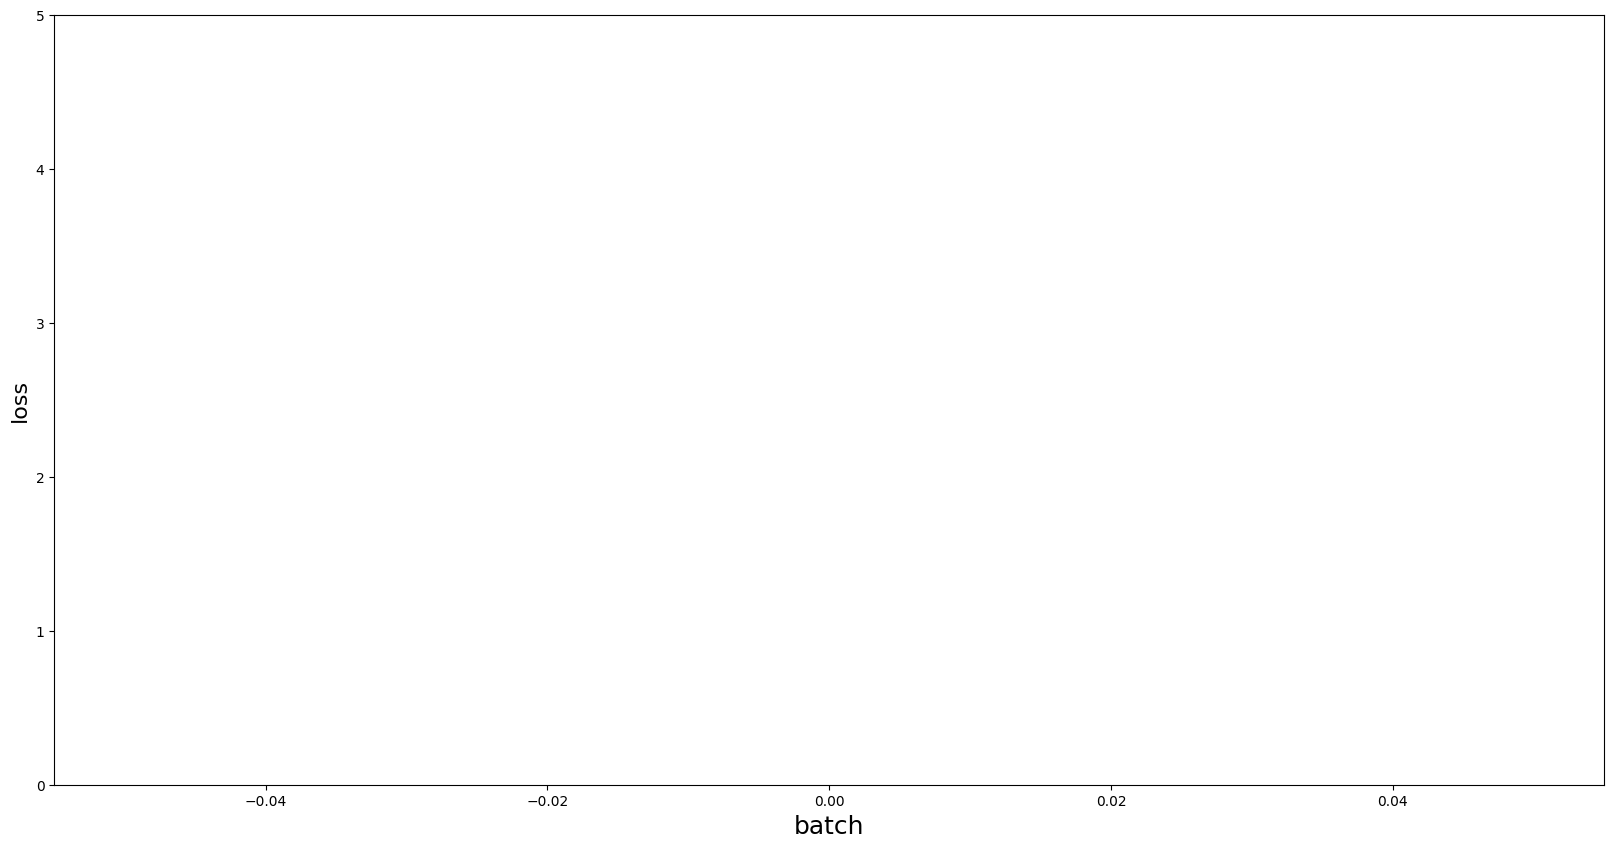

In [ ]:
fig = plt.figure(figsize=(20,10))

plt.plot([x[1] for x in gan.g_losses], color='green', linewidth=0.1) #DISCRIM LOSS
# plt.plot([x[2] for x in gan.g_losses], color='orange', linewidth=0.1)
plt.plot([x[3] for x in gan.g_losses], color='blue', linewidth=0.1) #CYCLE LOSS
# plt.plot([x[4] for x in gan.g_losses], color='orange', linewidth=0.25)
plt.plot([x[5] for x in gan.g_losses], color='red', linewidth=0.25) #ID LOSS
# plt.plot([x[6] for x in gan.g_losses], color='orange', linewidth=0.25)

plt.plot([x[0] for x in gan.g_losses], color='black', linewidth=0.25)

# plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.ylim(0, 5)

plt.show()

Setup




In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 37.7 MB/s eta 0:00:00


In [ ]:
!pip install DataLoader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install git+https://www.github.com/keras-team/keras-contrib.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-bgbw9w8a
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-bgbw9w8a
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done


In [ ]:
 ! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zupapomidorowa","key":"e4812b7613e7944e2e91ff04d0215d91"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 70 Apr 11 00:46 kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d balraj98/apple2orange-dataset

 80% 60.0M/74.8M [00:00<00:00, 111MB/s] 
100% 74.8M/74.8M [00:00<00:00, 98.5MB/s]


In [ ]:
!unzip apple2orange-dataset

Archive:  apple2orange-dataset.zip
  inflating: metadata.csv            
  inflating: testA/n07740461_10011.jpg  
  inflating: testA/n07740461_10080.jpg  
  inflating: testA/n07740461_10211.jpg  
  inflating: testA/n07740461_1030.jpg  
  inflating: testA/n07740461_10311.jpg  
  inflating: testA/n07740461_10371.jpg  
  inflating: testA/n07740461_10571.jpg  
  inflating: testA/n07740461_10651.jpg  
  inflating: testA/n07740461_10681.jpg  
  inflating: testA/n07740461_10750.jpg  
  inflating: testA/n07740461_10940.jpg  
  inflating: testA/n07740461_10950.jpg  
  inflating: testA/n07740461_10951.jpg  
  inflating: testA/n07740461_11040.jpg  
  inflating: testA/n07740461_11041.jpg  
  inflating: testA/n07740461_111.jpg  
  inflating: testA/n07740461_11121.jpg  
  inflating: testA/n07740461_11130.jpg  
  inflating: testA/n07740461_11221.jpg  
  inflating: testA/n07740461_11260.jpg  
  inflating: testA/n07740461_1131.jpg  
  inflating: testA/n07740461_11361.jpg  
  inflating: testA/n07740461_